## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## 0-Import libraries

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## 00-Define helpful functions & classes

In [2]:
# Color & gradient threshold
def pipeline(img):
    img = np.copy(img)   
    
    # Convert to HSV color space and to find yellow and white lines
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h_channel = hsv[:,:,0]
    s_channel = hsv[:,:,1]
    v_channel = hsv[:,:,2]
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sx_thresh = (50, 200)
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold HSV channel
    # Yellow
    h_thresh_yellow = (0, 50)
    s_thresh_yellow = (100, 255)
    v_thresh_yellow = (100, 255)
    h_thresh_white = (20, 255)
    s_thresh_white = (0, 80)
    v_thresh_white = (180, 255) 
    
    # Detect yellow or white
    hsv_binary = np.zeros_like(h_channel)
    hsv_binary[((h_channel >= h_thresh_yellow[0]) & (h_channel <= h_thresh_yellow[1])
              &(s_channel >= s_thresh_yellow[0]) & (s_channel <= s_thresh_yellow[1])
              &(v_channel >= v_thresh_yellow[0]) & (v_channel <= v_thresh_yellow[1]))
              |((h_channel >= h_thresh_white[0]) & (h_channel <= h_thresh_white[1])
              &(s_channel >= s_thresh_white[0]) & (s_channel <= s_thresh_white[1])
              &(v_channel >= v_thresh_white[0]) & (v_channel <= v_thresh_white[1]))]= 1 
    
    # Combine the two binary threshold
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(hsv_binary == 1)|(sxbinary == 1)] = 1
    
#     # Plot the result
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#     f.tight_layout()

#     ax1.imshow(hsv_binary)
#     ax1.set_title('hsv_binary', fontsize=40)

#     ax2.imshow(sxbinary)
#     ax2.set_title('sxbinary', fontsize=40)


#     plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    return combined_binary

# Transfer ROI onto birds eye view
def birdseye_warp(gray):
    img_size = (gray.shape[1], gray.shape[0])
    
    vertices = [[img_size[0]//2-80,470],[200,img_size[1]],[img_size[0]-200,img_size[1]],[img_size[0]//2+80,470]]
    src = np.float32(vertices)
    # Define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    offset = 250
    dst = np.float32([[offset, 0], [offset, img_size[1]], 
                    [img_size[0]-offset, img_size[1]], 
                    [img_size[0]-offset, 0]])
    # Use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(gray, M, img_size)

    return warped, M

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, is_left):
        # 1 for left lines, 0 for right lines
        self.is_left = is_left
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the current fit of the line
        self.current_xfitted = [] 
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        #polynomial coefficients of the last n fits of the line
        self.recent_fit = []
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])] ## In real world (unit: m)
        self.current_fit_pix = [np.array([False])]  ## In pixel
        #radius of curvature of the line in some units
        self.radius_of_curvature = None  ## In real world
        self.radius_of_curvature_pixel = None  ## In pixel
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None 
        
        #Iterations count to take avg 
        self.N = 10      
    
    def avg_fit(self):
        n_fits = self.recent_fit[-self.N:] 
        if(len(self.recent_fit) > self.N):
            self.recent_fit = n_fits
        return np.mean(np.array(n_fits), axis=0)
    
    
    def avg_xfitted(self):
        n_fits = self.recent_xfitted[-self.N:] 
        if(len(self.recent_xfitted) > self.N):
            self.recent_xfitted = n_fits
        return np.mean(np.array(n_fits), axis=0)

    def find_lane_pixels(self, binary_warped):
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Create empty lists to receive left and right lane pixel indices
        lane_inds = []
        
        # Using sliding windows if lane was not detected in the last iteration
        if self.detected == False:
            # Take a histogram of the bottom half of the image
            histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
            # Find the peak of the left and right halves of the histogram
            # These will be the starting point for the left and right lines
            midpoint = np.int(histogram.shape[0]//2)
            if self.is_left == True:
                x_base = np.argmax(histogram[:midpoint])
            if self.is_left == False:
                x_base = np.argmax(histogram[midpoint:]) + midpoint

            # HYPERPARAMETERS
            # Choose the number of sliding windows
            nwindows = 9
            # Set the width of the windows +/- margin
            margin = 70
            # Set minimum number of pixels found to recenter window
            minpix = 50

            # Set height of windows - based on nwindows above and image shape
            window_height = np.int(binary_warped.shape[0]//nwindows)

            # Current positions to be updated later for each window in nwindows
            x_current = x_base 

            # Step through the windows one by one
            for window in range(nwindows):
                # Identify window boundaries in x and y (and right and left)
                win_y_low = binary_warped.shape[0] - (window+1)*window_height
                win_y_high = binary_warped.shape[0] - window*window_height
                win_x_low = x_current - margin  
                win_x_high = x_current + margin   

                ### TO-DO: Identify the nonzero pixels in x and y within the window ###
                good_inds =((nonzeroy > win_y_low) & (nonzeroy < win_y_high) 
                & (nonzerox > win_x_low) & (nonzerox < win_x_high)).nonzero()[0]

                # Append these indices to the lists
                lane_inds.append(good_inds)

                if len(good_inds) > minpix:
                    x_current = np.int(np.mean(nonzerox[good_inds]))

            # Concatenate the arrays of indices (previously was a list of lists of pixels)
            try:
                lane_inds = np.concatenate(lane_inds)
                print("Sliding windows used")
            except ValueError:
                # Avoids an error if the above is not implemented fully
                print("errors in lane_inds = np.concatenate(lane_inds)")
                pass
            
        
        # Searching around previous line if detected
        if self.detected == True:
            margin = 100
            ### Set the area of search based on activated x-values ###
            ### within the +/- margin of our polynomial function ###
            lane_inds = ((nonzerox > (self.current_fit_pix[0]*(nonzeroy**2) + self.current_fit_pix[1]*nonzeroy + 
                            self.current_fit_pix[2] - margin)) & (nonzerox < (self.current_fit_pix[0]*(nonzeroy**2) + 
                            self.current_fit_pix[1]*nonzeroy + self.current_fit_pix[2] + margin)))

        # Extract left and right line pixel positions
        self.allx = nonzerox[lane_inds]
        self.ally = nonzeroy[lane_inds] 

 


    def fit_polynomial(self, binary_warped, xm_per_pix, ym_per_pix):
        # Find our lane pixels first
        self.find_lane_pixels(binary_warped)
        
       
        ### Fit a second order polynomial to each using `np.polyfit`in pixel ###
        self.current_fit_pix = np.polyfit(self.ally,self.allx,2)
        
        if self.current_fit != None:
            self.diffs = self.current_fit
            # Fit a second order polynomial in real world
            self.current_fit = np.polyfit(self.ally*ym_per_pix,self.allx*xm_per_pix,2)

            self.diffs = self.current_fit-self.diffs
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
  
        try:
            self.current_xfitted = self.current_fit_pix[0]*ploty**2 + self.current_fit_pix[1]*ploty + self.current_fit_pix[2]   
            self.detected = True

        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            self.current_xfitted = 1*ploty**2 + 1*ploty
            self.detected = False
        
        # Check poly
        if np.linalg.norm(self.diffs) > 1:
            self.detected = False
            print('Line poly coeff jumped, norm(coeff) is ',np.linalg.norm(self.diffs))
        
        # These will be the starting point for the left and right lines
        midpoint = np.int(binary_warped.shape[1]//2)
        self.line_base_pos = xm_per_pix*(np.mean(self.current_xfitted[-20:])-midpoint)
        
        print ('Line position is',self.line_base_pos,'m')
        
        self.recent_fit.append(self.current_fit)
        self.recent_xfitted.append(self.current_xfitted)
        return ploty
   
    def measure_curvature(self, ploty):
        '''
        Calculates the curvature of polynomial functions in pixels/real.
        '''
        y_eval = np.max(ploty)
        self.radius_of_curvature = ((1 + (2*self.current_fit[0]*y_eval + self.current_fit[1])**2)**1.5) / np.absolute(2*self.current_fit[0])
        return self.radius_of_curvature

# Create an image to draw the lines on
def draw_lane(undist,top_down,perspective_M,ploty,left_fitx,right_fitx):
    warp_zero = np.zeros_like(top_down).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    Minv = np.linalg.inv(perspective_M)

    newwarp = cv2.warpPerspective(color_warp, Minv, (top_down.shape[1], top_down.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    return result

# Declare line objects
left_line = Line(1)
right_line = Line(0)

## 1-Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [11]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
        #cv2.waitKey(500)
#cv2.destroyAllWindows()
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None) 
undist = cv2.undistort(img, mtx, dist, None, mtx)

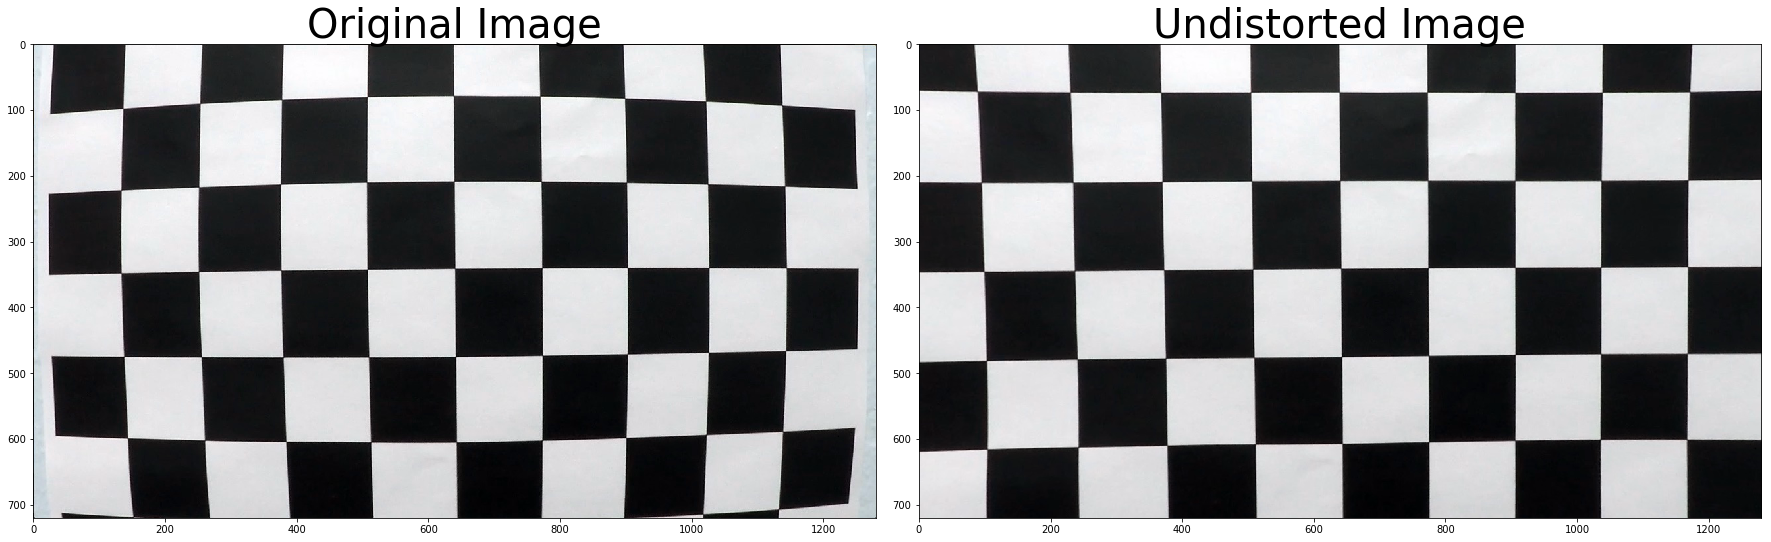

In [13]:
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


#cv2.imwrite('output_images/undist.png',undist)

## 2-Apply a distortion correction to raw images

True

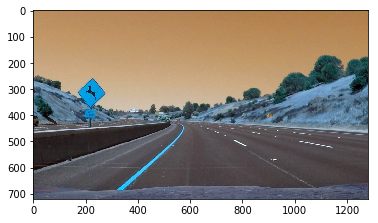

In [15]:
img = cv2.imread('test_images/test2.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(img)

cv2.imwrite('output_images/undist_test2.png',img)

## 3-Use color transforms, gradients, etc., to create a thresholded binary image

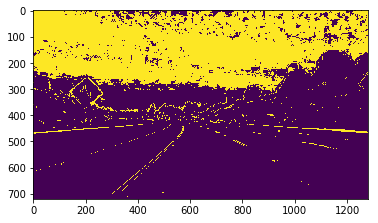

In [16]:
combined_binary = pipeline(undist)
plt.imshow(combined_binary)
# # Plot the result
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
# f.tight_layout()

# ax1.imshow(undist)
# ax1.set_title('Original Image', fontsize=40)

# ax2.imshow(color_binary)
# ax2.set_title('Pipeline Result', fontsize=40)
# plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# cv2.imwrite('output_images/color_binary.png',color_binary)

## 4-Apply a perspective transform to rectify binary image ("birds-eye view")


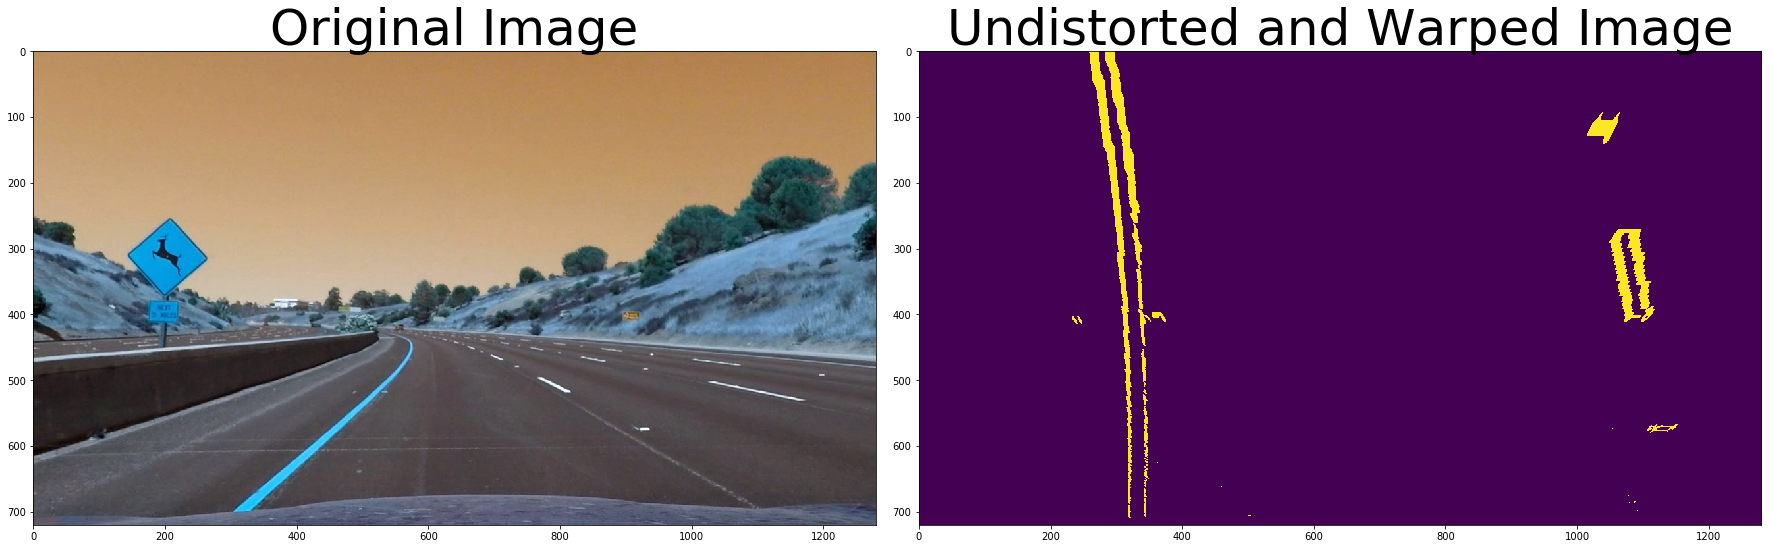

In [72]:
top_down, perspective_M = birdseye_warp(combined_binary)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



## 5-Detect lane pixels and fit to find the lane boundary.

Sliding windows used
Line poly coeff jumped, norm(coeff) is  1.46602420119
Line position is -1.6589671797 m
Sliding windows used
Line poly coeff jumped, norm(coeff) is  5.36165894865
Line position is 2.6099326686 m


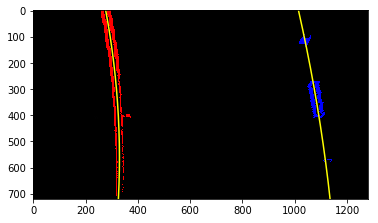

In [73]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

ploty = left_line.fit_polynomial(top_down, xm_per_pix, ym_per_pix)
ploty = right_line.fit_polynomial(top_down, xm_per_pix, ym_per_pix)

## Visualization ##
# Colors in the left and right lane regions
out_img = np.dstack((top_down, top_down, top_down))
out_img[left_line.ally, left_line.allx] = [255, 0, 0]
out_img[right_line.ally, right_line.allx] = [0, 0, 255]

# Plots the left and right polynomials on the lane lines
plt.plot(left_line.current_xfitted, ploty, color='yellow')
plt.plot(right_line.current_xfitted, ploty, color='yellow')

plt.imshow(out_img)


## 6-Determine the curvature of the lane and vehicle position with respect to center.

In [74]:
# Calculate the radius of curvature in pixels for both lane lines
left_line.radius_of_curvature = left_line.measure_curvature(ploty)
right_line.radius_of_curvature = right_line.measure_curvature(ploty)

print(left_line.radius_of_curvature, 'm', right_line.radius_of_curvature, 'm')

1807.20036371 m 2360.65893003 m


## 7-Warp the detected lane boundaries back onto the original image.

True

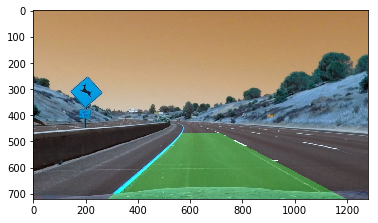

In [75]:
result = draw_lane(undist,top_down,perspective_M,ploty,left_line.current_xfitted,right_line.current_xfitted)
plt.imshow(result)
cv2.imwrite('output_images/draw_lane.png',result)

## 8-Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [6]:
# To check if two lines are reasonable
def check(left: Line,right: Line):
    # Check curvature   
    if (left.radius_of_curvature != None)&(right.radius_of_curvature != None):
        diff_cur = left.radius_of_curvature-right.radius_of_curvature

        cur_thres = 6000 # unit:m 
        if abs(diff_cur) > cur_thres:
            left.detected = False
            right.detected = False
            print('Curvature difference is larger than ',cur_thres,'m')
            return 0
    
    # Check lane width 
    if (left.line_base_pos != None)&(right.line_base_pos != None):
        diff_pos = right.line_base_pos - left.line_base_pos 
        print(diff_pos)
        pos_thres = (3,6)
        if (diff_pos > pos_thres[1])|(diff_pos < pos_thres[0]):
            left.detected = False
            right.detected = False
            print('Lane width is not in the range',pos_thres,'m')
            return 0
    return 1

def process_image(image):
    
    # Undist, apply threshold and transform
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    top_down, perspective_M = birdseye_warp(undist)
    combined_binary = pipeline(top_down)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Find pixel and fit poly
    ploty = left_line.fit_polynomial(combined_binary, xm_per_pix, ym_per_pix)
    ploty = right_line.fit_polynomial(combined_binary, xm_per_pix, ym_per_pix)
    
    
    # Measure curvature
    left_line.radius_of_curvature = left_line.measure_curvature(ploty)
    right_line.radius_of_curvature = right_line.measure_curvature(ploty)
    
 
    
    # Check if poly does not make sense, use poly from last frame
    if check(left_line,right_line) == False:
        left_line.current_xfitted = left_line.recent_xfitted[-2]
        right_line.current_xfitted = right_line.recent_xfitted[-2]
        left_line.current_fit = left_line.recent_fit[-2]
        right_line.current_fit = right_line.recent_fit[-2]

    
    # Store good fits and output average fit
    left_line.bestx = left_line.avg_xfitted()
    right_line.bestx = right_line.avg_xfitted()
    left_line.best_fit = left_line.avg_fit()
    right_line.best_fit = right_line.avg_fit()

    # Draw lane
    result = draw_lane(undist,combined_binary,perspective_M,ploty,left_line.bestx,right_line.bestx)
    
    
        
    
    # Using cv2.putText() method 
    text1 = f"Left Line Curve: {round(left_line.radius_of_curvature,2)} m"
    
   

    text2 = f"Right Line Curve: {round(right_line.radius_of_curvature,2)} m"
    text3 = f"Center offset: {round((left_line.line_base_pos+right_line.line_base_pos)/2,2)} m"
    # font 
    font = cv2.FONT_HERSHEY_SIMPLEX 
  
    # org 
    org1 = (50, 50)
    org2 = (50, 150)
    org3 = (50, 250)

    # fontScale 
    fontScale = 1

    # Blue color in BGR 
    color = (255, 0, 0) 

    # Line thickness of 2 px 
    thickness = 2
    result = cv2.putText(result, text1, org1, font, fontScale, color, thickness, cv2.LINE_AA) 
    result = cv2.putText(result, text2, org2, font, fontScale, color, thickness, cv2.LINE_AA)
    result = cv2.putText(result, text3, org3, font, fontScale, color, thickness, cv2.LINE_AA)
    return result




## Project video

In [9]:
# Reset lines
left_line = Line(1)
right_line = Line(0)

white_output = 'output_project_video_oop.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
#clip1 = VideoFileClip("project_video.mp4").subclip(0,1)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Sliding windows used
Line poly coeff jumped, norm(coeff) is  1.48580760533
Line position is -1.66586603886 m
Sliding windows used
Line poly coeff jumped, norm(coeff) is  5.35203435568
Line position is 2.60642539361 m
4.27229143248
[MoviePy] >>>> Building video output_project_video_oop.mp4
[MoviePy] Writing video output_project_video_oop.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

Sliding windows used
Line position is -1.66586603886 m
Sliding windows used
Line position is

  0%|          | 1/1261 [00:00<03:22,  6.23it/s]

 2.60642539361 m
4.27229143248
Line position is -1.67452394417 m
Line position is 2.66529801312 m
4.33982195729


  0%|          | 2/1261 [00:00<03:32,  5.92it/s]

Line position is -1.67733040505 m
Line position is 2.66382392276 m
Curvature difference is larger than  6000 m


  0%|          | 3/1261 [00:00<03:29,  6.02it/s]

Sliding windows used
Line position is -1.65921564047 m
Sliding windows used
Line position is 2.61012331197 m
4.26933895244


  0%|          | 4/1261 [00:00<03:26,  6.09it/s]

Line position is -1.65989224781 m
Line position is 2.6262464998 m
4.28613874761


  0%|          | 6/1261 [00:00<03:23,  6.18it/s]

Line position is -1.65091746239 m
Line position is 2.62607272788 m
4.27699019027


  1%|          | 7/1261 [00:01<03:22,  6.20it/s]

Line position is -1.64387229895 m
Line position is 2.6315580012 m
4.27543030015


  1%|          | 8/1261 [00:01<03:21,  6.22it/s]

Line position is -1.62599028542 m
Line position is 2.86290260171 m
4.48889288713
Line position is -1.62730656441 m
Line position is 2.99610386559 m
4.62341043


  1%|          | 9/1261 [00:01<03:21,  6.23it/s]

Line position is -1.63021595835 m
Line position is 2.89994656056 m
4.53016251891


  1%|          | 11/1261 [00:01<03:20,  6.24it/s]

Line position is -1.62502334562 m
Line position is 2.81538148259 m
4.4404048282


  1%|          | 12/1261 [00:01<03:20,  6.24it/s]

Line position is -1.6310715338 m
Line position is 2.7540309263 m
Curvature difference is larger than  6000 m


  1%|          | 13/1261 [00:02<03:18,  6.29it/s]

Sliding windows used
Line position is -1.62518226507 m
Sliding windows used
Line position is 2.61592395392 m
4.24110621899


  1%|          | 14/1261 [00:02<03:15,  6.38it/s]

Line position is -1.63422111321 m
Line position is 2.68967217436 m
4.32389328757


  1%|          | 15/1261 [00:02<03:13,  6.44it/s]

Line position is -1.63253803017 m
Line position is 2.6789367202 m
Curvature difference is larger than  6000 m


  1%|▏         | 16/1261 [00:02<03:13,  6.43it/s]

Sliding windows used
Line position is -1.61646013068 m
Sliding windows used
Line position is 2.58282987173 m
4.19929000241


  1%|▏         | 17/1261 [00:02<03:10,  6.52it/s]

Line position is -1.62831097982 m
Line position is 2.58492702506 m
4.21323800488


  1%|▏         | 18/1261 [00:02<03:10,  6.54it/s]

Line position is -1.62225191933 m
Line position is 2.58058025397 m
4.2028321733


  2%|▏         | 19/1261 [00:03<03:09,  6.55it/s]

Line position is -1.62467716516 m
Line position is 2.58613644407 m
4.21081360923
Line position is -1.62527313735 m
Line position is 2.60226421642 m
Curvature difference is larger than  6000 m


  2%|▏         | 20/1261 [00:03<03:15,  6.34it/s]

Sliding windows used
Line position is -1.62718642137 m
Sliding windows used
Line position is 2.53933803609 m
4.16652445746


  2%|▏         | 21/1261 [00:03<03:15,  6.33it/s]

Line position is -1.63389300313 m
Line position is 2.68707793923 m
4.32097094236


  2%|▏         | 23/1261 [00:03<03:16,  6.30it/s]

Line position is -1.65317657828 m
Line position is 2.74301205076 m
4.39618862904


  2%|▏         | 24/1261 [00:03<03:16,  6.29it/s]

Line position is -1.66751333926 m
Line position is 2.71849571916 m
4.38600905843


  2%|▏         | 25/1261 [00:03<03:16,  6.28it/s]

Line position is -1.68040970083 m
Line position is 2.64062781416 m
4.32103751498


  2%|▏         | 26/1261 [00:04<03:14,  6.36it/s]

Line position is -1.69956705983 m
Line position is 2.68422318634 m
4.38379024617


  2%|▏         | 27/1261 [00:04<03:11,  6.43it/s]

Line position is -1.72048492834 m
Line position is 2.64114480339 m
Curvature difference is larger than  6000 m


  2%|▏         | 28/1261 [00:04<03:10,  6.47it/s]

Sliding windows used
Line position is -1.72720805446 m
Sliding windows used
Line position is 2.54229432686 m
4.26950238132


  2%|▏         | 29/1261 [00:04<03:09,  6.50it/s]

Line position is -1.7552432113 m
Line position is 2.56692898181 m
4.32217219311
Line position is -1.75582845099 m
Line position is 2.56567592739 m
4.32150437838


  2%|▏         | 31/1261 [00:04<03:09,  6.48it/s]

Line position is -1.75494352275 m
Line position is 2.57151150339 m
4.32645502614


  3%|▎         | 32/1261 [00:05<03:07,  6.56it/s]

Line position is -1.75089419897 m
Line position is 2.56865945204 m
4.31955365102


  3%|▎         | 33/1261 [00:05<03:06,  6.57it/s]

Line position is -1.75504167339 m
Line position is 2.64215024246 m
4.39719191585


  3%|▎         | 34/1261 [00:05<03:05,  6.62it/s]

Line position is -1.7464419935 m
Line position is 2.85235699632 m
4.59879898982


  3%|▎         | 35/1261 [00:05<03:04,  6.66it/s]

Line position is -1.73922731219 m
Line position is 2.89622681977 m
4.63545413196


  3%|▎         | 36/1261 [00:05<03:04,  6.64it/s]

Line position is -1.72835402445 m
Line position is 2.83162094834 m
4.55997497278


  3%|▎         | 37/1261 [00:05<03:03,  6.67it/s]

Line position is -1.72009671551 m
Line position is 2.73776237077 m
4.45785908628


  3%|▎         | 38/1261 [00:05<03:02,  6.70it/s]

Line position is -1.71725890998 m
Line position is 2.76158947628 m
4.47884838626


  3%|▎         | 39/1261 [00:06<03:03,  6.66it/s]

Line position is -1.71742042298 m
Line position is 2.73961210974 m
4.45703253272


  3%|▎         | 40/1261 [00:06<03:01,  6.72it/s]

Line position is -1.71931283201 m
Line position is 2.650476346 m
4.36978917801


  3%|▎         | 41/1261 [00:06<03:02,  6.70it/s]

Line position is -1.71753277231 m
Line position is 2.57094869177 m
4.28848146408


  3%|▎         | 42/1261 [00:06<03:02,  6.66it/s]

Line position is -1.71183512042 m
Line position is 2.54605809318 m
4.2578932136


  3%|▎         | 43/1261 [00:06<04:38,  4.38it/s]

Line position is -1.69918860344 m
Line position is 2.55426194711 m
4.25345055054


  3%|▎         | 44/1261 [00:07<04:35,  4.42it/s]

Line position is -1.70045296505 m
Line position is 2.56663456699 m
4.26708753204


  4%|▎         | 45/1261 [00:07<04:51,  4.17it/s]

Line position is -1.69843262702 m
Line position is 2.58689661434 m
4.28532924136


  4%|▎         | 46/1261 [00:07<04:55,  4.11it/s]

Line position is -1.69309998808 m
Line position is 2.74635302552 m
4.4394530136


  4%|▎         | 47/1261 [00:07<04:44,  4.27it/s]

Line position is -1.69366171218 m
Line position is 2.89860061541 m
4.5922623276


  4%|▍         | 48/1261 [00:08<04:51,  4.16it/s]

Line position is -1.68771335268 m
Line position is 2.86858639258 m
4.55629974525


  4%|▍         | 49/1261 [00:08<04:39,  4.33it/s]

Line position is -1.68815920791 m
Line position is 2.77922172901 m
4.46738093693


  4%|▍         | 50/1261 [00:08<04:47,  4.22it/s]

Line position is -1.68087637462 m
Line position is 2.71094885636 m
Curvature difference is larger than  6000 m
Sliding windows used


  4%|▍         | 51/1261 [00:08<04:36,  4.38it/s]

Line position is -1.67658169798 m
Sliding windows used
Line position is 2.52037968107 m
4.19696137905


  4%|▍         | 52/1261 [00:09<04:46,  4.22it/s]

Line position is -1.68004436425 m
Line position is 2.56774431336 m
4.24778867761


  4%|▍         | 53/1261 [00:09<04:36,  4.37it/s]

Line position is -1.67758177469 m
Line position is 2.5597617822 m
4.23734355689


  4%|▍         | 54/1261 [00:09<04:46,  4.21it/s]

Line position is -1.67755024332 m
Line position is 2.55096618697 m
4.22851643029


  4%|▍         | 55/1261 [00:09<04:38,  4.33it/s]

Line position is -1.67073679817 m
Line position is 2.54777356769 m
4.21851036585


  4%|▍         | 56/1261 [00:10<04:43,  4.26it/s]

Line position is -1.66851205766 m
Line position is 2.55604612854 m
4.22455818619


  5%|▍         | 57/1261 [00:10<04:50,  4.14it/s]

Line position is -1.66846734323 m
Line position is 2.56411607597 m
4.2325834192


  5%|▍         | 58/1261 [00:10<04:39,  4.30it/s]

Line position is -1.6674185391 m
Line position is 2.61263976545 m
4.28005830455


  5%|▍         | 59/1261 [00:10<04:43,  4.24it/s]

Line position is -1.65914763592 m
Line position is 2.77205864326 m
4.43120627918


  5%|▍         | 60/1261 [00:11<05:17,  3.78it/s]

Line position is -1.661316467 m
Line position is 2.81174419539 m
4.47306066239


  5%|▍         | 61/1261 [00:11<05:08,  3.88it/s]

Line position is -1.67390711683 m
Line position is 2.74869732643 m
4.42260444326


  5%|▍         | 62/1261 [00:11<05:03,  3.95it/s]

Line position is -1.6837588184 m
Line position is 2.65310648041 m
4.33686529881


  5%|▍         | 63/1261 [00:11<04:48,  4.15it/s]

Line position is -1.69727021706 m
Line position is 2.68596598375 m
4.38323620081


  5%|▌         | 64/1261 [00:12<04:56,  4.03it/s]

Line position is -1.71438899518 m
Line position is 2.64529628684 m
4.35968528201


  5%|▌         | 65/1261 [00:12<04:42,  4.24it/s]

Line position is -1.73613630673 m
Line position is 2.55997575854 m
Curvature difference is larger than  6000 m


  5%|▌         | 66/1261 [00:12<04:47,  4.15it/s]

Sliding windows used
Line position is -1.7343316169 m
Sliding windows used
Line position is 2.46071708118 m
4.19504869808


  5%|▌         | 67/1261 [00:12<04:51,  4.10it/s]

Line position is -1.76286397611 m
Line position is 2.46038392587 m
4.22324790198


  5%|▌         | 68/1261 [00:12<04:52,  4.08it/s]

Line position is -1.772891341 m
Line position is 2.45834095373 m
4.23123229472


  5%|▌         | 69/1261 [00:13<05:04,  3.91it/s]

Line position is -1.7794809095 m
Line position is 2.44750063635 m
4.22698154585


  6%|▌         | 70/1261 [00:13<05:03,  3.93it/s]

Line position is -1.79021508785 m
Line position is 2.45347769547 m
4.24369278332


  6%|▌         | 71/1261 [00:13<05:13,  3.80it/s]

Line position is -1.78849064279 m
Line position is 2.52598604385 m
4.31447668664


  6%|▌         | 72/1261 [00:14<05:13,  3.79it/s]

Line position is -1.79295466463 m
Line position is 2.55256520818 m
Curvature difference is larger than  6000 m


  6%|▌         | 73/1261 [00:14<05:13,  3.79it/s]

Sliding windows used
Line position is -1.79056187681 m
Sliding windows used
Line position is 2.42771810182 m
4.21827997862


  6%|▌         | 74/1261 [00:14<05:07,  3.86it/s]

Line position is -1.78365151777 m
Line position is 2.40721806262 m
4.19086958039


  6%|▌         | 75/1261 [00:14<05:04,  3.89it/s]

Line position is -1.78769149848 m
Line position is 2.42044809295 m
4.20813959143


  6%|▌         | 76/1261 [00:15<04:47,  4.13it/s]

Line position is -1.77782165303 m
Line position is 2.36537412701 m
4.14319578003


  6%|▌         | 77/1261 [00:15<04:54,  4.02it/s]

Line position is -1.78398559494 m
Line position is 2.38244081308 m
4.16642640802


  6%|▌         | 78/1261 [00:15<04:38,  4.25it/s]

Line position is -1.78689073232 m
Line position is 2.38475488251 m
4.17164561484


  6%|▋         | 79/1261 [00:15<04:46,  4.12it/s]

Line position is -1.79950369689 m
Line position is 2.39848457809 m
4.19798827498


  6%|▋         | 80/1261 [00:15<04:35,  4.28it/s]

Line position is -1.81373667334 m
Line position is 2.39455992451 m
4.20829659785


  6%|▋         | 81/1261 [00:16<04:40,  4.20it/s]

Line position is -1.81028127314 m
Line position is 2.392260211 m
4.20254148413


  7%|▋         | 82/1261 [00:16<04:29,  4.37it/s]

Line position is -1.82445122424 m
Line position is 2.3915952631 m
4.21604648734


  7%|▋         | 83/1261 [00:16<04:36,  4.26it/s]

Line position is -1.84064628176 m
Line position is 2.40146416204 m
4.24211044381


  7%|▋         | 84/1261 [00:16<04:25,  4.44it/s]

Line position is -1.85772889302 m
Line position is 2.43606794042 m
Curvature difference is larger than  6000 m


  7%|▋         | 85/1261 [00:17<04:34,  4.28it/s]

Sliding windows used
Line position is -1.87335413184 m
Sliding windows used
Line position is 2.43501710514 m
4.30837123698


  7%|▋         | 86/1261 [00:17<04:25,  4.43it/s]

Line position is -1.88475674425 m
Line position is 2.40435470713 m
4.28911145138


  7%|▋         | 87/1261 [00:17<04:30,  4.35it/s]

Line position is -1.88415600016 m
Line position is 2.39708710256 m
4.28124310272


  7%|▋         | 88/1261 [00:17<04:36,  4.25it/s]

Line position is -1.88460098719 m
Line position is 2.32803066876 m
4.21263165595


  7%|▋         | 89/1261 [00:18<04:24,  4.42it/s]

Line position is -1.89224789917 m
Line position is 2.35344960513 m
4.2456975043


  7%|▋         | 90/1261 [00:18<04:35,  4.25it/s]

Line position is -1.88553958052 m
Line position is 2.36125542241 m
4.24679500293


  7%|▋         | 91/1261 [00:18<04:29,  4.34it/s]

Line position is -1.89479354744 m
Line position is 2.36882210581 m
4.26361565325


  7%|▋         | 92/1261 [00:18<04:32,  4.29it/s]

Line position is -1.89231260892 m
Line position is 2.374004613 m
4.26631722191


  7%|▋         | 93/1261 [00:19<04:34,  4.25it/s]

Line position is -1.88113888277 m
Line position is 2.37629652813 m
4.2574354109


  7%|▋         | 94/1261 [00:19<04:33,  4.27it/s]

Line position is -1.87513671811 m
Line position is 2.38506391519 m
4.2602006333


  8%|▊         | 95/1261 [00:19<04:35,  4.24it/s]

Line position is -1.87548599795 m
Line position is 2.38044023497 m
4.25592623292


  8%|▊         | 96/1261 [00:19<04:23,  4.42it/s]

Line position is -1.86937586444 m
Line position is 2.42118947041 m
Curvature difference is larger than  6000 m


  8%|▊         | 97/1261 [00:20<05:21,  3.62it/s]

Sliding windows used
Line position is -1.8651317769 m
Sliding windows used
Line position is 2.37120164153 m
4.23633341843


  8%|▊         | 98/1261 [00:20<06:02,  3.21it/s]

Line position is -1.85945150144 m
Line position is 2.36041604128 m
4.21986754273


  8%|▊         | 99/1261 [00:20<05:40,  3.41it/s]

Line position is -1.84557244556 m
Line position is 2.34569483419 m
4.19126727975


  8%|▊         | 100/1261 [00:20<05:23,  3.59it/s]

Line position is -1.84186420402 m
Line position is 2.34591349039 m
4.18777769442


  8%|▊         | 101/1261 [00:21<05:09,  3.75it/s]

Line position is -1.83125396746 m
Line position is 2.28177844763 m
4.11303241509


  8%|▊         | 102/1261 [00:21<04:59,  3.86it/s]

Line position is -1.82391894927 m
Line position is 2.29879130656 m
4.12271025583


  8%|▊         | 103/1261 [00:21<04:58,  3.88it/s]

Line position is -1.8225322871 m
Line position is 2.32525080578 m
4.14778309288


  8%|▊         | 104/1261 [00:21<04:49,  4.00it/s]

Line position is -1.81632876088 m
Line position is 2.34099603335 m
4.15732479423


  8%|▊         | 105/1261 [00:22<04:51,  3.97it/s]

Line position is -1.81802314822 m
Line position is 2.3684007135 m
4.18642386173
Line position is -1.80839582873 m


  8%|▊         | 106/1261 [00:22<04:32,  4.23it/s]

Line position is 2.38512693245 m
4.19352276117


  8%|▊         | 107/1261 [00:22<04:39,  4.13it/s]

Line position is -1.80909654694 m
Line position is 2.41391625728 m
4.22301280421


  9%|▊         | 108/1261 [00:22<04:26,  4.33it/s]

Line position is -1.79842354323 m
Line position is 2.4192386456 m
4.21766218884


  9%|▊         | 109/1261 [00:23<04:30,  4.26it/s]

Line position is -1.79723731696 m
Line position is 2.46305527729 m
4.26029259426


  9%|▊         | 110/1261 [00:23<04:23,  4.36it/s]

Line position is -1.79244341766 m
Line position is 2.46753787183 m
4.25998128948


  9%|▉         | 111/1261 [00:23<04:35,  4.17it/s]

Line position is -1.7928522132 m
Line position is 2.43889358199 m
4.23174579519


  9%|▉         | 112/1261 [00:23<04:28,  4.28it/s]

Line position is -1.79803560081 m
Line position is 2.46246990108 m
4.26050550189


  9%|▉         | 113/1261 [00:24<04:40,  4.10it/s]

Line position is -1.78765505389 m
Line position is 2.46025965382 m
4.24791470771


  9%|▉         | 114/1261 [00:24<04:27,  4.29it/s]

Line position is -1.78092624824 m
Line position is 2.44029196441 m
4.22121821265


  9%|▉         | 115/1261 [00:24<04:35,  4.17it/s]

Line position is -1.77871170509 m
Line position is 2.44418785236 m
4.22289955745


  9%|▉         | 116/1261 [00:24<04:23,  4.34it/s]

Line position is -1.7737885674 m
Line position is 2.44544402464 m
4.21923259204


  9%|▉         | 117/1261 [00:24<04:28,  4.26it/s]

Line position is -1.77198453264 m
Line position is 2.45348166138 m
4.22546619402


  9%|▉         | 118/1261 [00:25<04:18,  4.41it/s]

Line position is -1.75606099139 m
Line position is 2.45663283763 m
4.21269382902


  9%|▉         | 119/1261 [00:25<04:24,  4.31it/s]

Line position is -1.75154957105 m
Line position is 2.46118081817 m
4.21273038922


 10%|▉         | 120/1261 [00:25<04:36,  4.12it/s]

Line position is -1.73991203539 m
Line position is 2.45871557454 m
4.19862760994


 10%|▉         | 121/1261 [00:25<04:34,  4.16it/s]

Line position is -1.73155047129 m
Line position is 2.47049664484 m
4.20204711613


 10%|▉         | 122/1261 [00:26<04:31,  4.20it/s]

Line position is -1.72442600405 m
Line position is 2.44860236423 m
4.17302836827


 10%|▉         | 123/1261 [00:26<04:30,  4.21it/s]

Line position is -1.71535442789 m
Line position is 2.45643888345 m
4.17179331134


 10%|▉         | 124/1261 [00:26<04:28,  4.24it/s]

Line position is -1.70934613365 m
Line position is 2.45980402848 m
4.16915016212


 10%|▉         | 125/1261 [00:26<04:27,  4.24it/s]

Line position is -1.70289027624 m
Line position is 2.45350480695 m
4.15639508319


 10%|▉         | 126/1261 [00:27<04:26,  4.26it/s]

Line position is -1.70078082464 m
Line position is 2.44864530226 m
4.14942612691


 10%|█         | 127/1261 [00:27<04:25,  4.28it/s]

Line position is -1.69589026204 m
Line position is 2.47096704629 m
4.16685730833


 10%|█         | 128/1261 [00:27<04:27,  4.24it/s]

Line position is -1.69253344708 m
Line position is 2.48395668723 m
4.17649013431


 10%|█         | 129/1261 [00:27<04:28,  4.22it/s]

Line position is -1.69053793834 m
Line position is 2.48755173279 m
4.17808967113


 10%|█         | 130/1261 [00:28<04:30,  4.18it/s]

Line position is -1.69491724781 m
Line position is 2.4954896564 m
4.19040690421


 10%|█         | 131/1261 [00:28<04:29,  4.20it/s]

Line position is -1.6776038182 m
Line position is 2.50112288853 m
4.17872670673


 10%|█         | 132/1261 [00:28<04:30,  4.17it/s]

Line position is -1.6553403787 m
Line position is 2.5112911526 m
4.1666315313


 11%|█         | 133/1261 [00:28<04:36,  4.09it/s]

Line position is -1.64612213562 m
Line position is 2.52945430536 m
4.17557644098


 11%|█         | 134/1261 [00:29<04:32,  4.13it/s]

Line position is -1.62999271116 m
Line position is 2.65430025049 m
4.28429296165


 11%|█         | 135/1261 [00:29<04:35,  4.08it/s]

Line position is -1.62152621697 m
Line position is 2.73197233057 m
4.35349854754


 11%|█         | 136/1261 [00:29<04:21,  4.30it/s]

Line position is -1.61806400295 m
Line position is 2.79344499991 m
4.41150900286


 11%|█         | 137/1261 [00:29<04:28,  4.19it/s]

Line position is -1.62144576061 m
Line position is 2.76541206839 m
4.386857829
Line position is -1.63051011494 m


 11%|█         | 138/1261 [00:29<04:14,  4.41it/s]

Line position is 2.70373377462 m
4.33424388955


 11%|█         | 139/1261 [00:30<04:20,  4.31it/s]

Line position is -1.64085309425 m
Line position is 2.69444980629 m
Curvature difference is larger than  6000 m
Sliding windows used


 11%|█         | 140/1261 [00:30<04:13,  4.42it/s]

Line position is -1.64017780361 m
Sliding windows used
Line position is 2.56422963933 m
4.20440744294


 11%|█         | 141/1261 [00:30<04:16,  4.37it/s]

Line position is -1.66295100187 m
Line position is 2.60708518216 m
4.27003618403


 11%|█▏        | 142/1261 [00:30<04:26,  4.20it/s]

Line position is -1.67660806132 m
Line position is 2.59207810956 m
4.26868617089


 11%|█▏        | 143/1261 [00:31<04:27,  4.18it/s]

Line position is -1.66903725276 m
Line position is 2.57136012787 m
4.24039738062


 11%|█▏        | 144/1261 [00:31<04:29,  4.14it/s]

Line position is -1.67748864348 m
Line position is 2.56389381186 m
4.24138245534


 11%|█▏        | 145/1261 [00:31<04:32,  4.09it/s]

Line position is -1.68359185878 m
Line position is 2.57091515237 m
4.25450701115


 12%|█▏        | 146/1261 [00:31<04:35,  4.05it/s]

Line position is -1.67941310405 m
Line position is 2.60850736739 m
4.28792047145


 12%|█▏        | 147/1261 [00:32<04:35,  4.05it/s]

Line position is -1.67782281447 m
Line position is 2.81926069789 m
4.49708351237


 12%|█▏        | 148/1261 [00:32<04:31,  4.10it/s]

Line position is -1.66010850815 m
Line position is 2.89202444338 m
4.55213295153


 12%|█▏        | 149/1261 [00:32<04:31,  4.10it/s]

Line position is -1.6563689341 m
Line position is 2.86194393801 m
4.5183128721


 12%|█▏        | 150/1261 [00:32<04:34,  4.04it/s]

Line position is -1.65922324923 m
Line position is 2.78678058369 m
4.44600383292


 12%|█▏        | 151/1261 [00:33<04:22,  4.22it/s]

Line position is -1.659009885 m
Line position is 2.83221021746 m
4.49122010245


 12%|█▏        | 152/1261 [00:33<04:26,  4.16it/s]

Line position is -1.66890487793 m
Line position is 2.78522145271 m
4.45412633064


 12%|█▏        | 153/1261 [00:33<04:15,  4.34it/s]

Line position is -1.6689005834 m
Line position is 2.69447918099 m
4.36337976439


 12%|█▏        | 154/1261 [00:33<04:18,  4.29it/s]

Line position is -1.67745832044 m
Line position is 2.59898227614 m
Curvature difference is larger than  6000 m


 12%|█▏        | 155/1261 [00:34<04:20,  4.25it/s]

Sliding windows used
Line position is -1.67803299868 m
Sliding windows used
Line position is 2.53633793252 m
4.2143709312


 12%|█▏        | 156/1261 [00:34<04:24,  4.18it/s]

Line position is -1.68684791943 m
Line position is 2.53592323635 m
4.22277115578


 12%|█▏        | 157/1261 [00:34<04:34,  4.02it/s]

Line position is -1.69525879353 m
Line position is 2.53076977583 m
4.22602856936


 13%|█▎        | 158/1261 [00:34<04:27,  4.12it/s]

Line position is -1.70573042957 m
Line position is 2.51722530212 m
4.22295573169


 13%|█▎        | 159/1261 [00:34<04:27,  4.11it/s]

Line position is -1.72107239481 m
Line position is 2.64693548438 m
Curvature difference is larger than  6000 m


 13%|█▎        | 160/1261 [00:35<04:33,  4.03it/s]

Sliding windows used
Line position is -1.732920688 m
Sliding windows used
Line position is 2.48943118129 m
4.22235186928


 13%|█▎        | 161/1261 [00:35<04:39,  3.94it/s]

Line position is -1.74180488698 m
Line position is 2.51336876717 m
4.25517365415


 13%|█▎        | 162/1261 [00:35<04:26,  4.12it/s]

Line position is -1.74983585679 m
Line position is 2.53952420131 m
4.2893600581


 13%|█▎        | 163/1261 [00:36<04:37,  3.96it/s]

Line position is -1.75579246487 m
Line position is 2.56383121677 m
4.31962368165


 13%|█▎        | 164/1261 [00:36<04:35,  3.98it/s]

Line position is -1.76467723248 m
Line position is 2.62206075991 m
Curvature difference is larger than  6000 m


 13%|█▎        | 165/1261 [00:36<04:36,  3.96it/s]

Sliding windows used
Line position is -1.74742154202 m
Sliding windows used
Line position is 2.53211933989 m
4.27954088192


 13%|█▎        | 166/1261 [00:36<04:22,  4.18it/s]

Line position is -1.76451357213 m
Line position is 2.54156420672 m
4.30607777885


 13%|█▎        | 167/1261 [00:36<04:27,  4.09it/s]

Line position is -1.77072510656 m
Line position is 2.52572435953 m
4.29644946609


 13%|█▎        | 168/1261 [00:37<04:15,  4.28it/s]

Line position is -1.75941241956 m
Line position is 2.52761517949 m
4.28702759906


 13%|█▎        | 169/1261 [00:37<04:25,  4.11it/s]

Line position is -1.76497782152 m
Line position is 2.52787157981 m
4.29284940133


 13%|█▎        | 170/1261 [00:37<04:15,  4.27it/s]

Line position is -1.77890511972 m
Line position is 2.52790643452 m
Curvature difference is larger than  6000 m


 14%|█▎        | 171/1261 [00:37<04:29,  4.05it/s]

Sliding windows used
Line position is -1.78283415042 m
Sliding windows used
Line position is 2.51183017418 m
Curvature difference is larger than  6000 m


 14%|█▎        | 172/1261 [00:38<04:18,  4.21it/s]

Sliding windows used
Line position is -1.78681320878 m
Sliding windows used
Line position is 2.49562689093 m
Curvature difference is larger than  6000 m


 14%|█▎        | 173/1261 [00:38<04:23,  4.13it/s]

Sliding windows used
Line position is -1.78890667003 m
Sliding windows used
Line position is 2.43848849284 m
4.22739516287


 14%|█▍        | 174/1261 [00:38<04:11,  4.32it/s]

Line position is -1.78361043965 m
Line position is 2.39611746527 m
4.17972790492


 14%|█▍        | 175/1261 [00:38<04:16,  4.23it/s]

Line position is -1.77862045527 m
Line position is 2.40186556794 m
4.18048602321
Line position is

 14%|█▍        | 176/1261 [00:39<04:05,  4.42it/s]

 -1.78640496269 m
Line position is 2.34089373788 m
4.12729870058


 14%|█▍        | 177/1261 [00:39<04:10,  4.33it/s]

Line position is -1.79326974002 m
Line position is 2.36893144937 m
4.16220118939


 14%|█▍        | 178/1261 [00:39<04:24,  4.09it/s]

Line position is -1.79945003556 m
Line position is 2.40637569768 m
4.20582573325


 14%|█▍        | 179/1261 [00:39<04:23,  4.11it/s]

Line position is -1.80452725882 m
Line position is 2.43169761671 m
4.23622487553


 14%|█▍        | 180/1261 [00:40<04:23,  4.11it/s]

Line position is -1.80237578471 m
Line position is 2.46062442751 m
4.26300021222


 14%|█▍        | 181/1261 [00:40<04:24,  4.09it/s]

Line position is -1.81400074235 m
Line position is 2.46526030662 m
4.27926104896


 14%|█▍        | 182/1261 [00:40<04:13,  4.26it/s]

Line position is -1.83236448949 m
Line position is 2.48259798913 m
4.31496247862


 15%|█▍        | 183/1261 [00:40<04:13,  4.25it/s]

Line position is -1.84010304898 m
Line position is 2.4873769839 m
4.32748003287


 15%|█▍        | 184/1261 [00:41<04:18,  4.16it/s]

Line position is -1.8405907226 m
Line position is 2.51788134875 m
4.35847207135


 15%|█▍        | 185/1261 [00:41<04:20,  4.13it/s]

Line position is -1.84999130056 m
Line position is 2.55825123815 m
4.40824253871


 15%|█▍        | 186/1261 [00:41<04:22,  4.09it/s]

Line position is -1.846491482 m
Line position is 2.56749406601 m
4.413985548


 15%|█▍        | 187/1261 [00:41<04:10,  4.28it/s]

Line position is -1.8441598715 m
Line position is 2.55379945301 m
4.39795932451


 15%|█▍        | 188/1261 [00:41<04:13,  4.23it/s]

Line position is -1.83787253544 m
Line position is 2.61758522397 m
4.45545775941


 15%|█▍        | 189/1261 [00:42<04:18,  4.14it/s]

Line position is -1.82816873004 m
Line position is 2.62977366889 m
Curvature difference is larger than  6000 m


 15%|█▌        | 190/1261 [00:42<04:24,  4.05it/s]

Sliding windows used
Line position is -1.79756709375 m
Sliding windows used
Line position is 2.49204429768 m
4.28961139143


 15%|█▌        | 191/1261 [00:42<04:28,  3.99it/s]

Line position is -1.79389568877 m
Line position is 2.49589539181 m
4.28979108058


 15%|█▌        | 192/1261 [00:43<04:32,  3.93it/s]

Line position is -1.77121134749 m
Line position is 2.50416715693 m
4.27537850442


 15%|█▌        | 193/1261 [00:43<04:33,  3.90it/s]

Line position is -1.74451108087 m
Line position is 2.50999136405 m
4.25450244492


 15%|█▌        | 194/1261 [00:43<04:28,  3.98it/s]

Line position is -1.72826987136 m
Line position is 2.51092890813 m
4.23919877949


 15%|█▌        | 195/1261 [00:43<04:26,  3.99it/s]

Line position is -1.72056119724 m
Line position is 2.51106863474 m
4.23162983199


 16%|█▌        | 196/1261 [00:43<04:11,  4.23it/s]

Line position is -1.73093253443 m
Line position is 2.58690216178 m
4.31783469621


 16%|█▌        | 197/1261 [00:44<04:22,  4.05it/s]

Line position is -1.74914000375 m
Line position is 2.70837481189 m
4.45751481564


 16%|█▌        | 198/1261 [00:44<04:28,  3.97it/s]

Line position is -1.76542630684 m
Line position is 2.7713931424 m
4.53681944924


 16%|█▌        | 199/1261 [00:44<04:12,  4.21it/s]

Line position is -1.78155870098 m
Line position is 2.7503288544 m
4.53188755538


 16%|█▌        | 200/1261 [00:44<04:16,  4.13it/s]

Line position is -1.78810922319 m
Line position is 2.68986560732 m
4.47797483051


 16%|█▌        | 201/1261 [00:45<04:06,  4.29it/s]

Line position is -1.80404228978 m
Line position is 2.71510846941 m
4.51915075919


 16%|█▌        | 202/1261 [00:45<04:12,  4.19it/s]

Line position is -1.81040215816 m
Line position is 2.6447349927 m
Curvature difference is larger than  6000 m
Sliding windows used


 16%|█▌        | 203/1261 [00:45<04:02,  4.36it/s]

Line position is -1.79883202754 m
Sliding windows used
Line position is 2.52328041457 m
4.32211244211


 16%|█▌        | 204/1261 [00:45<04:09,  4.23it/s]

Line position is -1.82035995081 m
Line position is 2.53194219086 m
4.35230214167
Line position is -1.80816418737 m


 16%|█▋        | 205/1261 [00:46<03:57,  4.44it/s]

Line position is 2.51912417181 m
4.32728835918


 16%|█▋        | 206/1261 [00:46<04:12,  4.18it/s]

Line position is -1.80112942985 m
Line position is 2.51278160064 m
4.31391103049


 16%|█▋        | 207/1261 [00:46<04:07,  4.26it/s]

Line position is -1.79098091978 m
Line position is 2.50378273349 m
4.29476365327


 16%|█▋        | 208/1261 [00:46<04:20,  4.05it/s]

Line position is -1.78522392301 m
Line position is 2.60765124208 m
4.39287516509


 17%|█▋        | 209/1261 [00:47<04:13,  4.14it/s]

Line position is -1.7853336569 m
Line position is 2.72253686829 m
4.50787052519


 17%|█▋        | 210/1261 [00:47<04:25,  3.95it/s]

Line position is -1.79325125833 m
Line position is 2.75083757311 m
4.54408883144


 17%|█▋        | 211/1261 [00:47<04:13,  4.13it/s]

Line position is -1.79741920148 m
Line position is 2.70014928274 m
4.49756848422


 17%|█▋        | 212/1261 [00:47<04:25,  3.95it/s]

Line position is -1.79985889424 m
Line position is 2.65254230762 m
4.45240120185


 17%|█▋        | 213/1261 [00:48<04:17,  4.07it/s]

Line position is -1.81509371547 m
Line position is 2.63270005121 m
4.44779376669


 17%|█▋        | 214/1261 [00:48<04:26,  3.92it/s]

Line position is -1.82430879907 m
Line position is 2.5831699723 m
4.40747877137


 17%|█▋        | 215/1261 [00:48<04:14,  4.11it/s]

Line position is -1.83737357061 m
Line position is 2.54142008743 m
4.37879365804


 17%|█▋        | 216/1261 [00:48<04:21,  3.99it/s]

Line position is -1.84261670798 m
Line position is 2.49498854556 m
4.33760525353


 17%|█▋        | 217/1261 [00:49<04:10,  4.16it/s]

Line position is -1.837219685 m
Line position is 2.46578449895 m
4.30300418394


 17%|█▋        | 218/1261 [00:49<04:21,  3.98it/s]

Line position is -1.84635401104 m
Line position is 2.45713334277 m
4.30348735382


 17%|█▋        | 219/1261 [00:49<04:11,  4.14it/s]

Line position is -1.83367993324 m
Line position is 2.44831508112 m
4.28199501436


 17%|█▋        | 220/1261 [00:49<04:21,  3.99it/s]

Line position is -1.83191923134 m
Line position is 2.44563161531 m
4.27755084665


 18%|█▊        | 221/1261 [00:50<04:11,  4.14it/s]

Line position is -1.82376432158 m
Line position is 2.43686205897 m
4.26062638055


 18%|█▊        | 222/1261 [00:50<04:17,  4.03it/s]

Line position is -1.82035245694 m
Line position is 2.42176744461 m
4.24211990155


 18%|█▊        | 223/1261 [00:50<04:06,  4.21it/s]

Line position is -1.81780766483 m
Line position is 2.42262867939 m
4.24043634422


 18%|█▊        | 224/1261 [00:50<04:06,  4.20it/s]

Line position is -1.8123278175 m
Line position is 2.43266619941 m
4.24499401691


 18%|█▊        | 225/1261 [00:51<04:27,  3.87it/s]

Line position is -1.818359241 m
Line position is 2.40568667798 m
4.22404591898


 18%|█▊        | 226/1261 [00:51<04:29,  3.84it/s]

Line position is -1.82140231112 m
Line position is 2.41038219137 m
4.23178450249


 18%|█▊        | 227/1261 [00:51<04:13,  4.08it/s]

Line position is -1.82762645775 m
Line position is 2.41383552133 m
4.24146197908


 18%|█▊        | 228/1261 [00:51<04:37,  3.72it/s]

Line position is -1.83802135133 m
Line position is 2.40832020681 m
4.24634155814


 18%|█▊        | 229/1261 [00:52<04:55,  3.49it/s]

Line position is -1.84468951465 m
Line position is 2.38897754615 m
4.2336670608


 18%|█▊        | 230/1261 [00:52<05:24,  3.18it/s]

Line position is -1.85780375774 m
Line position is 2.37985521514 m
4.23765897288


 18%|█▊        | 231/1261 [00:52<05:24,  3.17it/s]

Line position is -1.86154953674 m
Line position is 2.36535812825 m
4.22690766498


 18%|█▊        | 232/1261 [00:53<05:04,  3.38it/s]

Line position is -1.87317707325 m
Line position is 2.35514408978 m
4.22832116303
Line position is -1.88114996008 m


 18%|█▊        | 233/1261 [00:53<04:34,  3.74it/s]

Line position is 2.30769981079 m
4.18884977086


 19%|█▊        | 234/1261 [00:53<04:29,  3.81it/s]

Line position is -1.89249293559 m
Line position is 2.31739698946 m
4.20988992504


 19%|█▊        | 235/1261 [00:53<04:12,  4.06it/s]

Line position is -1.90154703645 m
Line position is 2.31220329213 m
4.21375032858


 19%|█▊        | 236/1261 [00:54<04:12,  4.05it/s]

Line position is -1.90370656648 m
Line position is 2.28961946546 m
4.19332603194


 19%|█▉        | 237/1261 [00:54<04:00,  4.25it/s]

Line position is -1.91116100767 m
Line position is 2.26248395505 m
4.17364496272


 19%|█▉        | 238/1261 [00:54<04:03,  4.21it/s]

Line position is -1.91893113255 m
Line position is 2.27481569334 m
4.19374682588


 19%|█▉        | 239/1261 [00:54<04:17,  3.97it/s]

Line position is -1.92655755936 m
Line position is 2.27288889509 m
4.19944645445


 19%|█▉        | 240/1261 [00:55<04:14,  4.01it/s]

Line position is -1.93306751589 m
Line position is 2.2803012372 m
4.21336875309


 19%|█▉        | 241/1261 [00:55<04:15,  4.00it/s]

Line position is -1.94224410725 m
Line position is 2.28612823502 m
4.22837234227


 19%|█▉        | 242/1261 [00:55<04:02,  4.21it/s]

Line position is -1.9607378996 m
Line position is 2.30031358124 m
4.26105148084


 19%|█▉        | 243/1261 [00:55<04:07,  4.11it/s]

Line position is -1.96098528937 m
Line position is 2.29507718446 m
4.25606247382


 19%|█▉        | 244/1261 [00:55<03:55,  4.32it/s]

Line position is -1.96692562219 m
Line position is 2.29794585647 m
4.26487147866


 19%|█▉        | 245/1261 [00:56<04:01,  4.21it/s]

Line position is -1.97159208421 m
Line position is 2.30075560516 m
4.27234768937


 20%|█▉        | 246/1261 [00:56<03:50,  4.40it/s]

Line position is -1.98133995213 m
Line position is 2.27165778146 m
4.25299773359


 20%|█▉        | 247/1261 [00:56<03:59,  4.24it/s]

Line position is -1.98778844237 m
Line position is 2.26518104618 m
4.25296948855


 20%|█▉        | 248/1261 [00:56<03:49,  4.42it/s]

Line position is -1.98217038734 m
Line position is 2.25003573932 m
4.23220612666


 20%|█▉        | 249/1261 [00:57<03:55,  4.29it/s]

Line position is -1.98937687339 m
Line position is 2.20790805922 m
4.19728493261


 20%|█▉        | 250/1261 [00:57<04:07,  4.09it/s]

Line position is -1.9920243175 m
Line position is 2.22215747447 m
4.21418179197


 20%|█▉        | 251/1261 [00:57<03:55,  4.28it/s]

Line position is -1.99283290701 m
Line position is 2.24658325013 m
4.23941615715


 20%|█▉        | 252/1261 [00:57<04:06,  4.10it/s]

Line position is -1.99400074319 m
Line position is 2.2539012777 m
4.24790202089


 20%|██        | 253/1261 [00:58<03:55,  4.29it/s]

Line position is -1.9919485867 m
Line position is 2.26364813673 m
4.25559672343


 20%|██        | 254/1261 [00:58<04:01,  4.17it/s]

Line position is -1.99304785097 m
Line position is 2.27092910123 m
4.2639769522


 20%|██        | 255/1261 [00:58<03:51,  4.34it/s]

Line position is -1.98218556589 m
Line position is 2.27139719914 m
4.25358276503


 20%|██        | 256/1261 [00:58<03:59,  4.20it/s]

Line position is -1.98556298268 m
Line position is 2.27708030956 m
4.26264329224


 20%|██        | 257/1261 [00:58<03:49,  4.37it/s]

Line position is -1.98297647669 m
Line position is 2.18478718904 m
4.16776366573


 20%|██        | 258/1261 [00:59<03:57,  4.22it/s]

Line position is -1.97702276382 m
Line position is 2.24160695256 m
4.21862971638


 21%|██        | 259/1261 [00:59<03:48,  4.38it/s]

Line position is -1.97950331213 m
Line position is 2.26635374451 m
4.24585705664


 21%|██        | 260/1261 [00:59<03:58,  4.20it/s]

Line position is -1.96732595671 m
Line position is 2.25640972812 m
4.22373568484


 21%|██        | 261/1261 [00:59<03:50,  4.35it/s]

Line position is -1.97322112753 m
Line position is 2.26048948414 m
4.23371061167


 21%|██        | 262/1261 [01:00<04:00,  4.16it/s]

Line position is -1.96827767818 m
Line position is 2.21919464315 m
4.18747232132


 21%|██        | 263/1261 [01:00<03:52,  4.29it/s]

Line position is -1.96249146377 m
Line position is 2.28031907523 m
4.242810539


 21%|██        | 264/1261 [01:00<04:01,  4.13it/s]

Line position is -1.97000093537 m
Line position is 2.29071319307 m
4.26071412844


 21%|██        | 265/1261 [01:00<03:53,  4.27it/s]

Line position is -1.9615460679 m
Line position is 2.30149565823 m
4.26304172613


 21%|██        | 266/1261 [01:01<04:00,  4.13it/s]

Line position is -1.97592275442 m
Line position is 2.32062326913 m
4.29654602356


 21%|██        | 267/1261 [01:01<03:51,  4.29it/s]

Line position is -1.97099574631 m
Line position is 2.32596071195 m
4.29695645826


 21%|██▏       | 268/1261 [01:01<04:00,  4.13it/s]

Line position is -1.977489262 m
Line position is 2.32137513474 m
4.29886439674


 21%|██▏       | 269/1261 [01:01<03:50,  4.31it/s]

Line position is -1.98215414702 m
Line position is 2.33907609299 m
4.32123024002


 21%|██▏       | 270/1261 [01:02<04:00,  4.12it/s]

Line position is -1.986146654 m
Line position is 2.35389668612 m
4.34004334012


 21%|██▏       | 271/1261 [01:02<03:50,  4.30it/s]

Line position is -1.98159729265 m
Line position is 2.32170120923 m
4.30329850188


 22%|██▏       | 272/1261 [01:02<03:59,  4.13it/s]

Line position is -1.96781801341 m
Line position is 2.3268040246 m
4.29462203801


 22%|██▏       | 273/1261 [01:02<03:48,  4.32it/s]

Line position is -1.96153734135 m
Line position is 2.3267878965 m
4.28832523785


 22%|██▏       | 274/1261 [01:03<03:59,  4.12it/s]

Line position is -1.95568231891 m
Line position is 2.35072151133 m
4.30640383024


 22%|██▏       | 275/1261 [01:03<03:47,  4.33it/s]

Line position is -1.95293583816 m
Line position is 2.365475065 m
4.31841090316


 22%|██▏       | 276/1261 [01:03<03:53,  4.21it/s]

Line position is -1.95307914211 m
Line position is 2.37257990843 m
4.32565905054


 22%|██▏       | 277/1261 [01:03<03:42,  4.42it/s]

Line position is -1.93736009484 m
Line position is 2.36705631354 m
4.30441640839


 22%|██▏       | 278/1261 [01:03<03:48,  4.30it/s]

Line position is -1.93356752453 m
Line position is 2.37504400814 m
4.30861153267
Line position is -1.92119318912 m


 22%|██▏       | 279/1261 [01:04<03:39,  4.48it/s]

Line position is 2.36628710643 m
4.28748029555


 22%|██▏       | 280/1261 [01:04<03:49,  4.27it/s]

Line position is -1.91706483678 m
Line position is 2.36467280171 m
4.28173763849


 22%|██▏       | 281/1261 [01:04<03:40,  4.45it/s]

Line position is -1.90752363387 m
Line position is 2.29852887827 m
4.20605251214


 22%|██▏       | 282/1261 [01:04<03:51,  4.23it/s]

Line position is -1.89756635947 m
Line position is 2.29678848971 m
4.19435484919


 22%|██▏       | 283/1261 [01:05<03:44,  4.36it/s]

Line position is -1.89641286681 m
Line position is 2.3537470367 m
4.25015990351


 23%|██▎       | 284/1261 [01:05<03:49,  4.26it/s]

Line position is -1.88589027207 m
Line position is 2.3668785984 m
4.25276887047


 23%|██▎       | 285/1261 [01:05<04:21,  3.73it/s]

Line position is -1.88010092542 m
Line position is 2.37016625711 m
4.25026718253


 23%|██▎       | 286/1261 [01:05<04:04,  3.99it/s]

Line position is -1.8784816843 m
Line position is 2.40324752626 m
4.28172921056


 23%|██▎       | 287/1261 [01:06<04:05,  3.97it/s]

Line position is -1.87902520225 m
Line position is 2.42192493229 m
4.30095013454


 23%|██▎       | 288/1261 [01:06<03:51,  4.20it/s]

Line position is -1.88289319173 m
Line position is 2.44234332097 m
4.32523651269


 23%|██▎       | 289/1261 [01:06<03:55,  4.13it/s]

Line position is -1.85824166607 m
Line position is 2.42880488305 m
4.28704654912


 23%|██▎       | 290/1261 [01:06<03:45,  4.31it/s]

Line position is -1.85730564097 m
Line position is 2.43713899709 m
4.29444463806


 23%|██▎       | 291/1261 [01:07<03:50,  4.20it/s]

Line position is -1.84459762857 m
Line position is 2.44019234306 m
4.28478997163


 23%|██▎       | 292/1261 [01:07<03:39,  4.41it/s]

Line position is -1.83267360419 m
Line position is 2.44082432419 m
4.27349792838


 23%|██▎       | 293/1261 [01:07<03:44,  4.32it/s]

Line position is -1.82497213674 m
Line position is 2.43529170496 m
4.26026384169


 23%|██▎       | 294/1261 [01:07<03:38,  4.43it/s]

Line position is -1.81901712831 m
Line position is 2.46799787772 m
4.28701500603
Line position is -1.81735528263 m
Line position is

 23%|██▎       | 295/1261 [01:07<03:28,  4.64it/s]

 2.45128922419 m
4.26864450682


 23%|██▎       | 296/1261 [01:08<03:36,  4.46it/s]

Line position is -1.80655566247 m
Line position is 2.44465579809 m
4.25121146057


 24%|██▎       | 297/1261 [01:08<03:31,  4.56it/s]

Line position is -1.80952572728 m
Line position is 2.43536087947 m
4.24488660675


 24%|██▎       | 298/1261 [01:08<03:41,  4.34it/s]

Line position is -1.81643254304 m
Line position is 2.47135268546 m
4.2877852285


 24%|██▎       | 299/1261 [01:08<03:35,  4.47it/s]

Line position is -1.82244602226 m
Line position is 2.45682062092 m
4.27926664318


 24%|██▍       | 300/1261 [01:09<03:45,  4.26it/s]

Line position is -1.83112154831 m
Line position is 2.45914112709 m
4.29026267541
Line position is -1.82982244112 m


 24%|██▍       | 301/1261 [01:09<03:35,  4.45it/s]

Line position is 2.45997507761 m
4.28979751873


 24%|██▍       | 302/1261 [01:09<03:46,  4.24it/s]

Line position is -1.8339152835 m
Line position is 2.47374107354 m
4.30765635704


 24%|██▍       | 303/1261 [01:09<03:37,  4.40it/s]

Line position is -1.83961209136 m
Line position is 2.47265501205 m
4.31226710342


 24%|██▍       | 304/1261 [01:10<03:47,  4.21it/s]

Line position is -1.84543796705 m
Line position is 2.4697306469 m
4.31516861395


 24%|██▍       | 305/1261 [01:10<03:36,  4.42it/s]

Line position is -1.84052804946 m
Line position is 2.53978014008 m
4.38030818955


 24%|██▍       | 306/1261 [01:10<03:45,  4.23it/s]

Line position is -1.82582744822 m
Line position is 2.63262054262 m
4.45844799084


 24%|██▍       | 307/1261 [01:10<03:37,  4.39it/s]

Line position is -1.82801691166 m
Line position is 2.69770754597 m
4.52572445763


 24%|██▍       | 308/1261 [01:10<03:45,  4.23it/s]

Line position is -1.80831900264 m
Line position is 2.67825189013 m
4.48657089277


 25%|██▍       | 309/1261 [01:11<03:36,  4.39it/s]

Line position is -1.80233891319 m
Line position is 2.60559491084 m
4.40793382403


 25%|██▍       | 310/1261 [01:11<03:45,  4.21it/s]

Line position is -1.80221020332 m
Line position is 2.6527293517 m
4.45493955502


 25%|██▍       | 311/1261 [01:11<03:37,  4.37it/s]

Line position is -1.7942082024 m
Line position is 2.61439431921 m
4.40860252161


 25%|██▍       | 312/1261 [01:11<03:44,  4.22it/s]

Line position is -1.79074376764 m
Line position is 2.53904854821 m
4.32979231585


 25%|██▍       | 313/1261 [01:12<03:35,  4.41it/s]

Line position is -1.78170788422 m
Line position is 2.48030209879 m
Curvature difference is larger than  6000 m


 25%|██▍       | 314/1261 [01:12<03:40,  4.29it/s]

Sliding windows used
Line position is -1.76772982274 m
Sliding windows used
Line position is 2.46587869939 m
4.23360852213


 25%|██▍       | 315/1261 [01:12<04:01,  3.92it/s]

Line position is -1.76763692656 m
Line position is 2.46250188616 m
Curvature difference is larger than  6000 m


 25%|██▌       | 316/1261 [01:12<03:48,  4.14it/s]

Sliding windows used
Line position is -1.77058900921 m
Sliding windows used
Line position is 2.46584760105 m
4.23643661027


 25%|██▌       | 317/1261 [01:13<03:52,  4.06it/s]

Line position is -1.7686488335 m
Line position is 2.4795906773 m
Curvature difference is larger than  6000 m


 25%|██▌       | 318/1261 [01:13<03:43,  4.22it/s]

Sliding windows used
Line position is -1.76097070324 m
Sliding windows used
Line position is 2.38006386786 m
Curvature difference is larger than  6000 m


 25%|██▌       | 319/1261 [01:13<03:54,  4.01it/s]

Sliding windows used
Line position is -1.7605439759 m
Sliding windows used
Line position is 2.39889504154 m
Curvature difference is larger than  6000 m


 25%|██▌       | 320/1261 [01:13<03:44,  4.19it/s]

Sliding windows used
Line position is -1.74887606032 m
Sliding windows used
Line position is 2.40967253583 m
Curvature difference is larger than  6000 m


 25%|██▌       | 321/1261 [01:14<03:52,  4.04it/s]

Sliding windows used
Line position is -1.7435209263 m
Sliding windows used
Line position is 2.42190845864 m
Curvature difference is larger than  6000 m


 26%|██▌       | 322/1261 [01:14<03:41,  4.24it/s]

Sliding windows used
Line position is -1.73969353893 m
Sliding windows used
Line position is 2.39928867855 m
Curvature difference is larger than  6000 m


 26%|██▌       | 323/1261 [01:14<03:45,  4.16it/s]

Sliding windows used
Line position is -1.72963359562 m
Sliding windows used
Line position is 2.41706868872 m
4.14670228433


 26%|██▌       | 324/1261 [01:14<03:35,  4.36it/s]

Line position is -1.74703415827 m
Line position is 2.42816329038 m
Curvature difference is larger than  6000 m


 26%|██▌       | 325/1261 [01:15<03:42,  4.21it/s]

Sliding windows used
Line position is -1.74144511966 m
Sliding windows used
Line position is 2.43653803559 m
4.17798315525


 26%|██▌       | 326/1261 [01:15<03:31,  4.42it/s]

Line position is -1.74506198936 m
Line position is 2.43861729911 m
4.18367928847


 26%|██▌       | 327/1261 [01:15<03:39,  4.25it/s]

Line position is -1.75657275281 m
Line position is 2.44692674214 m
4.20349949495


 26%|██▌       | 328/1261 [01:15<03:31,  4.40it/s]

Line position is -1.76099949148 m
Line position is 2.45349446636 m
4.21449395784


 26%|██▌       | 329/1261 [01:15<03:36,  4.31it/s]

Line position is -1.772567533 m
Line position is 2.48643532645 m
Curvature difference is larger than  6000 m
Sliding windows used

 26%|██▌       | 330/1261 [01:16<03:30,  4.42it/s]


Line position is -1.76796852939 m
Sliding windows used
Line position is 2.45414106981 m
4.2221095992


 26%|██▌       | 331/1261 [01:16<03:38,  4.25it/s]

Line position is -1.77327327343 m
Line position is 2.44380544549 m
4.21707871893


 26%|██▋       | 332/1261 [01:16<03:30,  4.41it/s]

Line position is -1.76570687299 m
Line position is 2.43722922723 m
4.20293610022


 26%|██▋       | 333/1261 [01:16<03:38,  4.24it/s]

Line position is -1.76939807938 m
Line position is 2.42330326725 m
4.19270134664


 26%|██▋       | 334/1261 [01:17<03:31,  4.38it/s]

Line position is -1.77816207776 m
Line position is 2.416087992 m
Curvature difference is larger than  6000 m


 27%|██▋       | 335/1261 [01:17<03:40,  4.20it/s]

Sliding windows used
Line position is -1.75835154322 m
Sliding windows used
Line position is 2.45858644122 m
4.21693798443


 27%|██▋       | 336/1261 [01:17<03:31,  4.37it/s]

Line position is -1.77879478958 m
Line position is 2.45651395689 m
Curvature difference is larger than  6000 m


 27%|██▋       | 337/1261 [01:17<03:40,  4.20it/s]

Sliding windows used
Line position is -1.77186853689 m
Sliding windows used
Line position is 2.47774523457 m
Curvature difference is larger than  6000 m


 27%|██▋       | 338/1261 [01:17<03:31,  4.36it/s]

Sliding windows used
Line position is -1.77584423042 m
Sliding windows used
Line position is 2.48503335868 m
Curvature difference is larger than  6000 m


 27%|██▋       | 339/1261 [01:18<03:40,  4.18it/s]

Sliding windows used
Line position is -1.77426319493 m
Sliding windows used
Line position is 2.48664527639 m
Curvature difference is larger than  6000 m


 27%|██▋       | 340/1261 [01:18<03:34,  4.30it/s]

Sliding windows used
Line position is -1.76731671078 m
Sliding windows used
Line position is 2.48532079927 m
Curvature difference is larger than  6000 m


 27%|██▋       | 341/1261 [01:18<03:39,  4.19it/s]

Sliding windows used
Line position is -1.76432975062 m
Sliding windows used
Line position is 2.50786205212 m
Curvature difference is larger than  6000 m


 27%|██▋       | 342/1261 [01:18<03:29,  4.38it/s]

Sliding windows used
Line position is -1.74683012909 m
Sliding windows used
Line position is 2.47826840465 m
Curvature difference is larger than  6000 m


 27%|██▋       | 343/1261 [01:19<03:38,  4.21it/s]

Sliding windows used
Line position is -1.74872853261 m
Sliding windows used
Line position is 2.4491707023 m
Curvature difference is larger than  6000 m


 27%|██▋       | 344/1261 [01:19<03:30,  4.35it/s]

Sliding windows used
Line position is -1.74268297649 m
Sliding windows used
Line position is 2.46785599739 m
Curvature difference is larger than  6000 m


 27%|██▋       | 345/1261 [01:19<03:36,  4.23it/s]

Sliding windows used
Line position is -1.73696111246 m
Sliding windows used
Line position is 2.45889277031 m
4.19585388276


 27%|██▋       | 346/1261 [01:19<03:26,  4.43it/s]

Line position is -1.74511985912 m
Line position is 2.4740237355 m
4.21914359462


 28%|██▊       | 347/1261 [01:20<03:32,  4.30it/s]

Line position is -1.73988310216 m
Line position is 2.46670316377 m
4.20658626593
Line position is -1.7461439306 m


 28%|██▊       | 348/1261 [01:20<03:24,  4.47it/s]

Line position is 2.47129099053 m
4.21743492113


 28%|██▊       | 349/1261 [01:20<03:34,  4.26it/s]

Line position is -1.75050194937 m
Line position is 2.47411457816 m
4.22461652752


 28%|██▊       | 350/1261 [01:20<03:26,  4.41it/s]

Line position is -1.74323107377 m
Line position is 2.47945428369 m
4.22268535746


 28%|██▊       | 351/1261 [01:21<03:33,  4.27it/s]

Line position is -1.74438157179 m
Line position is 2.48321402977 m
4.22759560155
Line position is 

 28%|██▊       | 352/1261 [01:21<03:23,  4.46it/s]

-1.75213096141 m
Line position is 2.49113065116 m
4.24326161257


 28%|██▊       | 353/1261 [01:21<03:33,  4.26it/s]

Line position is -1.76750946973 m
Line position is 2.51047612322 m
4.27798559295


 28%|██▊       | 354/1261 [01:21<03:23,  4.45it/s]

Line position is -1.77033022518 m
Line position is 2.57773516537 m
4.34806539055


 28%|██▊       | 355/1261 [01:22<03:54,  3.86it/s]

Line position is -1.78595880368 m
Line position is 2.63577332 m
Curvature difference is larger than  6000 m


 28%|██▊       | 356/1261 [01:22<04:15,  3.55it/s]

Sliding windows used
Line position is -1.78738770104 m
Sliding windows used
Line position is 2.47012942033 m
Curvature difference is larger than  6000 m


 28%|██▊       | 357/1261 [01:22<04:44,  3.17it/s]

Sliding windows used
Line position is -1.78244441844 m
Sliding windows used
Line position is 2.45499675905 m
4.23744117748


 28%|██▊       | 358/1261 [01:23<04:47,  3.14it/s]

Line position is -1.79142521355 m
Line position is 2.4762791267 m
4.26770434025


 28%|██▊       | 359/1261 [01:23<05:06,  2.94it/s]

Line position is -1.77766369758 m
Line position is 2.44984220763 m
4.22750590521


 29%|██▊       | 360/1261 [01:23<04:40,  3.22it/s]

Line position is -1.77970345888 m
Line position is 2.46881705353 m
4.24852051241


 29%|██▊       | 361/1261 [01:23<04:25,  3.40it/s]

Line position is -1.77913215497 m
Line position is 2.47034460886 m
4.24947676384


 29%|██▊       | 362/1261 [01:24<04:01,  3.72it/s]

Line position is -1.74953139465 m
Line position is 2.46129328655 m
4.2108246812


 29%|██▉       | 363/1261 [01:24<03:58,  3.76it/s]

Line position is -1.7340014048 m
Line position is 2.4658498992 m
4.199851304


 29%|██▉       | 364/1261 [01:24<03:41,  4.04it/s]

Line position is -1.71398811051 m
Line position is 2.46393243577 m
4.17792054628


 29%|██▉       | 365/1261 [01:24<03:46,  3.96it/s]

Line position is -1.70102819387 m
Line position is 2.46713621052 m
Curvature difference is larger than  6000 m
Sliding windows used


 29%|██▉       | 366/1261 [01:25<03:32,  4.20it/s]

Line position is -1.69136001425 m
Sliding windows used
Line position is 2.4346473881 m
4.12600740235


 29%|██▉       | 367/1261 [01:25<03:36,  4.13it/s]

Line position is -1.68446131351 m
Line position is 2.45043638242 m
4.13489769593


 29%|██▉       | 368/1261 [01:25<03:27,  4.31it/s]

Line position is -1.68685680577 m
Line position is 2.45823467457 m
4.14509148034


 29%|██▉       | 369/1261 [01:25<03:33,  4.18it/s]

Line position is -1.68428921452 m
Line position is 2.44684129435 m
4.13113050887
Line position is -1.70117613763

 29%|██▉       | 370/1261 [01:26<03:23,  4.37it/s]

 m
Line position is 2.45318534269 m
4.15436148032


 29%|██▉       | 371/1261 [01:26<03:29,  4.24it/s]

Line position is -1.71128800326 m
Line position is 2.46722222297 m
4.17851022622


 30%|██▉       | 372/1261 [01:26<03:21,  4.42it/s]

Line position is -1.72719790801 m
Line position is 2.47376370422 m
4.20096161223


 30%|██▉       | 373/1261 [01:26<03:33,  4.17it/s]

Line position is -1.74508635115 m
Line position is 2.47648596197 m
4.22157231312


 30%|██▉       | 374/1261 [01:26<03:25,  4.32it/s]

Line position is -1.7539892533 m
Line position is 2.46713538489 m
4.22112463819


 30%|██▉       | 375/1261 [01:27<03:32,  4.17it/s]

Line position is -1.77375596325 m
Line position is 2.46142210071 m
4.23517806396


 30%|██▉       | 376/1261 [01:27<03:21,  4.39it/s]

Line position is -1.77336844758 m
Line position is 2.45236420577 m
4.22573265335


 30%|██▉       | 377/1261 [01:27<03:28,  4.23it/s]

Line position is -1.78717016348 m
Line position is 2.46182841141 m
Curvature difference is larger than  6000 m
Sliding windows used


 30%|██▉       | 378/1261 [01:27<03:22,  4.36it/s]

Line position is -1.79464545317 m
Sliding windows used
Line position is 2.43436324816 m
4.22900870133


 30%|███       | 379/1261 [01:28<03:30,  4.20it/s]

Line position is -1.80383408178 m
Line position is 2.45318596912 m
Curvature difference is larger than  6000 m


 30%|███       | 380/1261 [01:28<03:23,  4.34it/s]

Sliding windows used
Line position is -1.81061432385 m
Sliding windows used
Line position is 2.46635722584 m
Curvature difference is larger than  6000 m


 30%|███       | 381/1261 [01:28<03:31,  4.16it/s]

Sliding windows used
Line position is -1.81437201425 m
Sliding windows used
Line position is 2.46194106494 m
4.27631307918


 30%|███       | 382/1261 [01:28<03:21,  4.36it/s]

Line position is -1.82292104662 m
Line position is 2.46147689935 m
4.28439794597


 30%|███       | 383/1261 [01:29<03:30,  4.17it/s]

Line position is -1.82713202167 m
Line position is 2.45226779032 m
4.27939981198


 30%|███       | 384/1261 [01:29<03:21,  4.34it/s]

Line position is -1.82593491232 m
Line position is 2.45153300737 m
4.27746791969


 31%|███       | 385/1261 [01:29<03:30,  4.16it/s]

Line position is -1.82641989697 m
Line position is 2.45428480284 m
4.28070469981


 31%|███       | 386/1261 [01:29<03:20,  4.36it/s]

Line position is -1.81986952664 m
Line position is 2.46454866444 m
4.28441819107


 31%|███       | 387/1261 [01:30<03:28,  4.19it/s]

Line position is -1.8172016403 m
Line position is 2.47238046682 m
4.28958210713


 31%|███       | 388/1261 [01:30<03:20,  4.36it/s]

Line position is -1.80262806479 m
Line position is 2.47466151821 m
4.277289583


 31%|███       | 389/1261 [01:30<03:28,  4.19it/s]

Line position is -1.79760612435 m
Line position is 2.47466041512 m
4.27226653947


 31%|███       | 390/1261 [01:30<03:21,  4.31it/s]

Line position is -1.79100856142 m
Line position is 2.44922227738 m
Curvature difference is larger than  6000 m


 31%|███       | 391/1261 [01:30<03:29,  4.16it/s]

Sliding windows used
Line position is -1.78979916262 m
Sliding windows used
Line position is 2.43344230248 m
Curvature difference is larger than  6000 m


 31%|███       | 392/1261 [01:31<03:21,  4.31it/s]

Sliding windows used
Line position is -1.78916210939 m
Sliding windows used
Line position is 2.43622963262 m
Curvature difference is larger than  6000 m


 31%|███       | 393/1261 [01:31<03:29,  4.14it/s]

Sliding windows used
Line position is -1.77387637363 m
Sliding windows used
Line position is 2.4311379825 m
Curvature difference is larger than  6000 m


 31%|███       | 394/1261 [01:31<03:22,  4.28it/s]

Sliding windows used
Line position is -1.77332477993 m
Sliding windows used
Line position is 2.41330646765 m
4.18663124758


 31%|███▏      | 395/1261 [01:31<03:28,  4.16it/s]

Line position is -1.78200247868 m
Line position is 2.41493687686 m
4.19693935554


 31%|███▏      | 396/1261 [01:32<03:19,  4.33it/s]

Line position is -1.79039841288 m
Line position is 2.41384626559 m
4.20424467847


 31%|███▏      | 397/1261 [01:32<03:25,  4.20it/s]

Line position is -1.80558816166 m
Line position is 2.43120301402 m
Curvature difference is larger than  6000 m
Sliding windows used


 32%|███▏      | 398/1261 [01:32<03:18,  4.34it/s]

Line position is -1.80885465428 m
Sliding windows used
Line position is 2.43485202397 m
Curvature difference is larger than  6000 m


 32%|███▏      | 399/1261 [01:32<03:26,  4.18it/s]

Sliding windows used
Line position is -1.82482876536 m
Sliding windows used
Line position is 2.43633840622 m
4.26116717158


 32%|███▏      | 400/1261 [01:33<03:17,  4.35it/s]

Line position is -1.83010468551 m
Line position is 2.4383594271 m
4.2684641126


 32%|███▏      | 401/1261 [01:33<03:23,  4.23it/s]

Line position is -1.83931523096 m
Line position is 2.44662322967 m
4.28593846064
Line position is

 32%|███▏      | 402/1261 [01:33<03:14,  4.43it/s]

 -1.84103088364 m
Line position is 2.43402146851 m
4.27505235215


 32%|███▏      | 403/1261 [01:33<03:25,  4.18it/s]

Line position is -1.83823768488 m
Line position is 2.40795640713 m
Curvature difference is larger than  6000 m


 32%|███▏      | 404/1261 [01:34<03:18,  4.32it/s]

Sliding windows used
Line position is -1.84146575261 m
Sliding windows used
Line position is 2.41877311954 m
Curvature difference is larger than  6000 m


 32%|███▏      | 405/1261 [01:34<03:28,  4.11it/s]

Sliding windows used
Line position is -1.83933845469 m
Sliding windows used
Line position is 2.40405996497 m
Curvature difference is larger than  6000 m


 32%|███▏      | 406/1261 [01:34<03:21,  4.25it/s]

Sliding windows used
Line position is -1.83437741386 m
Sliding windows used
Line position is 2.39688665565 m
Curvature difference is larger than  6000 m


 32%|███▏      | 407/1261 [01:34<03:29,  4.08it/s]

Sliding windows used
Line position is -1.83024865675 m
Sliding windows used
Line position is 2.40671409707 m
4.23696275383


 32%|███▏      | 408/1261 [01:34<03:19,  4.27it/s]

Line position is -1.84301645887 m
Line position is 2.40285357077 m
Curvature difference is larger than  6000 m


 32%|███▏      | 409/1261 [01:35<03:25,  4.14it/s]

Sliding windows used
Line position is -1.83067748694 m
Sliding windows used
Line position is 2.39542590174 m
Curvature difference is larger than  6000 m


 33%|███▎      | 410/1261 [01:35<03:18,  4.29it/s]

Sliding windows used
Line position is -1.8395719407 m
Sliding windows used
Line position is 2.38734890068 m
Curvature difference is larger than  6000 m


 33%|███▎      | 411/1261 [01:35<03:25,  4.13it/s]

Sliding windows used
Line position is -1.85052254269 m
Sliding windows used
Line position is 2.38335706581 m
Curvature difference is larger than  6000 m


 33%|███▎      | 412/1261 [01:35<03:16,  4.31it/s]

Sliding windows used
Line position is -1.85844212282 m
Sliding windows used
Line position is 2.37978010962 m
Curvature difference is larger than  6000 m


 33%|███▎      | 413/1261 [01:36<03:23,  4.16it/s]

Sliding windows used
Line position is -1.86696558307 m
Sliding windows used
Line position is 2.37108981371 m
4.23805539678


 33%|███▎      | 414/1261 [01:36<03:16,  4.31it/s]

Line position is -1.87239926549 m
Line position is 2.33358500387 m
4.20598426937


 33%|███▎      | 415/1261 [01:36<03:25,  4.12it/s]

Line position is -1.88342326086 m
Line position is 2.32084560939 m
Curvature difference is larger than  6000 m


 33%|███▎      | 416/1261 [01:36<03:17,  4.28it/s]

Sliding windows used
Line position is -1.89357494417 m
Sliding windows used
Line position is 2.33157526384 m
Curvature difference is larger than  6000 m


 33%|███▎      | 417/1261 [01:37<03:25,  4.10it/s]

Sliding windows used
Line position is -1.90345844184 m
Sliding windows used
Line position is 2.3317863526 m
Curvature difference is larger than  6000 m


 33%|███▎      | 418/1261 [01:37<03:18,  4.25it/s]

Sliding windows used
Line position is -1.90536339168 m
Sliding windows used
Line position is 2.35478162572 m
4.2601450174


 33%|███▎      | 419/1261 [01:37<03:24,  4.12it/s]

Line position is -1.91768803712 m
Line position is 2.36988363344 m
4.28757167056


 33%|███▎      | 420/1261 [01:37<03:18,  4.24it/s]

Line position is -1.9166687094 m
Line position is 2.35562100567 m
Curvature difference is larger than  6000 m


 33%|███▎      | 421/1261 [01:38<03:27,  4.05it/s]

Sliding windows used
Line position is -1.90393430705 m
Sliding windows used
Line position is 2.35245271551 m
Curvature difference is larger than  6000 m


 33%|███▎      | 422/1261 [01:38<03:18,  4.23it/s]

Sliding windows used
Line position is -1.90886141707 m
Sliding windows used
Line position is 2.34034338098 m
4.24920479805


 34%|███▎      | 423/1261 [01:38<03:26,  4.07it/s]

Line position is -1.92036042176 m
Line position is 2.33818956731 m
4.25854998908


 34%|███▎      | 424/1261 [01:38<03:17,  4.24it/s]

Line position is -1.92650185074 m
Line position is 2.33303694628 m
4.25953879703


 34%|███▎      | 425/1261 [01:39<03:23,  4.12it/s]

Line position is -1.92817895132 m
Line position is 2.32196686693 m
4.25014581824


 34%|███▍      | 426/1261 [01:39<03:14,  4.30it/s]

Line position is -1.93746336152 m
Line position is 2.31404608813 m
4.25150944965


 34%|███▍      | 427/1261 [01:39<03:18,  4.20it/s]

Line position is -1.93448539233 m
Line position is 2.28428425936 m
4.21876965169


 34%|███▍      | 428/1261 [01:39<03:09,  4.39it/s]

Line position is -1.93655381654 m
Line position is 2.27848185788 m
4.21503567443


 34%|███▍      | 429/1261 [01:39<03:18,  4.19it/s]

Line position is -1.93542784986 m
Line position is 2.27600896285 m
4.21143681271


 34%|███▍      | 430/1261 [01:40<03:11,  4.33it/s]

Line position is -1.93909126439 m
Line position is 2.28543756627 m
Curvature difference is larger than  6000 m


 34%|███▍      | 431/1261 [01:40<03:17,  4.20it/s]

Sliding windows used
Line position is -1.93967293434 m
Sliding windows used
Line position is 2.30085419634 m
Curvature difference is larger than  6000 m


 34%|███▍      | 432/1261 [01:40<03:11,  4.34it/s]

Sliding windows used
Line position is -1.94025697134 m
Sliding windows used
Line position is 2.28535257373 m
Curvature difference is larger than  6000 m


 34%|███▍      | 433/1261 [01:40<03:21,  4.12it/s]

Sliding windows used
Line position is -1.96128547388 m
Sliding windows used
Line position is 2.28907181232 m
4.25035728621


 34%|███▍      | 434/1261 [01:41<03:13,  4.28it/s]

Line position is -1.96360970245 m
Line position is 2.28558156255 m
Curvature difference is larger than  6000 m


 34%|███▍      | 435/1261 [01:41<03:20,  4.12it/s]

Sliding windows used
Line position is -1.96673344938 m
Sliding windows used
Line position is 2.28554022706 m
Curvature difference is larger than  6000 m


 35%|███▍      | 436/1261 [01:41<03:13,  4.26it/s]

Sliding windows used
Line position is -1.9699644385 m
Sliding windows used
Line position is 2.28540775977 m
4.25537219828


 35%|███▍      | 437/1261 [01:41<03:18,  4.15it/s]

Line position is -1.95705584233 m
Line position is 2.31204567107 m
Curvature difference is larger than  6000 m
Sliding windows used


 35%|███▍      | 438/1261 [01:42<03:10,  4.33it/s]

Line position is -1.96938211983 m
Sliding windows used
Line position is 2.29006528863 m
Curvature difference is larger than  6000 m


 35%|███▍      | 439/1261 [01:42<03:15,  4.21it/s]

Sliding windows used
Line position is -1.96673127228 m
Sliding windows used
Line position is 2.22992432009 m
Curvature difference is larger than  6000 m


 35%|███▍      | 440/1261 [01:42<03:08,  4.35it/s]

Sliding windows used
Line position is -1.95657678504 m
Sliding windows used
Line position is 2.23815661427 m
4.19473339932


 35%|███▍      | 441/1261 [01:42<03:14,  4.21it/s]

Line position is -1.96080530846 m
Line position is 2.25104966418 m
4.21185497263


 35%|███▌      | 442/1261 [01:43<03:06,  4.39it/s]

Line position is -1.96748439127 m
Line position is 2.24066711861 m
4.20815150989


 35%|███▌      | 443/1261 [01:43<03:16,  4.17it/s]

Line position is -1.98914484474 m
Line position is 2.26181068951 m
4.25095553424


 35%|███▌      | 444/1261 [01:43<03:08,  4.34it/s]

Line position is -1.99605092246 m
Line position is 2.26384243262 m
4.25989335508


 35%|███▌      | 445/1261 [01:43<03:15,  4.18it/s]

Line position is -2.01066443459 m
Line position is 2.26444807393 m
4.27511250852


 35%|███▌      | 446/1261 [01:43<03:05,  4.39it/s]

Line position is -2.01012599086 m
Line position is 2.26648561467 m
4.27661160553


 35%|███▌      | 447/1261 [01:44<03:12,  4.24it/s]

Line position is -2.00727648113 m
Line position is 2.25487929204 m
4.26215577317


 36%|███▌      | 448/1261 [01:44<03:03,  4.42it/s]

Line position is -2.01569549028 m
Line position is 2.26718333373 m
Curvature difference is larger than  6000 m


 36%|███▌      | 449/1261 [01:44<03:12,  4.21it/s]

Sliding windows used
Line position is -2.01847852078 m
Sliding windows used
Line position is 2.19529640961 m
4.21377493039


 36%|███▌      | 450/1261 [01:44<03:07,  4.33it/s]

Line position is -2.02904593132 m
Line position is 2.19839361865 m
4.22743954997


 36%|███▌      | 451/1261 [01:45<03:12,  4.21it/s]

Line position is -2.03430158184 m
Line position is 2.19911463606 m
4.2334162179


 36%|███▌      | 452/1261 [01:45<03:06,  4.33it/s]

Line position is -2.03500999884 m
Line position is 2.24318961848 m
4.27819961732


 36%|███▌      | 453/1261 [01:45<03:16,  4.12it/s]

Line position is -2.04595669209 m
Line position is 2.25842621471 m
4.30438290681


 36%|███▌      | 454/1261 [01:45<03:10,  4.23it/s]

Line position is -2.04592017116 m
Line position is 2.25898435474 m
4.30490452589


 36%|███▌      | 455/1261 [01:46<03:20,  4.03it/s]

Line position is -2.04570510199 m
Line position is 2.26802544277 m
4.31373054476


 36%|███▌      | 456/1261 [01:46<03:10,  4.23it/s]

Line position is -2.04914845872 m
Line position is 2.26966760763 m
Curvature difference is larger than  6000 m


 36%|███▌      | 457/1261 [01:46<03:17,  4.07it/s]

Sliding windows used
Line position is -2.02892990036 m
Sliding windows used
Line position is 2.26610736314 m
Curvature difference is larger than  6000 m


 36%|███▋      | 458/1261 [01:46<03:11,  4.20it/s]

Sliding windows used
Line position is -2.03357925262 m
Sliding windows used
Line position is 2.27383255543 m
Curvature difference is larger than  6000 m


 36%|███▋      | 459/1261 [01:47<03:17,  4.07it/s]

Sliding windows used
Line position is -2.01788869439 m
Sliding windows used
Line position is 2.27013690412 m
Curvature difference is larger than  6000 m


 36%|███▋      | 460/1261 [01:47<03:07,  4.27it/s]

Sliding windows used
Line position is -2.01871786911 m
Sliding windows used
Line position is 2.27055718213 m
4.28927505123


 37%|███▋      | 461/1261 [01:47<03:13,  4.13it/s]

Line position is -2.00939465529 m
Line position is 2.23764363947 m
4.24703829476


 37%|███▋      | 462/1261 [01:47<03:06,  4.29it/s]

Line position is -2.01808318451 m
Line position is 2.24324874553 m
4.26133193003


 37%|███▋      | 463/1261 [01:48<03:17,  4.05it/s]

Line position is -2.02588810743 m
Line position is 2.25927069204 m
Curvature difference is larger than  6000 m


 37%|███▋      | 464/1261 [01:48<03:10,  4.17it/s]

Sliding windows used
Line position is -2.01890105343 m
Sliding windows used
Line position is 2.25034057669 m
Curvature difference is larger than  6000 m


 37%|███▋      | 465/1261 [01:48<03:21,  3.94it/s]

Sliding windows used
Line position is -2.02093733388 m
Sliding windows used
Line position is 2.26857502846 m
Curvature difference is larger than  6000 m


 37%|███▋      | 466/1261 [01:48<03:17,  4.03it/s]

Sliding windows used
Line position is -2.01535917309 m
Sliding windows used
Line position is 2.30343617776 m
4.31879535085


 37%|███▋      | 467/1261 [01:49<03:24,  3.88it/s]

Line position is -2.02307047315 m
Line position is 2.29018552917 m
Curvature difference is larger than  6000 m


 37%|███▋      | 468/1261 [01:49<03:16,  4.04it/s]

Sliding windows used
Line position is -2.00289795796 m
Sliding windows used
Line position is 2.28265989524 m
Curvature difference is larger than  6000 m


 37%|███▋      | 469/1261 [01:49<03:22,  3.90it/s]

Sliding windows used
Line position is -1.99529955399 m
Sliding windows used
Line position is 2.27346555555 m
4.26876510954


 37%|███▋      | 470/1261 [01:49<03:13,  4.10it/s]

Line position is -2.00887784819 m
Line position is 2.27962050427 m
Curvature difference is larger than  6000 m


 37%|███▋      | 471/1261 [01:50<03:15,  4.04it/s]

Sliding windows used
Line position is -2.00197036745 m
Sliding windows used
Line position is 2.277794544 m
4.27976491145


 37%|███▋      | 472/1261 [01:50<03:06,  4.22it/s]

Line position is -2.00027498898 m
Line position is 2.27469597433 m
4.27497096331


 38%|███▊      | 473/1261 [01:50<03:12,  4.10it/s]

Line position is -1.98581633638 m
Line position is 2.2944943212 m
4.28031065758


 38%|███▊      | 474/1261 [01:50<03:04,  4.27it/s]

Line position is -1.97523793646 m
Line position is 2.25072976786 m
4.22596770431


 38%|███▊      | 475/1261 [01:50<03:09,  4.15it/s]

Line position is -1.97831255199 m
Line position is 2.2548786352 m
4.23319118719


 38%|███▊      | 476/1261 [01:51<03:00,  4.35it/s]

Line position is -1.96244114447 m
Line position is 2.24424010189 m
4.20668124636


 38%|███▊      | 477/1261 [01:51<03:08,  4.17it/s]

Line position is -1.96618764706 m
Line position is 2.2576708741 m
Curvature difference is larger than  6000 m


 38%|███▊      | 478/1261 [01:51<03:01,  4.32it/s]

Sliding windows used
Line position is -1.95416646921 m
Sliding windows used
Line position is 2.25688136172 m
Curvature difference is larger than  6000 m


 38%|███▊      | 479/1261 [01:51<03:07,  4.16it/s]

Sliding windows used
Line position is -1.94743391046 m
Sliding windows used
Line position is 2.26427089969 m
Curvature difference is larger than  6000 m


 38%|███▊      | 480/1261 [01:52<03:01,  4.30it/s]

Sliding windows used
Line position is -1.94989860654 m
Sliding windows used
Line position is 2.27673524873 m
Curvature difference is larger than  6000 m


 38%|███▊      | 481/1261 [01:52<03:07,  4.17it/s]

Sliding windows used
Line position is -1.95189613747 m
Sliding windows used
Line position is 2.27946348776 m
Curvature difference is larger than  6000 m


 38%|███▊      | 482/1261 [01:52<02:59,  4.34it/s]

Sliding windows used
Line position is -1.96443203795 m
Sliding windows used
Line position is 2.28495749412 m
4.24938953208


 38%|███▊      | 483/1261 [01:52<03:05,  4.20it/s]

Line position is -1.96786053211 m
Line position is 2.2909949374 m
4.25885546951


 38%|███▊      | 484/1261 [01:53<02:58,  4.34it/s]

Line position is -1.96905146337 m
Line position is 2.29317907372 m
4.26223053709


 38%|███▊      | 485/1261 [01:53<03:07,  4.14it/s]

Line position is -1.97663454779 m
Line position is 2.28431140179 m
4.26094594959


 39%|███▊      | 486/1261 [01:53<03:00,  4.29it/s]

Line position is -1.97011928013 m
Line position is 2.24940247496 m
4.21952175509


 39%|███▊      | 487/1261 [01:53<03:05,  4.17it/s]

Line position is -1.97162236994 m
Line position is 2.28439234105 m
4.25601471098
Line position is -1.97388815367 m


 39%|███▊      | 488/1261 [01:54<02:56,  4.39it/s]

Line position is 2.29422736597 m
4.26811551965


 39%|███▉      | 489/1261 [01:54<03:02,  4.23it/s]

Line position is -1.97732131472 m
Line position is 2.30608186823 m
Curvature difference is larger than  6000 m
Sliding windows used


 39%|███▉      | 490/1261 [01:54<02:54,  4.41it/s]

Line position is -1.96700957459 m
Sliding windows used
Line position is 2.31478897358 m
Curvature difference is larger than  6000 m


 39%|███▉      | 491/1261 [01:54<03:01,  4.25it/s]

Sliding windows used
Line position is -1.96516496672 m
Sliding windows used
Line position is 2.31924865333 m
Curvature difference is larger than  6000 m


 39%|███▉      | 492/1261 [01:54<02:54,  4.40it/s]

Sliding windows used
Line position is -1.96725425323 m
Sliding windows used
Line position is 2.31910665806 m
Curvature difference is larger than  6000 m


 39%|███▉      | 493/1261 [01:55<03:03,  4.18it/s]

Sliding windows used
Line position is -1.97287134465 m
Sliding windows used
Line position is 2.31658370965 m
Curvature difference is larger than  6000 m


 39%|███▉      | 494/1261 [01:55<02:57,  4.33it/s]

Sliding windows used
Line position is -1.97371461558 m
Sliding windows used
Line position is 2.32109450063 m
Curvature difference is larger than  6000 m


 39%|███▉      | 495/1261 [01:55<03:03,  4.17it/s]

Sliding windows used
Line position is -1.97514642076 m
Sliding windows used
Line position is 2.32396142045 m
Curvature difference is larger than  6000 m


 39%|███▉      | 496/1261 [01:55<02:57,  4.32it/s]

Sliding windows used
Line position is -1.96991049756 m
Sliding windows used
Line position is 2.31369238785 m
Curvature difference is larger than  6000 m


 39%|███▉      | 497/1261 [01:56<03:02,  4.19it/s]

Sliding windows used
Line position is -1.97018653939 m
Sliding windows used
Line position is 2.31831475824 m
Curvature difference is larger than  6000 m


 39%|███▉      | 498/1261 [01:56<02:54,  4.38it/s]

Sliding windows used
Line position is -1.96522667422 m
Sliding windows used
Line position is 2.3140763196 m
4.27930299382


 40%|███▉      | 499/1261 [01:56<03:02,  4.18it/s]

Line position is -1.97704425095 m
Line position is 2.2793754053 m
Curvature difference is larger than  6000 m
Sliding windows used


 40%|███▉      | 500/1261 [01:56<02:54,  4.35it/s]

Line position is -1.98419405125 m
Sliding windows used
Line position is 2.29731183314 m
Curvature difference is larger than  6000 m


 40%|███▉      | 501/1261 [01:57<03:04,  4.13it/s]

Sliding windows used
Line position is -1.98768244949 m
Sliding windows used
Line position is 2.27922033195 m
Curvature difference is larger than  6000 m


 40%|███▉      | 502/1261 [01:57<02:57,  4.29it/s]

Sliding windows used
Line position is -1.98225149721 m
Sliding windows used
Line position is 2.30778288222 m
4.29003437943


 40%|███▉      | 503/1261 [01:57<03:02,  4.16it/s]

Line position is -1.98092585247 m
Line position is 2.33985170088 m
4.32077755336


 40%|███▉      | 504/1261 [01:57<02:54,  4.34it/s]

Line position is -1.98514480394 m
Line position is 2.36496360885 m
4.35010841279


 40%|████      | 505/1261 [01:58<02:59,  4.22it/s]

Line position is -1.98595987075 m
Line position is 2.3686660886 m
Curvature difference is larger than  6000 m
Sliding windows used


 40%|████      | 506/1261 [01:58<02:52,  4.38it/s]

Line position is -1.9770717575 m
Sliding windows used
Line position is 2.37495522304 m
4.35202698054


 40%|████      | 507/1261 [01:58<02:57,  4.25it/s]

Line position is -1.98463769652 m
Line position is 2.38193085937 m
Curvature difference is larger than  6000 m
Sliding windows used


 40%|████      | 508/1261 [01:58<02:51,  4.40it/s]

Line position is -1.98305262436 m
Sliding windows used
Line position is 2.37934666402 m
4.36239928838


 40%|████      | 509/1261 [01:58<02:57,  4.24it/s]

Line position is -1.99502830646 m
Line position is 2.40857517129 m
Curvature difference is larger than  6000 m


 40%|████      | 510/1261 [01:59<02:53,  4.33it/s]

Sliding windows used
Line position is -1.99153368852 m
Sliding windows used
Line position is 2.4090382359 m
Curvature difference is larger than  6000 m


 41%|████      | 511/1261 [01:59<02:58,  4.19it/s]

Sliding windows used
Line position is -1.99472368071 m
Sliding windows used
Line position is 2.39145193039 m
Curvature difference is larger than  6000 m


 41%|████      | 512/1261 [01:59<02:51,  4.36it/s]

Sliding windows used
Line position is -1.99303592576 m
Sliding windows used
Line position is 2.35533794429 m
Curvature difference is larger than  6000 m


 41%|████      | 513/1261 [01:59<02:59,  4.17it/s]

Sliding windows used
Line position is -1.97903417675 m
Sliding windows used
Line position is 2.28716316378 m
Curvature difference is larger than  6000 m


 41%|████      | 514/1261 [02:00<02:51,  4.34it/s]

Sliding windows used
Line position is -1.97148242965 m
Sliding windows used
Line position is 2.28839122089 m
Curvature difference is larger than  6000 m


 41%|████      | 515/1261 [02:00<02:58,  4.18it/s]

Sliding windows used
Line position is -1.96206613751 m
Sliding windows used
Line position is 2.31281091643 m
4.27487705394


 41%|████      | 516/1261 [02:00<02:52,  4.33it/s]

Line position is -1.97687268727 m
Line position is 2.31768695969 m
Curvature difference is larger than  6000 m


 41%|████      | 517/1261 [02:00<02:59,  4.15it/s]

Sliding windows used
Line position is -1.9685716841 m
Sliding windows used
Line position is 2.32694465919 m
4.29551634329


 41%|████      | 518/1261 [02:01<02:51,  4.33it/s]

Line position is -1.97787151416 m
Line position is 2.32406728191 m
Curvature difference is larger than  6000 m


 41%|████      | 519/1261 [02:01<02:57,  4.17it/s]

Sliding windows used
Line position is -1.97991564012 m
Sliding windows used
Line position is 2.33234319667 m
Curvature difference is larger than  6000 m


 41%|████      | 520/1261 [02:01<02:50,  4.34it/s]

Sliding windows used
Line position is -1.97151476078 m
Sliding windows used
Line position is 2.33369152989 m
Curvature difference is larger than  6000 m


 41%|████▏     | 521/1261 [02:01<02:56,  4.18it/s]

Sliding windows used
Line position is -1.96643104033 m
Sliding windows used
Line position is 2.36612444851 m
Curvature difference is larger than  6000 m


 41%|████▏     | 522/1261 [02:01<02:49,  4.35it/s]

Sliding windows used
Line position is -1.96504268261 m
Sliding windows used
Line position is 2.35591562998 m
Curvature difference is larger than  6000 m


 41%|████▏     | 523/1261 [02:02<02:58,  4.14it/s]

Sliding windows used
Line position is -1.96035526865 m
Sliding windows used
Line position is 2.35926316027 m
Curvature difference is larger than  6000 m


 42%|████▏     | 524/1261 [02:02<02:52,  4.28it/s]

Sliding windows used
Line position is -1.96418436843 m
Sliding windows used
Line position is 2.33233519526 m
Curvature difference is larger than  6000 m


 42%|████▏     | 525/1261 [02:02<02:57,  4.14it/s]

Sliding windows used
Line position is -1.96535749338 m
Sliding windows used
Line position is 2.32661008836 m
4.29196758174


 42%|████▏     | 526/1261 [02:02<02:50,  4.32it/s]

Line position is -1.97810189746 m
Line position is 2.3112777096 m
4.28937960706


 42%|████▏     | 527/1261 [02:03<02:59,  4.08it/s]

Line position is -1.98176712252 m
Line position is 2.32545156835 m
4.30721869087


 42%|████▏     | 528/1261 [02:03<02:52,  4.26it/s]

Line position is -1.99423546145 m
Line position is 2.34305095759 m
Curvature difference is larger than  6000 m


 42%|████▏     | 529/1261 [02:03<03:00,  4.06it/s]

Sliding windows used
Line position is -1.98631703754 m
Sliding windows used
Line position is 2.34505997656 m
Curvature difference is larger than  6000 m


 42%|████▏     | 530/1261 [02:03<02:50,  4.28it/s]

Sliding windows used
Line position is -1.9810684463 m
Sliding windows used
Line position is 2.32899340138 m
4.31006184768


 42%|████▏     | 531/1261 [02:04<02:56,  4.14it/s]

Line position is -1.97312621779 m
Line position is 2.32139476662 m
4.29452098441


 42%|████▏     | 532/1261 [02:04<02:46,  4.37it/s]

Line position is -1.95394089175 m
Line position is 2.30956889697 m
4.26350978872


 42%|████▏     | 533/1261 [02:04<02:54,  4.18it/s]

Line position is -1.94425822932 m
Line position is 2.3227773698 m
Curvature difference is larger than  6000 m


 42%|████▏     | 534/1261 [02:04<02:48,  4.32it/s]

Sliding windows used
Line position is -1.94011946581 m
Sliding windows used
Line position is 2.34019591066 m
4.28031537647


 42%|████▏     | 535/1261 [02:05<03:22,  3.59it/s]

Line position is -1.94189743816 m
Line position is 2.34148358727 m
Curvature difference is larger than  6000 m


 43%|████▎     | 536/1261 [02:05<03:34,  3.38it/s]

Sliding windows used
Line position is -1.94839011412 m
Sliding windows used
Line position is 2.34471261399 m
4.2931027281


 43%|████▎     | 537/1261 [02:05<03:54,  3.09it/s]

Line position is -1.94086812729 m
Line position is 2.35675810087 m
4.29762622817


 43%|████▎     | 538/1261 [02:06<03:53,  3.09it/s]

Line position is -1.94075392894 m
Line position is 2.36372507119 m
4.30447900013


 43%|████▎     | 539/1261 [02:06<04:09,  2.89it/s]

Line position is -1.94335809758 m
Line position is 2.36704164993 m
Curvature difference is larger than  6000 m


 43%|████▎     | 540/1261 [02:07<04:10,  2.88it/s]

Sliding windows used
Line position is -1.94042446171 m
Sliding windows used
Line position is 2.36584097845 m
Curvature difference is larger than  6000 m


 43%|████▎     | 541/1261 [02:07<04:15,  2.82it/s]

Sliding windows used
Line position is -1.93283576819 m
Sliding windows used
Line position is 2.3640410422 m
4.29687681038


 43%|████▎     | 542/1261 [02:07<03:43,  3.22it/s]

Line position is -1.9338766337 m
Line position is 2.34831781213 m
Curvature difference is larger than  6000 m


 43%|████▎     | 543/1261 [02:07<03:49,  3.13it/s]

Sliding windows used
Line position is -1.9352683408 m
Sliding windows used
Line position is 2.34913344542 m
4.28440178622


 43%|████▎     | 544/1261 [02:08<03:28,  3.44it/s]

Line position is -1.93318614194 m
Line position is 2.33175238157 m
4.26493852351
Line position is -1.93972951399 m


 43%|████▎     | 545/1261 [02:08<03:08,  3.79it/s]

Line position is 2.33476411386 m
4.27449362785


 43%|████▎     | 546/1261 [02:08<03:07,  3.81it/s]

Line position is -1.93726805533 m
Line position is 2.31938381756 m
4.25665187289


 43%|████▎     | 547/1261 [02:08<02:56,  4.04it/s]

Line position is -1.9407874401 m
Line position is 2.33041429669 m
4.2712017368


 43%|████▎     | 548/1261 [02:09<03:03,  3.89it/s]

Line position is -1.9419946899 m
Line position is 2.34157334505 m
4.28356803495


 44%|████▎     | 549/1261 [02:09<02:55,  4.05it/s]

Line position is -1.93071051345 m
Line position is 2.3428968116 m
4.27360732505


 44%|████▎     | 550/1261 [02:09<03:02,  3.89it/s]

Line position is -1.93045863397 m
Line position is 2.35703523519 m
Curvature difference is larger than  6000 m


 44%|████▎     | 551/1261 [02:09<02:55,  4.05it/s]

Sliding windows used
Line position is -1.9232943153 m
Sliding windows used
Line position is 2.36448237378 m
Curvature difference is larger than  6000 m


 44%|████▍     | 552/1261 [02:10<03:07,  3.78it/s]

Sliding windows used
Line position is -1.93009640492 m
Sliding windows used
Line position is 2.37521315985 m
4.30530956477


 44%|████▍     | 553/1261 [02:10<03:00,  3.93it/s]

Line position is -1.93752488529 m
Line position is 2.41483096397 m
4.35235584926


 44%|████▍     | 554/1261 [02:10<03:10,  3.71it/s]

Line position is -1.94553913872 m
Line position is 2.36747354492 m
4.31301268364


 44%|████▍     | 555/1261 [02:10<03:01,  3.89it/s]

Line position is -1.939744187 m
Line position is 2.36149932616 m
4.30124351316


 44%|████▍     | 556/1261 [02:11<03:07,  3.76it/s]

Line position is -1.92897878323 m
Line position is 2.38153479015 m
4.31051357338


 44%|████▍     | 557/1261 [02:11<03:00,  3.91it/s]

Line position is -1.93664816139 m
Line position is 2.32014850312 m
Curvature difference is larger than  6000 m


 44%|████▍     | 558/1261 [02:11<03:06,  3.77it/s]

Sliding windows used
Line position is -1.95460521968 m
Sliding windows used
Line position is 2.31136080429 m
Curvature difference is larger than  6000 m


 44%|████▍     | 559/1261 [02:11<02:59,  3.91it/s]

Sliding windows used
Line position is -1.98336766092 m
Sliding windows used
Line position is 2.37805021935 m
Curvature difference is larger than  6000 m


 44%|████▍     | 560/1261 [02:12<03:10,  3.69it/s]

Sliding windows used
Line position is -2.02193633412 m
Sliding windows used
Line position is 2.48917361365 m
Curvature difference is larger than  6000 m


 44%|████▍     | 561/1261 [02:12<03:02,  3.84it/s]

Sliding windows used
Line position is -2.05454376632 m
Sliding windows used
Line position is 2.50734232297 m
Curvature difference is larger than  6000 m


 45%|████▍     | 562/1261 [02:12<03:09,  3.69it/s]

Sliding windows used
Line position is -2.07682797881 m
Sliding windows used
Line position is 2.53429392602 m
Curvature difference is larger than  6000 m


 45%|████▍     | 563/1261 [02:13<03:00,  3.87it/s]

Sliding windows used
Line position is -2.07570901081 m
Sliding windows used
Line position is 2.49114815886 m
4.56685716968


 45%|████▍     | 564/1261 [02:13<03:04,  3.78it/s]

Line position is -2.04577297473 m
Line position is 2.45303914569 m
4.49881212042


 45%|████▍     | 565/1261 [02:13<02:56,  3.94it/s]

Line position is -2.03176729295 m
Line position is 2.70313037993 m
4.73489767287


 45%|████▍     | 566/1261 [02:13<03:01,  3.84it/s]

Line position is -2.00080981973 m
Line position is 2.72209982433 m
4.72290964406


 45%|████▍     | 567/1261 [02:14<02:53,  3.99it/s]

Line position is -1.98291303035 m
Line position is 2.70795159156 m
Curvature difference is larger than  6000 m


 45%|████▌     | 568/1261 [02:14<03:00,  3.84it/s]

Sliding windows used
Line position is -1.9678082894 m
Sliding windows used
Line position is 2.37381634678 m
Curvature difference is larger than  6000 m


 45%|████▌     | 569/1261 [02:14<02:54,  3.97it/s]

Sliding windows used
Line position is -1.97593630779 m
Sliding windows used
Line poly coeff jumped, norm(coeff) is  1.08396119334
Line position is 2.40475096858 m
4.38068727637


 45%|████▌     | 570/1261 [02:14<03:01,  3.82it/s]

Line position is -1.96668047972 m
Sliding windows used
Line position is 2.42555290249 m
Curvature difference is larger than  6000 m


 45%|████▌     | 571/1261 [02:15<02:55,  3.94it/s]

Sliding windows used
Line position is -1.97685851824 m
Sliding windows used
Line position is 2.4197836147 m
Curvature difference is larger than  6000 m


 45%|████▌     | 572/1261 [02:15<03:01,  3.80it/s]

Sliding windows used
Line position is -1.97181163375 m
Sliding windows used
Line position is 2.42852143327 m
Curvature difference is larger than  6000 m


 45%|████▌     | 573/1261 [02:15<02:55,  3.92it/s]

Sliding windows used
Line position is -1.97763713826 m
Sliding windows used
Line position is 2.41531837964 m
Curvature difference is larger than  6000 m


 46%|████▌     | 574/1261 [02:15<03:01,  3.79it/s]

Sliding windows used
Line position is -1.97171936513 m
Sliding windows used
Line position is 2.43921089249 m
Curvature difference is larger than  6000 m


 46%|████▌     | 575/1261 [02:16<02:53,  3.95it/s]

Sliding windows used
Line position is -1.9667108124 m
Sliding windows used
Line position is 2.4366280375 m
Curvature difference is larger than  6000 m


 46%|████▌     | 576/1261 [02:16<02:57,  3.85it/s]

Sliding windows used
Line position is -1.95173174648 m
Sliding windows used
Line position is 2.45255831891 m
4.40429006539


 46%|████▌     | 577/1261 [02:16<02:50,  4.01it/s]

Line position is -1.94350443308 m
Line position is 2.42828960563 m
4.37179403871


 46%|████▌     | 578/1261 [02:16<02:56,  3.87it/s]

Line position is -1.94917501814 m
Line position is 2.38920247089 m
Curvature difference is larger than  6000 m


 46%|████▌     | 579/1261 [02:17<02:49,  4.01it/s]

Sliding windows used
Line position is -1.94873114005 m
Sliding windows used
Line position is 2.34762634797 m
Curvature difference is larger than  6000 m


 46%|████▌     | 580/1261 [02:17<02:55,  3.89it/s]

Sliding windows used
Line position is -1.94765785101 m
Sliding windows used
Line position is 2.41064697631 m
Curvature difference is larger than  6000 m


 46%|████▌     | 581/1261 [02:17<02:48,  4.02it/s]

Sliding windows used
Line position is -1.95075999114 m
Sliding windows used
Line position is 2.51027505511 m
Curvature difference is larger than  6000 m


 46%|████▌     | 582/1261 [02:17<02:51,  3.97it/s]

Sliding windows used
Line position is -1.95256209214 m
Sliding windows used
Line position is 2.41224718344 m
Curvature difference is larger than  6000 m


 46%|████▌     | 583/1261 [02:18<02:57,  3.81it/s]

Sliding windows used
Line position is -1.95850422442 m
Sliding windows used
Line position is 2.46413268117 m
Curvature difference is larger than  6000 m


 46%|████▋     | 584/1261 [02:18<02:59,  3.76it/s]

Sliding windows used
Line position is -1.95677413633 m
Sliding windows used
Line position is 2.42792478481 m
4.38469892114


 46%|████▋     | 585/1261 [02:18<02:50,  3.97it/s]

Line position is -1.97382750017 m
Line position is 2.42697215557 m
4.40079965575


 46%|████▋     | 586/1261 [02:18<02:54,  3.86it/s]

Line position is -1.95531806416 m
Line position is 2.43591279685 m
4.39123086101


 47%|████▋     | 587/1261 [02:19<02:45,  4.08it/s]

Line position is -1.96249136259 m
Line position is 2.43973785245 m
4.40222921504


 47%|████▋     | 588/1261 [02:19<02:49,  3.97it/s]

Line position is -1.94869669867 m
Line position is 2.44785423683 m
4.3965509355


 47%|████▋     | 589/1261 [02:19<02:41,  4.17it/s]

Line position is -1.9508977178 m
Line position is 2.79949421217 m
4.75039192997


 47%|████▋     | 590/1261 [02:19<02:45,  4.05it/s]

Line position is -1.96468572322 m
Line position is 2.99410964458 m
Curvature difference is larger than  6000 m


 47%|████▋     | 591/1261 [02:20<02:38,  4.23it/s]

Sliding windows used
Line position is -2.00303275494 m
Sliding windows used
Line position is 2.49798340303 m
4.50101615797


 47%|████▋     | 592/1261 [02:20<02:46,  4.03it/s]

Line position is -1.99856526983 m
Line position is 2.49567624358 m
4.49424151341


 47%|████▋     | 593/1261 [02:20<02:40,  4.17it/s]

Line position is -2.00854744634 m
Line poly coeff jumped, norm(coeff) is  1.19180313331
Line position is 2.73461352754 m
Curvature difference is larger than  6000 m


 47%|████▋     | 594/1261 [02:20<02:47,  3.97it/s]

Sliding windows used
Line position is -2.02606449667 m
Sliding windows used
Line position is 2.41342349102 m
4.43948798769


 47%|████▋     | 595/1261 [02:21<02:42,  4.11it/s]

Line position is -2.01776558136 m
Line position is 2.40278788975 m
4.42055347112


 47%|████▋     | 596/1261 [02:21<02:45,  4.02it/s]

Line position is -2.0206413274 m
Line position is 2.40940605634 m
4.43004738374


 47%|████▋     | 597/1261 [02:21<02:47,  3.97it/s]

Line position is -2.02411443839 m
Line position is 2.39916900649 m
4.42328344488


 47%|████▋     | 598/1261 [02:21<02:47,  3.97it/s]

Line position is -2.03888468607 m
Line position is 2.40145628591 m
4.44034097198


 48%|████▊     | 599/1261 [02:22<02:48,  3.93it/s]

Line position is -2.04370751837 m
Line position is 2.37600446947 m
4.41971198785


 48%|████▊     | 600/1261 [02:22<02:51,  3.85it/s]

Line position is -2.04811271877 m
Line position is 2.44741817919 m
Curvature difference is larger than  6000 m


 48%|████▊     | 601/1261 [02:22<02:57,  3.73it/s]

Sliding windows used
Line position is -2.05990004333 m
Sliding windows used
Line position is 2.4197687158 m
4.47966875914


 48%|████▊     | 602/1261 [02:22<03:02,  3.62it/s]

Line position is -2.06960868631 m
Line position is 2.35521877108 m
4.4248274574


 48%|████▊     | 603/1261 [02:23<02:54,  3.77it/s]

Line position is -2.10087896332 m
Line position is 2.44575837522 m
Curvature difference is larger than  6000 m


 48%|████▊     | 604/1261 [02:23<02:54,  3.77it/s]

Sliding windows used
Line position is -2.10010280389 m
Sliding windows used
Line position is 2.41135197593 m
Curvature difference is larger than  6000 m


 48%|████▊     | 605/1261 [02:23<03:13,  3.39it/s]

Sliding windows used
Line position is -2.09592542656 m
Sliding windows used
Line position is 2.39292343072 m
4.48884885728


 48%|████▊     | 606/1261 [02:24<03:07,  3.50it/s]

Line position is -2.09645173215 m
Line position is 2.39310884255 m
4.4895605747


 48%|████▊     | 607/1261 [02:24<03:00,  3.61it/s]

Line position is -2.09747425532 m
Line position is 2.36216968448 m
4.4596439398


 48%|████▊     | 608/1261 [02:24<02:59,  3.63it/s]

Line position is -2.12880374787 m
Line position is 2.35679925279 m
4.48560300066


 48%|████▊     | 609/1261 [02:24<02:49,  3.85it/s]

Line position is -2.15108372772 m
Line position is 2.32145107705 m
Curvature difference is larger than  6000 m


 48%|████▊     | 610/1261 [02:25<02:53,  3.74it/s]

Sliding windows used
Line position is -2.15783398224 m
Sliding windows used
Line position is 2.32274352836 m
Curvature difference is larger than  6000 m


 48%|████▊     | 611/1261 [02:25<02:46,  3.92it/s]

Sliding windows used
Line position is -2.17266948787 m
Sliding windows used
Line position is 2.32555625882 m
Curvature difference is larger than  6000 m


 49%|████▊     | 612/1261 [02:25<02:47,  3.88it/s]

Sliding windows used
Line position is -2.15218904633 m
Sliding windows used
Line position is 2.32609071798 m
4.47827976431


 49%|████▊     | 613/1261 [02:25<02:53,  3.74it/s]

Line position is -2.12804435714 m
Line position is 2.36307092724 m
4.49111528438


 49%|████▊     | 614/1261 [02:26<02:48,  3.83it/s]

Line position is -2.1180401501 m
Line position is 2.42022825908 m
4.53826840919


 49%|████▉     | 615/1261 [02:26<02:51,  3.76it/s]

Line position is -2.13160575057 m
Line position is 2.45668618996 m
4.58829194053


 49%|████▉     | 616/1261 [02:26<02:51,  3.75it/s]

Line position is -2.16177732996 m
Line position is 2.34004749864 m
4.50182482861


 49%|████▉     | 617/1261 [02:26<02:46,  3.87it/s]

Line position is -2.17932545759 m
Line position is 2.16285596791 m
4.34218142549


 49%|████▉     | 618/1261 [02:27<02:50,  3.78it/s]

Line position is -2.18605141376 m
Line position is 2.17586508233 m
4.36191649609


 49%|████▉     | 619/1261 [02:27<02:51,  3.74it/s]

Line position is -2.18911590179 m
Line position is 2.15595382119 m
4.34506972298


 49%|████▉     | 620/1261 [02:27<02:43,  3.92it/s]

Line position is -2.20461405463 m
Line position is 2.15156834276 m
4.35618239739


 49%|████▉     | 621/1261 [02:28<02:50,  3.74it/s]

Line position is -2.22447604432 m
Line position is 2.14367158918 m
4.36814763351


 49%|████▉     | 622/1261 [02:28<02:44,  3.89it/s]

Line position is -2.23247189342 m
Line position is 2.16109175453 m
4.39356364794


 49%|████▉     | 623/1261 [02:28<02:54,  3.65it/s]

Line position is -2.19525815857 m
Line position is 2.1682924639 m
4.36355062247


 49%|████▉     | 624/1261 [02:28<02:50,  3.73it/s]

Line position is -2.17255192736 m
Line position is 2.16359039019 m
4.33614231755


 50%|████▉     | 625/1261 [02:29<02:58,  3.56it/s]

Line position is -2.10459143281 m
Line position is 2.16156291556 m
4.26615434836


 50%|████▉     | 626/1261 [02:29<02:49,  3.75it/s]

Line position is -2.07354797585 m
Line position is 2.16716772975 m
4.24071570561


 50%|████▉     | 627/1261 [02:29<02:51,  3.70it/s]

Line position is -2.06012915664 m
Line position is 2.18351462873 m
4.24364378538


 50%|████▉     | 628/1261 [02:29<02:50,  3.72it/s]

Line position is -2.04020190759 m
Line position is 2.18856178203 m
4.22876368962


 50%|████▉     | 629/1261 [02:30<02:41,  3.92it/s]

Line position is -2.06299905088 m
Line position is 2.26031230152 m
4.32331135239


 50%|████▉     | 630/1261 [02:30<02:44,  3.84it/s]

Line position is -2.08933153145 m
Line position is 2.33063536551 m
4.41996689696


 50%|█████     | 631/1261 [02:30<02:36,  4.03it/s]

Line position is -2.1317400491 m
Line position is 2.3101696849 m
4.441909734


 50%|█████     | 632/1261 [02:30<02:40,  3.92it/s]

Line position is -2.14985279234 m
Line position is 2.32211352023 m
4.47196631257


 50%|█████     | 633/1261 [02:31<02:34,  4.07it/s]

Line position is -2.15926360135 m
Line position is 2.32338866262 m
4.48265226397


 50%|█████     | 634/1261 [02:31<02:38,  3.96it/s]

Line position is -2.1538044864 m
Line position is 2.31548966055 m
4.46929414695


 50%|█████     | 635/1261 [02:31<02:32,  4.10it/s]

Line position is -2.12315435433 m
Line position is 2.30487010464 m
4.42802445897


 50%|█████     | 636/1261 [02:31<02:38,  3.94it/s]

Line position is -2.07807785103 m
Line position is 2.27174346332 m
4.34982131435


 51%|█████     | 637/1261 [02:32<02:32,  4.09it/s]

Line position is -2.03008081543 m
Line position is 2.25096964685 m
4.28105046228


 51%|█████     | 638/1261 [02:32<02:36,  3.99it/s]

Line position is -2.0056955168 m
Line position is 2.26074426269 m
4.2664397795


 51%|█████     | 639/1261 [02:32<02:30,  4.14it/s]

Line position is -2.00807742956 m
Line position is 2.28426430879 m
4.29234173836


 51%|█████     | 640/1261 [02:32<02:34,  4.03it/s]

Line position is -2.01681028154 m
Line position is 2.31709365016 m
4.3339039317


 51%|█████     | 641/1261 [02:33<02:27,  4.19it/s]

Line position is -2.01959198723 m
Line position is 2.35176665513 m
4.37135864236


 51%|█████     | 642/1261 [02:33<02:30,  4.12it/s]

Line position is -2.00545789371 m
Line position is 2.32920895447 m
4.33466684817


 51%|█████     | 643/1261 [02:33<02:36,  3.94it/s]

Line position is -1.99715786243 m
Line position is 2.38741352949 m
4.38457139192


 51%|█████     | 644/1261 [02:33<02:47,  3.69it/s]

Line position is -1.97521719085 m
Line position is 2.35436551207 m
4.32958270292


 51%|█████     | 645/1261 [02:34<02:37,  3.91it/s]

Line position is -1.95635662594 m
Line position is 2.35352017829 m
4.30987680423


 51%|█████     | 646/1261 [02:34<02:39,  3.85it/s]

Line position is -1.934659064 m
Line position is 2.35177733983 m
4.28643640383


 51%|█████▏    | 647/1261 [02:34<02:32,  4.04it/s]

Line position is -1.9298203836 m
Line position is 2.3842679011 m
4.3140882847


 51%|█████▏    | 648/1261 [02:34<02:37,  3.89it/s]

Line position is -1.92016360553 m
Line position is 2.36558201652 m
4.28574562205


 51%|█████▏    | 649/1261 [02:35<02:30,  4.06it/s]

Line position is -1.91535589061 m
Line position is 2.35467955537 m
4.27003544598


 52%|█████▏    | 650/1261 [02:35<02:35,  3.94it/s]

Line position is -1.91614672784 m
Line position is 2.35277861388 m
4.26892534173


 52%|█████▏    | 651/1261 [02:35<02:28,  4.10it/s]

Line position is -1.91140846827 m
Line position is 2.35806726677 m
4.26947573504


 52%|█████▏    | 652/1261 [02:35<02:33,  3.96it/s]

Line position is -1.89982126637 m
Line position is 2.36223570327 m
4.26205696964


 52%|█████▏    | 653/1261 [02:36<02:27,  4.12it/s]

Line position is -1.89193524007 m
Line position is 2.36070743851 m
4.25264267858


 52%|█████▏    | 654/1261 [02:36<02:34,  3.92it/s]

Line position is -1.85898596434 m
Line position is 2.3959538552 m
4.25493981954


 52%|█████▏    | 655/1261 [02:36<02:28,  4.07it/s]

Line position is -1.83652342944 m
Line position is 2.33452071273 m
4.17104414217


 52%|█████▏    | 656/1261 [02:36<02:33,  3.94it/s]

Line position is -1.8247822146 m
Line position is 2.35133560456 m
4.17611781915


 52%|█████▏    | 657/1261 [02:37<02:27,  4.11it/s]

Line position is -1.81169845063 m
Line position is 2.35738584585 m
4.16908429648


 52%|█████▏    | 658/1261 [02:37<02:32,  3.95it/s]

Line position is -1.79903267462 m
Line position is 2.34876025691 m
4.14779293153


 52%|█████▏    | 659/1261 [02:37<02:30,  3.99it/s]

Line position is -1.79734414516 m
Line position is 2.33200021351 m
4.12934435867


 52%|█████▏    | 660/1261 [02:37<02:36,  3.84it/s]

Line position is -1.79423175996 m
Line position is 2.34564477222 m
4.13987653218


 52%|█████▏    | 661/1261 [02:38<02:41,  3.72it/s]

Line position is -1.79631985171 m
Line position is 2.35035518352 m
4.14667503523


 52%|█████▏    | 662/1261 [02:38<02:43,  3.67it/s]

Line position is -1.80032915252 m
Line position is 2.35196152307 m
4.15229067559


 53%|█████▎    | 663/1261 [02:38<02:47,  3.57it/s]

Line position is -1.80310051945 m
Line position is 2.3596782732 m
4.16277879265


 53%|█████▎    | 664/1261 [02:39<02:40,  3.71it/s]

Line position is -1.81269771767 m
Line position is 2.3698416135 m
4.18253933117


 53%|█████▎    | 665/1261 [02:39<02:41,  3.68it/s]

Line position is -1.82458834312 m
Line position is 2.38086927143 m
4.20545761456


 53%|█████▎    | 666/1261 [02:39<02:41,  3.68it/s]

Line position is -1.81968512224 m
Line position is 2.3814091608 m
4.20109428304


 53%|█████▎    | 667/1261 [02:39<02:34,  3.85it/s]

Line position is -1.81050663621 m
Line position is 2.41589897489 m
4.2264056111


 53%|█████▎    | 668/1261 [02:40<02:34,  3.85it/s]

Line position is -1.81676335861 m
Line position is 2.40837193864 m
4.22513529725


 53%|█████▎    | 669/1261 [02:40<02:40,  3.68it/s]

Line position is -1.83122967266 m
Line position is 2.4151147421 m
4.24634441476


 53%|█████▎    | 670/1261 [02:40<02:40,  3.69it/s]

Line position is -1.83148889656 m
Line position is 2.39990954618 m
4.23139844274


 53%|█████▎    | 671/1261 [02:40<02:39,  3.69it/s]

Line position is -1.82718686423 m
Line position is 2.37887435252 m
4.20606121675


 53%|█████▎    | 672/1261 [02:41<02:31,  3.89it/s]

Line position is -1.82154859918 m
Line position is 2.40751670352 m
4.2290653027


 53%|█████▎    | 673/1261 [02:41<02:34,  3.80it/s]

Line position is -1.82542055712 m
Line position is 2.4088540061 m
4.23427456321


 53%|█████▎    | 674/1261 [02:41<02:35,  3.77it/s]

Line position is -1.82349801479 m
Line position is 2.41530450836 m
4.23880252315


 54%|█████▎    | 675/1261 [02:41<02:27,  3.97it/s]

Line position is -1.82792462435 m
Line position is 2.41283338164 m
4.240758006


 54%|█████▎    | 676/1261 [02:42<02:28,  3.95it/s]

Line position is -1.82297363658 m
Line position is 2.41532975104 m
4.23830338762


 54%|█████▎    | 677/1261 [02:42<02:28,  3.94it/s]

Line position is -1.82954728082 m
Line position is 2.42027567615 m
4.24982295697


 54%|█████▍    | 678/1261 [02:42<02:32,  3.82it/s]

Line position is -1.8259503528 m
Line position is 2.42978426552 m
4.25573461831


 54%|█████▍    | 679/1261 [02:42<02:25,  3.99it/s]

Line position is -1.81227423777 m
Line position is 2.46370672652 m
4.27598096429


 54%|█████▍    | 680/1261 [02:43<02:29,  3.87it/s]

Line position is -1.80442604487 m
Line position is 2.42672090385 m
4.23114694872


 54%|█████▍    | 681/1261 [02:43<02:25,  3.98it/s]

Line position is -1.80259435404 m
Line position is 2.41420934946 m
4.2168037035


 54%|█████▍    | 682/1261 [02:43<02:35,  3.73it/s]

Line position is -1.79704615871 m
Line position is 2.40854691507 m
4.20559307378


 54%|█████▍    | 683/1261 [02:43<02:30,  3.83it/s]

Line position is -1.79048805755 m
Line position is 2.40784255215 m
4.19833060971


 54%|█████▍    | 684/1261 [02:44<02:31,  3.80it/s]

Line position is -1.78718118546 m
Line position is 2.44835669035 m
4.23553787581


 54%|█████▍    | 685/1261 [02:44<02:36,  3.68it/s]

Line position is -1.78209239603 m
Line position is 2.44288602529 m
4.22497842132


 54%|█████▍    | 686/1261 [02:44<02:29,  3.85it/s]

Line position is -1.77722399282 m
Line position is 2.43347435751 m
4.21069835033


 54%|█████▍    | 687/1261 [02:45<02:47,  3.44it/s]

Line position is -1.77744527643 m
Line position is 2.42372708496 m
4.20117236139


 55%|█████▍    | 688/1261 [02:45<03:06,  3.08it/s]

Line position is -1.77713771434 m
Line position is 2.4229754553 m
4.20011316964


 55%|█████▍    | 689/1261 [02:45<03:07,  3.05it/s]

Line position is -1.78677806039 m
Line position is 2.42963578997 m
4.21641385036


 55%|█████▍    | 690/1261 [02:46<03:14,  2.93it/s]

Line position is -1.78987373619 m
Line position is 2.43078933616 m
4.22066307234


 55%|█████▍    | 691/1261 [02:46<03:21,  2.83it/s]

Line position is -1.7796927684 m
Line position is 2.42375195872 m
4.20344472712


 55%|█████▍    | 692/1261 [02:46<03:16,  2.89it/s]

Line position is -1.77069036662 m
Line position is 2.40082893297 m
4.17151929959


 55%|█████▍    | 693/1261 [02:47<03:22,  2.80it/s]

Line position is -1.76680206183 m
Line position is 2.36894548859 m
4.13574755043


 55%|█████▌    | 694/1261 [02:47<03:18,  2.86it/s]

Line position is -1.76653703754 m
Line position is 2.36658036667 m
4.13311740422


 55%|█████▌    | 695/1261 [02:48<03:20,  2.82it/s]

Line position is -1.76349574572 m
Line position is 2.36446160612 m
4.12795735184


 55%|█████▌    | 696/1261 [02:48<02:55,  3.23it/s]

Line position is -1.76097040292 m
Line position is 2.34812299163 m
4.10909339454


 55%|█████▌    | 697/1261 [02:48<02:45,  3.41it/s]

Line position is -1.75435765949 m
Line position is 2.34365859679 m
Curvature difference is larger than  6000 m


 55%|█████▌    | 698/1261 [02:48<02:31,  3.72it/s]

Sliding windows used
Line position is -1.74934146563 m
Sliding windows used
Line position is 2.39688291575 m
4.14622438138


 55%|█████▌    | 699/1261 [02:48<02:28,  3.79it/s]

Line position is -1.74569372582 m
Line position is 2.37002049664 m
Curvature difference is larger than  6000 m
Sliding windows used


 56%|█████▌    | 700/1261 [02:49<02:17,  4.08it/s]

Line position is -1.73762717982 m
Sliding windows used
Line position is 2.39007896703 m
4.12770614685


 56%|█████▌    | 701/1261 [02:49<02:16,  4.09it/s]

Line position is -1.75276147793 m
Line position is 2.385284834 m
4.13804631193
Line position is -1.77195536012 m


 56%|█████▌    | 702/1261 [02:49<02:09,  4.33it/s]

Line position is 2.38686601899 m
Curvature difference is larger than  6000 m


 56%|█████▌    | 703/1261 [02:49<02:15,  4.11it/s]

Sliding windows used
Line position is -1.7729997653 m
Sliding windows used
Line position is 2.39576122281 m
4.16876098811


 56%|█████▌    | 704/1261 [02:50<02:08,  4.33it/s]

Line position is -1.77748853121 m
Line position is 2.41546787666 m
4.19295640787


 56%|█████▌    | 705/1261 [02:50<02:11,  4.22it/s]

Line position is -1.78807776197 m
Line position is 2.41045177919 m
4.19852954116
Line position is -1.80017778495 m


 56%|█████▌    | 706/1261 [02:50<02:05,  4.43it/s]

Line position is 2.41280253333 m
4.21298031828


 56%|█████▌    | 707/1261 [02:50<02:09,  4.28it/s]

Line position is -1.80591574643 m
Line position is 2.40667836124 m
4.21259410767
Line position is -1.80773130041 m

 56%|█████▌    | 708/1261 [02:51<02:04,  4.45it/s]


Line position is 2.43917832032 m
4.24690962073


 56%|█████▌    | 709/1261 [02:51<02:09,  4.27it/s]

Line position is -1.80815717275 m
Line position is 2.41649217594 m
4.2246493487


 56%|█████▋    | 710/1261 [02:51<02:04,  4.44it/s]

Line position is -1.81040530686 m
Line position is 2.40272120224 m
4.21312650909


 56%|█████▋    | 711/1261 [02:51<02:09,  4.25it/s]

Line position is -1.80608255939 m
Line position is 2.3929449513 m
4.19902751069
Line position is

 56%|█████▋    | 712/1261 [02:51<02:04,  4.42it/s]

 -1.81327834213 m
Line position is 2.38888251175 m
4.20216085389


 57%|█████▋    | 713/1261 [02:52<02:08,  4.28it/s]

Line position is -1.81908865325 m
Line position is 2.37998856091 m
4.19907721417
Line position is -1.81834892036 m


 57%|█████▋    | 714/1261 [02:52<02:02,  4.46it/s]

Line position is 2.37148941791 m
4.18983833827


 57%|█████▋    | 715/1261 [02:52<02:07,  4.29it/s]

Line position is -1.80148210215 m
Line position is 2.36158822042 m
4.16307032257
Line position is -1.79321933944 m


 57%|█████▋    | 716/1261 [02:52<02:01,  4.48it/s]

Line position is 2.35798911513 m
4.15120845457


 57%|█████▋    | 717/1261 [02:53<02:05,  4.33it/s]

Line position is -1.79496353153 m
Line position is 2.36127014269 m
4.15623367423
Line position is -1.80009948753 m


 57%|█████▋    | 718/1261 [02:53<02:00,  4.52it/s]

Line position is 2.364429052 m
4.16452853954


 57%|█████▋    | 719/1261 [02:53<02:05,  4.31it/s]

Line position is -1.79649794648 m
Line position is 2.36561251925 m
4.16211046572


 57%|█████▋    | 720/1261 [02:53<02:02,  4.40it/s]

Line position is -1.80034277276 m
Line position is 2.38319948243 m
4.18354225519


 57%|█████▋    | 721/1261 [02:54<02:06,  4.29it/s]

Line position is -1.79833988471 m
Line position is 2.41567322562 m
4.21401311033
Line position is -1.79542841149 m


 57%|█████▋    | 722/1261 [02:54<02:01,  4.45it/s]

Line position is 2.40930732094 m
4.20473573243


 57%|█████▋    | 723/1261 [02:54<02:04,  4.32it/s]

Line position is -1.79029104095 m
Line position is 2.41193921647 m
4.20223025743
Line position is -1.78911667147 m


 57%|█████▋    | 724/1261 [02:54<01:58,  4.53it/s]

Line position is 2.40722236292 m
4.19633903439


 57%|█████▋    | 725/1261 [02:54<02:03,  4.34it/s]

Line position is -1.78559190246 m
Line position is 2.41846926494 m
4.2040611674
Line position is -1.78348933848 m


 58%|█████▊    | 726/1261 [02:55<01:57,  4.55it/s]

Line position is 2.42586981398 m
4.20935915247


 58%|█████▊    | 727/1261 [02:55<02:01,  4.40it/s]

Line position is -1.77765869398 m
Line position is 2.43157776916 m
4.20923646315
Line position is -1.76021021021 m


 58%|█████▊    | 728/1261 [02:55<01:56,  4.57it/s]

Line position is 2.4653030031 m
4.2255132133


 58%|█████▊    | 729/1261 [02:55<02:02,  4.35it/s]

Line position is -1.75961720691 m
Line position is 2.40154404068 m
4.1611612476
Line position is -1.74911341291 m


 58%|█████▊    | 730/1261 [02:55<01:57,  4.52it/s]

Line position is 2.41819004186 m
4.16730345477


 58%|█████▊    | 731/1261 [02:56<02:02,  4.34it/s]

Line position is -1.7304251514 m
Line position is 2.41895595931 m
4.14938111072
Line position is -1.724118253 m


 58%|█████▊    | 732/1261 [02:56<01:56,  4.54it/s]

Line position is 2.42276205342 m
4.14688030642


 58%|█████▊    | 733/1261 [02:56<02:03,  4.27it/s]

Line position is -1.71169293818 m
Line position is 2.44041003153 m
4.15210296971


 58%|█████▊    | 734/1261 [02:56<01:59,  4.41it/s]

Line position is -1.70789247195 m
Line position is 2.42747026229 m
4.13536273424


 58%|█████▊    | 735/1261 [02:57<02:02,  4.29it/s]

Line position is -1.70563582054 m
Line position is 2.44262015865 m
4.14825597919
Line position is

 58%|█████▊    | 736/1261 [02:57<01:57,  4.46it/s]

 -1.69602126919 m
Line position is 2.44612467386 m
4.14214594305


 58%|█████▊    | 737/1261 [02:57<02:01,  4.32it/s]

Line position is -1.70263552693 m
Line position is 2.45194723396 m
4.15458276088
Line position is -1.70289732158 m


 59%|█████▊    | 738/1261 [02:57<01:56,  4.50it/s]

Line position is 2.45855105314 m
4.16144837472


 59%|█████▊    | 739/1261 [02:58<01:59,  4.35it/s]

Line position is -1.69917949028 m
Line position is 2.46605027697 m
4.16522976724
Line position is -1.6762676952 m


 59%|█████▊    | 740/1261 [02:58<01:54,  4.55it/s]

Line position is 2.48305005847 m
4.15931775367


 59%|█████▉    | 741/1261 [02:58<01:58,  4.38it/s]

Line position is -1.68404381037 m
Line position is 2.48229800856 m
4.16634181893
Line position is -1.67405900927 m


 59%|█████▉    | 742/1261 [02:58<01:54,  4.54it/s]

Line position is 2.49138675954 m
4.16544576882


 59%|█████▉    | 743/1261 [02:58<01:58,  4.36it/s]

Line position is -1.66481800209 m
Line position is 2.49713269175 m
4.16195069383
Line position is -1.66010870656 m


 59%|█████▉    | 744/1261 [02:59<01:54,  4.51it/s]

Line position is 2.48855670489 m
4.14866541145


 59%|█████▉    | 745/1261 [02:59<01:59,  4.33it/s]

Line position is -1.64577449436 m
Line position is 2.48233756918 m
4.12811206353
Line position is -1.6504374903 m


 59%|█████▉    | 746/1261 [02:59<01:54,  4.51it/s]

Line position is 2.48104637922 m
4.13148386952


 59%|█████▉    | 747/1261 [02:59<01:59,  4.29it/s]

Line position is -1.64609639807 m
Line position is 2.50608627614 m
4.15218267421


 59%|█████▉    | 748/1261 [03:00<01:54,  4.48it/s]

Line position is -1.64213810112 m
Line position is 2.51796778694 m
4.16010588806


 59%|█████▉    | 749/1261 [03:00<01:59,  4.29it/s]

Line position is -1.63965647452 m
Line position is 2.52410085453 m
4.16375732905


 59%|█████▉    | 750/1261 [03:00<01:55,  4.41it/s]

Line position is -1.63236091474 m
Line position is 2.5354870344 m
4.16784794915


 60%|█████▉    | 751/1261 [03:00<02:01,  4.20it/s]

Line position is -1.62622162079 m
Line position is 2.5413058834 m
4.16752750419


 60%|█████▉    | 752/1261 [03:01<01:56,  4.37it/s]

Line position is -1.60996226165 m
Line position is 2.65463899006 m
4.26460125171


 60%|█████▉    | 753/1261 [03:01<02:00,  4.21it/s]

Line position is -1.59951891887 m
Line position is 2.78506555648 m
4.38458447535


 60%|█████▉    | 754/1261 [03:01<01:55,  4.38it/s]

Line position is -1.58480193274 m
Line position is 2.78276508306 m
4.3675670158


 60%|█████▉    | 755/1261 [03:01<01:59,  4.23it/s]

Line position is -1.57083438391 m
Line position is 2.72033214602 m
4.29116652993


 60%|█████▉    | 756/1261 [03:01<01:54,  4.41it/s]

Line position is -1.56011799791 m
Line position is 2.65108999323 m
4.21120799114


 60%|██████    | 757/1261 [03:02<01:59,  4.23it/s]

Line position is -1.54839441769 m
Line position is 2.7100707004 m
4.25846511809


 60%|██████    | 758/1261 [03:02<01:54,  4.38it/s]

Line position is -1.54243301258 m
Line position is 2.68458289167 m
4.22701590425


 60%|██████    | 759/1261 [03:02<01:58,  4.25it/s]

Line position is -1.53420050141 m
Line position is 2.63480646345 m
4.16900696487


 60%|██████    | 760/1261 [03:02<01:53,  4.40it/s]

Line position is -1.53110385671 m
Line position is 2.61467936268 m
4.14578321939


 60%|██████    | 761/1261 [03:03<01:57,  4.26it/s]

Line position is -1.52824673469 m
Line position is 2.60965583752 m
4.1379025722


 60%|██████    | 762/1261 [03:03<01:53,  4.41it/s]

Line position is -1.5304451457 m
Line position is 2.62988805151 m
4.1603331972


 61%|██████    | 763/1261 [03:03<01:58,  4.21it/s]

Line position is -1.5339812203 m
Line position is 2.64955261534 m
4.18353383564


 61%|██████    | 764/1261 [03:03<01:53,  4.37it/s]

Line position is -1.51982281244 m
Line position is 2.86492443182 m
4.38474724426


 61%|██████    | 765/1261 [03:04<01:58,  4.18it/s]

Line position is -1.50895510808 m
Line position is 2.9802812955 m
4.48923640358


 61%|██████    | 766/1261 [03:04<01:54,  4.33it/s]

Line position is -1.50224424126 m
Line position is 2.86061121486 m
4.36285545612


 61%|██████    | 767/1261 [03:04<01:57,  4.21it/s]

Line position is -1.49751944767 m
Line position is 2.79314916606 m
4.29066861373


 61%|██████    | 768/1261 [03:04<01:52,  4.37it/s]

Line position is -1.48694817451 m
Line position is 2.74290440626 m
4.22985258077


 61%|██████    | 769/1261 [03:05<01:57,  4.18it/s]

Line position is -1.47116157166 m
Line position is 2.78515040128 m
4.25631197294


 61%|██████    | 770/1261 [03:05<01:52,  4.37it/s]

Line position is -1.46484240859 m
Line position is 2.76056043126 m
4.22540283985


 61%|██████    | 771/1261 [03:05<01:55,  4.24it/s]

Line position is -1.46564922897 m
Line position is 2.72594889563 m
4.1915981246


 61%|██████    | 772/1261 [03:05<01:51,  4.40it/s]

Line position is -1.47258130695 m
Line position is 2.69560378566 m
4.16818509261


 61%|██████▏   | 773/1261 [03:05<01:54,  4.26it/s]

Line position is -1.48962503262 m
Line position is 2.69723054895 m
4.18685558156


 61%|██████▏   | 774/1261 [03:06<01:49,  4.43it/s]

Line position is -1.49405545299 m
Line position is 2.71927640768 m
4.21333186066


 61%|██████▏   | 775/1261 [03:06<01:55,  4.22it/s]

Line position is -1.50013855902 m
Line position is 2.73870824691 m
4.23884680593


 62%|██████▏   | 776/1261 [03:06<01:50,  4.40it/s]

Line position is -1.48867171158 m
Line position is 2.95181138406 m
4.44048309564


 62%|██████▏   | 777/1261 [03:06<01:52,  4.31it/s]

Line position is -1.48819787392 m
Line position is 2.97513955339 m
4.46333742731
Line position is -1.49822735981 m


 62%|██████▏   | 778/1261 [03:07<01:47,  4.49it/s]

Line position is 2.91646813311 m
4.41469549292


 62%|██████▏   | 779/1261 [03:07<01:51,  4.31it/s]

Line position is -1.50023815659 m
Line position is 2.86619576675 m
4.36643392334


 62%|██████▏   | 780/1261 [03:07<01:48,  4.41it/s]

Line position is -1.49877307974 m
Line position is 2.88219433918 m
4.38096741892


 62%|██████▏   | 781/1261 [03:07<01:53,  4.23it/s]

Line position is -1.50026466144 m
Line position is 2.91723293951 m
4.41749760094


 62%|██████▏   | 782/1261 [03:07<01:48,  4.43it/s]

Line position is -1.5144074407 m
Line position is 2.87080105061 m
4.38520849132


 62%|██████▏   | 783/1261 [03:08<01:51,  4.28it/s]

Line position is -1.51927251243 m
Line position is 2.80588786236 m
4.3251603748


 62%|██████▏   | 784/1261 [03:08<01:47,  4.43it/s]

Line position is -1.52027355504 m
Line position is 2.75404700645 m
4.27432056149


 62%|██████▏   | 785/1261 [03:08<01:54,  4.17it/s]

Line position is -1.52463273278 m
Line position is 2.75205058878 m
4.27668332156


 62%|██████▏   | 786/1261 [03:08<01:49,  4.34it/s]

Line position is -1.52507389851 m
Line position is 2.76211748757 m
4.28719138608


 62%|██████▏   | 787/1261 [03:09<01:53,  4.18it/s]

Line position is -1.53452795539 m
Line position is 2.77185645892 m
4.30638441431


 62%|██████▏   | 788/1261 [03:09<01:49,  4.31it/s]

Line position is -1.515727904 m
Line position is 3.02499229033 m
4.54072019433


 63%|██████▎   | 789/1261 [03:09<01:53,  4.16it/s]

Line position is -1.51032724086 m
Line position is 2.99229851735 m
4.50262575821


 63%|██████▎   | 790/1261 [03:09<01:48,  4.33it/s]

Line position is -1.49447071698 m
Line position is 2.92528800478 m
4.41975872175


 63%|██████▎   | 791/1261 [03:10<01:54,  4.11it/s]

Line position is -1.48384256202 m
Line position is 2.85875691003 m
4.34259947205


 63%|██████▎   | 792/1261 [03:10<01:49,  4.30it/s]

Line position is -1.47875379465 m
Line position is 2.90285755282 m
4.38161134747


 63%|██████▎   | 793/1261 [03:10<02:03,  3.80it/s]

Line position is -1.47678914747 m
Line position is 2.894215877 m
4.37100502446


 63%|██████▎   | 794/1261 [03:10<01:56,  4.01it/s]

Line position is -1.48103579405 m
Line position is 2.83022798695 m
4.311263781
Line position is -1.48325217344 m


 63%|██████▎   | 795/1261 [03:11<01:48,  4.31it/s]

Line position is 2.74262758566 m
4.2258797591


 63%|██████▎   | 796/1261 [03:11<01:49,  4.24it/s]

Line position is -1.4821737489 m
Line position is 2.69448781144 m
4.17666156034


 63%|██████▎   | 797/1261 [03:11<01:44,  4.42it/s]

Line position is -1.48803457443 m
Line position is 2.68514496413 m
4.17317953856


 63%|██████▎   | 798/1261 [03:11<01:48,  4.25it/s]

Line position is -1.49414962073 m
Line position is 2.68719037388 m
4.18133999461


 63%|██████▎   | 799/1261 [03:11<01:44,  4.43it/s]

Line position is -1.50286818157 m
Line position is 2.70525367343 m
4.208121855


 63%|██████▎   | 800/1261 [03:12<01:48,  4.24it/s]

Line position is -1.50223525138 m
Line position is 2.93084138364 m
4.43307663502


 64%|██████▎   | 801/1261 [03:12<01:44,  4.39it/s]

Line position is -1.50933221769 m
Line position is 2.93701606392 m
4.44634828161


 64%|██████▎   | 802/1261 [03:12<01:48,  4.21it/s]

Line position is -1.51653498632 m
Line position is 2.87938300225 m
4.39591798857


 64%|██████▎   | 803/1261 [03:12<01:44,  4.40it/s]

Line position is -1.51950430915 m
Line position is 2.82299332652 m
4.34249763566


 64%|██████▍   | 804/1261 [03:13<01:47,  4.24it/s]

Line position is -1.51284115504 m
Line position is 2.87793067672 m
4.39077183176


 64%|██████▍   | 805/1261 [03:13<01:43,  4.42it/s]

Line position is -1.50463116218 m
Line position is 2.82823264372 m
4.3328638059


 64%|██████▍   | 806/1261 [03:13<01:47,  4.23it/s]

Line position is -1.49841619642 m
Line position is 2.76008988553 m
4.25850608195


 64%|██████▍   | 807/1261 [03:13<01:42,  4.41it/s]

Line position is -1.49484333233 m
Line position is 2.69622323028 m
4.19106656261


 64%|██████▍   | 808/1261 [03:14<01:46,  4.25it/s]

Line position is -1.48129164736 m
Line position is 2.65227469755 m
4.13356634492


 64%|██████▍   | 809/1261 [03:14<01:42,  4.40it/s]

Line position is -1.48509952355 m
Line position is 2.6522570322 m
4.13735655575


 64%|██████▍   | 810/1261 [03:14<01:47,  4.20it/s]

Line position is -1.49881494919 m
Line position is 2.65607465833 m
4.15488960751


 64%|██████▍   | 811/1261 [03:14<01:42,  4.39it/s]

Line position is -1.49492852397 m
Line position is 2.69724899324 m
4.19217751721


 64%|██████▍   | 812/1261 [03:15<01:46,  4.23it/s]

Line position is -1.50854443771 m
Line position is 2.89924813579 m
4.4077925735
Line position is -1.52418188875 m


 64%|██████▍   | 813/1261 [03:15<01:41,  4.43it/s]

Line position is 2.93753002754 m
4.46171191629


 65%|██████▍   | 814/1261 [03:15<01:45,  4.24it/s]

Line position is -1.54041684761 m
Line position is 2.87370438472 m
4.41412123233


 65%|██████▍   | 815/1261 [03:15<01:41,  4.37it/s]

Line position is -1.55885231625 m
Line position is 2.81134896995 m
4.37020128621


 65%|██████▍   | 816/1261 [03:15<01:45,  4.22it/s]

Line position is -1.55250854185 m
Line position is 2.87874190639 m
4.43125044824
Line position is

 65%|██████▍   | 817/1261 [03:16<01:40,  4.41it/s]

 -1.55490122353 m
Line position is 2.82669073908 m
4.38159196261


 65%|██████▍   | 818/1261 [03:16<01:44,  4.24it/s]

Line position is -1.56579218209 m
Line position is 2.74824168764 m
4.31403386973


 65%|██████▍   | 819/1261 [03:16<01:39,  4.42it/s]

Line position is -1.5718009857 m
Line position is 2.67212992682 m
4.24393091252


 65%|██████▌   | 820/1261 [03:16<01:43,  4.27it/s]

Line position is -1.58824933538 m
Line position is 2.64428228534 m
4.23253162072


 65%|██████▌   | 821/1261 [03:17<01:39,  4.44it/s]

Line position is -1.60570449548 m
Line position is 2.63891789615 m
4.24462239163


 65%|██████▌   | 822/1261 [03:17<01:45,  4.16it/s]

Line position is -1.63364454007 m
Line position is 2.6358175447 m
4.26946208477


 65%|██████▌   | 823/1261 [03:17<01:40,  4.36it/s]

Line position is -1.65156179785 m
Line position is 2.71411909405 m
4.3656808919


 65%|██████▌   | 824/1261 [03:17<01:44,  4.19it/s]

Line position is -1.67026891661 m
Line position is 2.84200437591 m
4.51227329252


 65%|██████▌   | 825/1261 [03:18<01:40,  4.34it/s]

Line position is -1.68490846801 m
Line position is 2.84383137679 m
4.5287398448


 66%|██████▌   | 826/1261 [03:18<01:44,  4.18it/s]

Line position is -1.6927500133 m
Line position is 2.76759592077 m
4.46034593407


 66%|██████▌   | 827/1261 [03:18<01:40,  4.30it/s]

Line position is -1.69921462292 m
Line position is 2.64500880911 m
4.34422343203


 66%|██████▌   | 828/1261 [03:18<01:44,  4.16it/s]

Line position is -1.70497572804 m
Line position is 2.63028793539 m
4.33526366343


 66%|██████▌   | 829/1261 [03:18<01:39,  4.33it/s]

Line position is -1.70777633284 m
Line position is 2.57133269052 m
4.27910902335


 66%|██████▌   | 830/1261 [03:19<01:42,  4.22it/s]

Line position is -1.71281650792 m
Line position is 2.50006294419 m
4.21287945211


 66%|██████▌   | 831/1261 [03:19<01:38,  4.38it/s]

Line position is -1.71001803946 m
Line position is 2.46587374511 m
4.17589178456


 66%|██████▌   | 832/1261 [03:19<01:41,  4.22it/s]

Line position is -1.71276508685 m
Line position is 2.45227099138 m
4.16503607823


 66%|██████▌   | 833/1261 [03:19<01:37,  4.41it/s]

Line position is -1.71903702849 m
Line position is 2.44559536207 m
4.16463239056


 66%|██████▌   | 834/1261 [03:20<01:40,  4.24it/s]

Line position is -1.72991286644 m
Line position is 2.44427016072 m
4.17418302716


 66%|██████▌   | 835/1261 [03:20<01:36,  4.40it/s]

Line position is -1.73790363272 m
Line position is 2.46205278355 m
4.19995641627


 66%|██████▋   | 836/1261 [03:20<01:40,  4.25it/s]

Line position is -1.74707992464 m
Line position is 2.4586619842 m
4.20574190884


 66%|██████▋   | 837/1261 [03:20<01:36,  4.39it/s]

Line position is -1.76516337761 m
Line position is 2.44944822655 m
4.21461160416


 66%|██████▋   | 838/1261 [03:21<01:39,  4.23it/s]

Line position is -1.777869074 m
Line position is 2.39488280738 m
4.17275188138


 67%|██████▋   | 839/1261 [03:21<01:36,  4.39it/s]

Line position is -1.78646167038 m
Line position is 2.39270451899 m
4.17916618936


 67%|██████▋   | 840/1261 [03:21<01:40,  4.19it/s]

Line position is -1.7971396417 m
Line position is 2.38448225922 m
4.18162190092


 67%|██████▋   | 841/1261 [03:21<01:35,  4.38it/s]

Line position is -1.8167177299 m
Line position is 2.38760551019 m
4.20432324009


 67%|██████▋   | 842/1261 [03:22<01:39,  4.21it/s]

Line position is -1.82882577336 m
Line position is 2.38898577947 m
4.21781155283


 67%|██████▋   | 843/1261 [03:22<01:35,  4.37it/s]

Line position is -1.84074289772 m
Line position is 2.37508287585 m
4.21582577357


 67%|██████▋   | 844/1261 [03:22<01:38,  4.22it/s]

Line position is -1.85776891934 m
Line position is 2.37857134628 m
4.23634026562


 67%|██████▋   | 845/1261 [03:22<01:34,  4.38it/s]

Line position is -1.88038395539 m
Line position is 2.36787041054 m
4.24825436593


 67%|██████▋   | 846/1261 [03:22<01:38,  4.21it/s]

Line position is -1.89510286458 m
Line position is 2.35857370847 m
4.25367657305


 67%|██████▋   | 847/1261 [03:23<01:34,  4.37it/s]

Line position is -1.90058955375 m
Line position is 2.34690651248 m
4.24749606623


 67%|██████▋   | 848/1261 [03:23<01:38,  4.20it/s]

Line position is -1.92065177447 m
Line position is 2.35566364935 m
4.27631542383


 67%|██████▋   | 849/1261 [03:23<01:34,  4.36it/s]

Line position is -1.92662424503 m
Line position is 2.35472430255 m
4.28134854758


 67%|██████▋   | 850/1261 [03:23<01:36,  4.26it/s]

Line position is -1.93777902968 m
Line position is 2.33975610298 m
4.27753513266
Line position is

 67%|██████▋   | 851/1261 [03:24<01:32,  4.43it/s]

 -1.94271220793 m
Line position is 2.29355685708 m
4.23626906501


 68%|██████▊   | 852/1261 [03:24<01:37,  4.20it/s]

Line position is -1.95392385308 m
Line position is 2.32242641445 m
4.27635026753


 68%|██████▊   | 853/1261 [03:24<01:34,  4.34it/s]

Line position is -1.96178863864 m
Line position is 2.33374811047 m
4.29553674911


 68%|██████▊   | 854/1261 [03:24<01:36,  4.20it/s]

Line position is -1.96850909023 m
Line position is 2.35422589777 m
4.322734988


 68%|██████▊   | 855/1261 [03:25<01:32,  4.39it/s]

Line position is -1.97372555871 m
Line position is 2.36205910109 m
4.3357846598


 68%|██████▊   | 856/1261 [03:25<01:35,  4.23it/s]

Line position is -1.98011477958 m
Line position is 2.3686453817 m
4.34876016128


 68%|██████▊   | 857/1261 [03:25<01:32,  4.39it/s]

Line position is -1.98831641115 m
Line position is 2.37242959796 m
4.36074600911


 68%|██████▊   | 858/1261 [03:25<01:35,  4.23it/s]

Line position is -1.99395520816 m
Line position is 2.36640230186 m
4.36035751002


 68%|██████▊   | 859/1261 [03:25<01:31,  4.39it/s]

Line position is -1.98692706623 m
Line position is 2.37093819987 m
4.3578652661


 68%|██████▊   | 860/1261 [03:26<01:36,  4.17it/s]

Line position is -1.99069277861 m
Line position is 2.36396025119 m
4.35465302979


 68%|██████▊   | 861/1261 [03:26<01:31,  4.37it/s]

Line position is -1.97675021973 m
Line position is 2.35839215085 m
4.33514237059


 68%|██████▊   | 862/1261 [03:26<01:33,  4.26it/s]

Line position is -1.96833174054 m
Line position is 2.35913060868 m
4.32746234923
Line position is

 68%|██████▊   | 863/1261 [03:26<01:29,  4.43it/s]

 -1.96284311378 m
Line position is 2.36033628162 m
4.3231793954


 69%|██████▊   | 864/1261 [03:27<01:33,  4.26it/s]

Line position is -1.94672648476 m
Line position is 2.37757722227 m
4.32430370703


 69%|██████▊   | 865/1261 [03:27<01:29,  4.44it/s]

Line position is -1.94995567167 m
Line position is 2.38592817871 m
4.33588385038


 69%|██████▊   | 866/1261 [03:27<01:32,  4.28it/s]

Line position is -1.94442399497 m
Line position is 2.37656032595 m
4.32098432092
Line position is -1.94750511279 m

 69%|██████▉   | 867/1261 [03:27<01:28,  4.47it/s]


Line position is 2.38253012162 m
4.33003523441


 69%|██████▉   | 868/1261 [03:28<01:31,  4.31it/s]

Line position is -1.96040119145 m
Line position is 2.37900029147 m
4.33940148292


 69%|██████▉   | 869/1261 [03:28<01:27,  4.47it/s]

Line position is -1.9662514737 m
Line position is 2.37448463535 m
4.34073610905


 69%|██████▉   | 870/1261 [03:28<01:31,  4.29it/s]

Line position is -1.96879423452 m
Line position is 2.37813588594 m
4.34693012046
Line position is -1.96373970526 m


 69%|██████▉   | 871/1261 [03:28<01:27,  4.45it/s]

Line position is 2.38132524775 m
4.34506495301


 69%|██████▉   | 872/1261 [03:28<01:30,  4.30it/s]

Line position is -1.97081600941 m
Line position is 2.37855920099 m
4.3493752104
Line position is 

 69%|██████▉   | 873/1261 [03:29<01:26,  4.49it/s]

-1.97391800054 m
Line position is 2.36295506809 m
4.33687306863


 69%|██████▉   | 874/1261 [03:29<01:30,  4.29it/s]

Line position is -1.97748644333 m
Line position is 2.357844847 m
4.33533129033


 69%|██████▉   | 875/1261 [03:29<01:26,  4.44it/s]

Line position is -1.97205728773 m
Line position is 2.32184505346 m
4.29390234119


 69%|██████▉   | 876/1261 [03:29<01:30,  4.24it/s]

Line position is -1.95620025596 m
Line position is 2.33724454905 m
4.29344480501


 70%|██████▉   | 877/1261 [03:30<01:28,  4.35it/s]

Line position is -1.95180298953 m
Line position is 2.35591966303 m
4.30772265256


 70%|██████▉   | 878/1261 [03:30<01:31,  4.21it/s]

Line position is -1.94589278113 m
Line position is 2.37025012932 m
4.31614291045


 70%|██████▉   | 879/1261 [03:30<01:27,  4.35it/s]

Line position is -1.93923486822 m
Line position is 2.37894663833 m
4.31818150655


 70%|██████▉   | 880/1261 [03:30<01:30,  4.21it/s]

Line position is -1.95198438469 m
Line position is 2.38724469689 m
4.33922908158


 70%|██████▉   | 881/1261 [03:31<01:26,  4.37it/s]

Line position is -1.96161099847 m
Line position is 2.38886735899 m
4.35047835746


 70%|██████▉   | 882/1261 [03:31<01:30,  4.18it/s]

Line position is -1.97349239853 m
Line position is 2.42638423932 m
4.39987663785


 70%|███████   | 883/1261 [03:31<01:26,  4.35it/s]

Line position is -1.97176699639 m
Line position is 2.37863197784 m
4.35039897423


 70%|███████   | 884/1261 [03:31<01:31,  4.14it/s]

Line position is -1.96625196213 m
Line position is 2.39660302269 m
4.36285498482


 70%|███████   | 885/1261 [03:31<01:27,  4.28it/s]

Line position is -1.96555195494 m
Line position is 2.38879285945 m
4.3543448144


 70%|███████   | 886/1261 [03:32<01:29,  4.18it/s]

Line position is -1.9562194793 m
Line position is 2.36434415238 m
4.32056363168


 70%|███████   | 887/1261 [03:32<01:25,  4.35it/s]

Line position is -1.95655455106 m
Line position is 2.3370181589 m
Curvature difference is larger than  6000 m


 70%|███████   | 888/1261 [03:32<01:28,  4.23it/s]

Sliding windows used
Line position is -1.95914514639 m
Sliding windows used
Line position is 2.36151837044 m
4.32066351683


 70%|███████   | 889/1261 [03:32<01:23,  4.43it/s]

Line position is -1.95225048652 m
Line position is 2.37472891713 m
4.32697940365


 71%|███████   | 890/1261 [03:33<01:27,  4.26it/s]

Line position is -1.96155184965 m
Line position is 2.39309153891 m
4.35464338855


 71%|███████   | 891/1261 [03:33<01:23,  4.41it/s]

Line position is -1.96790864804 m
Line position is 2.40175122907 m
4.36965987711


 71%|███████   | 892/1261 [03:33<01:26,  4.27it/s]

Line position is -1.97627468457 m
Line position is 2.41301092508 m
4.38928560965
Line position is

 71%|███████   | 893/1261 [03:33<01:22,  4.44it/s]

 -1.97320668725 m
Line position is 2.41518297456 m
4.3883896618


 71%|███████   | 894/1261 [03:34<01:25,  4.31it/s]

Line position is -1.95967258084 m
Line position is 2.44694129627 m
4.40661387711


 71%|███████   | 895/1261 [03:34<01:22,  4.45it/s]

Line position is -1.95077768025 m
Line position is 2.45428629279 m
4.40506397303


 71%|███████   | 896/1261 [03:34<01:25,  4.27it/s]

Line position is -1.93535548935 m
Line position is 2.44612303035 m
4.3814785197


 71%|███████   | 897/1261 [03:34<01:22,  4.42it/s]

Line position is -1.9231339082 m
Line position is 2.41414477237 m
4.33727868057


 71%|███████   | 898/1261 [03:34<01:25,  4.23it/s]

Line position is -1.90859872812 m
Line position is 2.31695326665 m
4.22555199476


 71%|███████▏  | 899/1261 [03:35<01:22,  4.39it/s]

Line position is -1.89686829685 m
Line position is 2.34030385704 m
4.2371721539


 71%|███████▏  | 900/1261 [03:35<01:26,  4.17it/s]

Line position is -1.88393117003 m
Line position is 2.37888618101 m
4.26281735104


 71%|███████▏  | 901/1261 [03:35<01:22,  4.34it/s]

Line position is -1.86226915484 m
Line position is 2.38534058246 m
4.2476097373


 72%|███████▏  | 902/1261 [03:35<01:25,  4.20it/s]

Line position is -1.86544582509 m
Line position is 2.40135412442 m
4.2667999495
Line position is

 72%|███████▏  | 903/1261 [03:36<01:21,  4.39it/s]

 -1.86790541462 m
Line position is 2.40477454064 m
Curvature difference is larger than  6000 m


 72%|███████▏  | 904/1261 [03:36<01:24,  4.21it/s]

Sliding windows used
Line position is -1.86127251832 m
Sliding windows used
Line position is 2.42533628279 m
4.28660880111


 72%|███████▏  | 905/1261 [03:36<01:20,  4.40it/s]

Line position is -1.87280085633 m
Line position is 2.44109502763 m
4.31389588396


 72%|███████▏  | 906/1261 [03:36<01:24,  4.22it/s]

Line position is -1.86332643263 m
Line position is 2.46241556244 m
4.32574199508
Line position is

 72%|███████▏  | 907/1261 [03:37<01:20,  4.42it/s]

 -1.86658855977 m
Line position is 2.4547879051 m
4.32137646486


 72%|███████▏  | 908/1261 [03:37<01:22,  4.26it/s]

Line position is -1.8655885121 m
Line position is 2.43907100711 m
4.3046595192


 72%|███████▏  | 909/1261 [03:37<01:19,  4.41it/s]

Line position is -1.86292442104 m
Line position is 2.42564144727 m
4.28856586831


 72%|███████▏  | 910/1261 [03:37<01:22,  4.27it/s]

Line position is -1.86412068717 m
Line position is 2.42076416583 m
4.284884853


 72%|███████▏  | 911/1261 [03:37<01:19,  4.42it/s]

Line position is -1.86424350365 m
Line position is 2.41020013708 m
4.27444364073


 72%|███████▏  | 912/1261 [03:38<01:24,  4.14it/s]

Line position is -1.86393838911 m
Line position is 2.42373598112 m
4.28767437023


 72%|███████▏  | 913/1261 [03:38<01:20,  4.30it/s]

Line position is -1.85218238085 m
Line position is 2.40057519007 m
4.25275757091


 72%|███████▏  | 914/1261 [03:38<01:23,  4.15it/s]

Line position is -1.84455137793 m
Line position is 2.39486646555 m
4.23941784348


 73%|███████▎  | 915/1261 [03:38<01:19,  4.35it/s]

Line position is -1.84768260365 m
Line position is 2.3972098612 m
4.24489246485


 73%|███████▎  | 916/1261 [03:39<01:21,  4.21it/s]

Line position is -1.84929768375 m
Line position is 2.39613063572 m
4.24542831947


 73%|███████▎  | 917/1261 [03:39<01:18,  4.37it/s]

Line position is -1.86172851463 m
Line position is 2.39334545533 m
4.25507396996


 73%|███████▎  | 918/1261 [03:39<01:27,  3.90it/s]

Line position is -1.87228575265 m
Line position is 2.36427186463 m
4.23655761728


 73%|███████▎  | 919/1261 [03:40<01:35,  3.57it/s]

Line position is -1.88275647947 m
Line position is 2.35867452618 m
4.24143100565


 73%|███████▎  | 920/1261 [03:40<01:46,  3.20it/s]

Line position is -1.89218132904 m
Line position is 2.3421346388 m
4.23431596784


 73%|███████▎  | 921/1261 [03:40<01:49,  3.11it/s]

Line position is -1.89800270457 m
Line position is 2.33743729518 m
4.23543999975


 73%|███████▎  | 922/1261 [03:41<01:55,  2.94it/s]

Line position is -1.90511306048 m
Line position is 2.33254073158 m
4.23765379206


 73%|███████▎  | 923/1261 [03:41<01:55,  2.94it/s]

Line position is -1.91527395365 m
Line position is 2.34001601398 m
4.25528996764


 73%|███████▎  | 924/1261 [03:41<01:59,  2.82it/s]

Line position is -1.92184199442 m
Line position is 2.34702131773 m
4.26886331215


 73%|███████▎  | 925/1261 [03:42<01:57,  2.86it/s]

Line position is -1.9265983276 m
Line position is 2.34115474961 m
4.26775307721


 73%|███████▎  | 926/1261 [03:42<02:01,  2.76it/s]

Line position is -1.93215516113 m
Line position is 2.34436908538 m
4.2765242465


 74%|███████▎  | 927/1261 [03:42<01:59,  2.80it/s]

Line position is -1.9512977659 m
Line position is 2.3535871235 m
4.3048848894


 74%|███████▎  | 928/1261 [03:43<02:01,  2.73it/s]

Line position is -1.96536331094 m
Line position is 2.3606503019 m
4.32601361283


 74%|███████▎  | 929/1261 [03:43<01:48,  3.07it/s]

Line position is -1.9615027606 m
Line position is 2.36323650411 m
4.32473926471


 74%|███████▍  | 930/1261 [03:43<01:41,  3.25it/s]

Line position is -1.96637734792 m
Line position is 2.34911392992 m
4.31549127784
Line position is -1.96510304246 m


 74%|███████▍  | 931/1261 [03:44<01:30,  3.64it/s]

Line position is 2.37074614332 m
4.33584918578


 74%|███████▍  | 932/1261 [03:44<01:28,  3.71it/s]

Line position is -1.9694561854 m
Line position is 2.35609421195 m
4.32555039735
Line position is -1.963055623 m


 74%|███████▍  | 933/1261 [03:44<01:21,  4.02it/s]

Line position is 2.36203294954 m
4.32508857254


 74%|███████▍  | 934/1261 [03:44<01:22,  3.97it/s]

Line position is -1.95233033744 m
Line position is 2.38076521186 m
4.3330955493


 74%|███████▍  | 935/1261 [03:44<01:17,  4.21it/s]

Line position is -1.9479492091 m
Line position is 2.39579739656 m
4.34374660567


 74%|███████▍  | 936/1261 [03:45<01:19,  4.09it/s]

Line position is -1.92909494462 m
Line position is 2.40766664662 m
4.33676159124


 74%|███████▍  | 937/1261 [03:45<01:15,  4.28it/s]

Line position is -1.9182866907 m
Line position is 2.40299711386 m
4.32128380455


 74%|███████▍  | 938/1261 [03:45<01:17,  4.16it/s]

Line position is -1.90776681217 m
Line position is 2.40612595766 m
4.31389276983


 74%|███████▍  | 939/1261 [03:45<01:14,  4.34it/s]

Line position is -1.9084523237 m
Line position is 2.40529213791 m
4.31374446161


 75%|███████▍  | 940/1261 [03:46<01:16,  4.20it/s]

Line position is -1.90384958627 m
Line position is 2.40416364097 m
4.30801322724


 75%|███████▍  | 941/1261 [03:46<01:13,  4.36it/s]

Line position is -1.88444997942 m
Line position is 2.46427690401 m
4.34872688343


 75%|███████▍  | 942/1261 [03:46<01:17,  4.11it/s]

Line position is -1.88340933959 m
Line position is 2.44859091115 m
4.33200025074


 75%|███████▍  | 943/1261 [03:46<01:13,  4.30it/s]

Line position is -1.87207245158 m
Line position is 2.38240547703 m
4.25447792861


 75%|███████▍  | 944/1261 [03:47<01:16,  4.13it/s]

Line position is -1.87531074307 m
Line position is 2.38514485429 m
4.26045559736


 75%|███████▍  | 945/1261 [03:47<01:14,  4.27it/s]

Line position is -1.86888385711 m
Line position is 2.37210680924 m
4.24099066634


 75%|███████▌  | 946/1261 [03:47<01:16,  4.13it/s]

Line position is -1.86557470991 m
Line position is 2.36952014328 m
4.23509485319


 75%|███████▌  | 947/1261 [03:47<01:13,  4.29it/s]

Line position is -1.87383633941 m
Line position is 2.38077590128 m
4.25461224068


 75%|███████▌  | 948/1261 [03:48<01:14,  4.19it/s]

Line position is -1.86399637179 m
Line position is 2.38271046464 m
4.24670683643


 75%|███████▌  | 949/1261 [03:48<01:11,  4.36it/s]

Line position is -1.87374948459 m
Line position is 2.38276427409 m
4.25651375868


 75%|███████▌  | 950/1261 [03:48<01:13,  4.21it/s]

Line position is -1.88788880572 m
Line position is 2.37908820403 m
4.26697700975
Line position is -1.90718995259 m


 75%|███████▌  | 951/1261 [03:48<01:10,  4.37it/s]

Line position is 2.3840062101 m
4.29119616269


 75%|███████▌  | 952/1261 [03:48<01:13,  4.22it/s]

Line position is -1.9312371761 m
Line position is 2.40328449502 m
4.33452167112
Line position is

 76%|███████▌  | 953/1261 [03:49<01:09,  4.41it/s]

 -1.9188883355 m
Line position is 2.4722649555 m
4.39115329099


 76%|███████▌  | 954/1261 [03:49<01:13,  4.20it/s]

Line position is -1.92975953653 m
Line position is 2.46321258807 m
4.3929721246


 76%|███████▌  | 955/1261 [03:49<01:10,  4.37it/s]

Line position is -1.93437032759 m
Line position is 2.43334832 m
4.36771864758


 76%|███████▌  | 956/1261 [03:49<01:12,  4.20it/s]

Line position is -1.92298198059 m
Line position is 2.39614895688 m
4.31913093747


 76%|███████▌  | 957/1261 [03:50<01:09,  4.36it/s]

Line position is -1.91862835688 m
Line position is 2.3894986377 m
4.30812699459


 76%|███████▌  | 958/1261 [03:50<01:12,  4.19it/s]

Line position is -1.89901355227 m
Line position is 2.39916937051 m
4.29818292278


 76%|███████▌  | 959/1261 [03:50<01:09,  4.34it/s]

Line position is -1.88622095666 m
Line position is 2.41935294484 m
4.3055739015


 76%|███████▌  | 960/1261 [03:50<01:13,  4.08it/s]

Line position is -1.86565713484 m
Line position is 2.43072626767 m
4.29638340251


 76%|███████▌  | 961/1261 [03:51<01:10,  4.27it/s]

Line position is -1.84821776516 m
Line position is 2.44949102477 m
4.29770878992


 76%|███████▋  | 962/1261 [03:51<01:13,  4.09it/s]

Line position is -1.84430868932 m
Line position is 2.47050771466 m
4.31481640398


 76%|███████▋  | 963/1261 [03:51<01:09,  4.28it/s]

Line position is -1.83555748503 m
Line position is 2.48669471475 m
4.32225219978


 76%|███████▋  | 964/1261 [03:51<01:12,  4.08it/s]

Line position is -1.8299644869 m
Line position is 2.50575753934 m
4.33572202624


 77%|███████▋  | 965/1261 [03:52<01:09,  4.28it/s]

Line position is -1.81451771997 m
Line position is 2.58513863132 m
4.3996563513


 77%|███████▋  | 966/1261 [03:52<01:12,  4.10it/s]

Line position is -1.79980287915 m
Line position is 2.65452418407 m
4.45432706322


 77%|███████▋  | 967/1261 [03:52<01:08,  4.29it/s]

Line position is -1.79897847594 m
Line position is 2.66056862964 m
4.45954710558


 77%|███████▋  | 968/1261 [03:52<01:11,  4.10it/s]

Line position is -1.78549213254 m
Line position is 2.62630968932 m
4.41180182187


 77%|███████▋  | 969/1261 [03:52<01:08,  4.29it/s]

Line position is -1.77586712808 m
Line position is 2.68366340468 m
4.45953053276


 77%|███████▋  | 970/1261 [03:53<01:10,  4.13it/s]

Line position is -1.77518545542 m
Line position is 2.69016210627 m
4.46534756169


 77%|███████▋  | 971/1261 [03:53<01:07,  4.27it/s]

Line position is -1.76843676218 m
Line position is 2.64712827015 m
4.41556503233


 77%|███████▋  | 972/1261 [03:53<01:11,  4.05it/s]

Line position is -1.76724112393 m
Line position is 2.60680829904 m
4.37404942297


 77%|███████▋  | 973/1261 [03:53<01:08,  4.21it/s]

Line position is -1.76283098554 m
Line position is 2.58227135506 m
4.3451023406


 77%|███████▋  | 974/1261 [03:54<01:10,  4.09it/s]

Line position is -1.76050327618 m
Line position is 2.58479751376 m
4.34530078994


 77%|███████▋  | 975/1261 [03:54<01:07,  4.25it/s]

Line position is -1.76489892779 m
Line position is 2.58529880338 m
4.35019773117


 77%|███████▋  | 976/1261 [03:54<01:09,  4.09it/s]

Line position is -1.74665928079 m
Line position is 2.66688918481 m
4.41354846559


 77%|███████▋  | 977/1261 [03:54<01:06,  4.26it/s]

Line position is -1.73828506003 m
Line position is 2.86657862033 m
4.60486368035


 78%|███████▊  | 978/1261 [03:55<01:08,  4.15it/s]

Line position is -1.73373116349 m
Line position is 2.96882601867 m
4.70255718216


 78%|███████▊  | 979/1261 [03:55<01:05,  4.33it/s]

Line position is -1.72356160384 m
Line position is 2.84007637959 m
Curvature difference is larger than  6000 m


 78%|███████▊  | 980/1261 [03:55<01:07,  4.19it/s]

Sliding windows used
Line position is -1.70522114597 m
Sliding windows used
Line position is 2.52207995975 m
4.22730110573


 78%|███████▊  | 981/1261 [03:55<01:04,  4.34it/s]

Line position is -1.68421380804 m
Line position is 2.52291920044 m
Curvature difference is larger than  6000 m


 78%|███████▊  | 982/1261 [03:56<01:07,  4.14it/s]

Sliding windows used
Line position is -1.66733345633 m
Sliding windows used
Line position is 2.50697695967 m
4.174310416


 78%|███████▊  | 983/1261 [03:56<01:04,  4.29it/s]

Line position is -1.6660300413 m
Line position is 2.52738687768 m
4.19341691898


 78%|███████▊  | 984/1261 [03:56<01:08,  4.07it/s]

Line position is -1.67375900241 m
Line position is 2.54942988941 m
4.22318889183


 78%|███████▊  | 985/1261 [03:56<01:06,  4.18it/s]

Line position is -1.6885978954 m
Line position is 2.56233200407 m
4.25092989947


 78%|███████▊  | 986/1261 [03:57<01:09,  3.98it/s]

Line position is -1.70730780389 m
Line position is 2.57388749568 m
4.28119529957


 78%|███████▊  | 987/1261 [03:57<01:06,  4.13it/s]

Line position is -1.71583871835 m
Line position is 2.58281123878 m
4.29864995712


 78%|███████▊  | 988/1261 [03:57<01:08,  3.96it/s]

Line position is -1.69388038836 m
Line position is 2.66706062253 m
4.3609410109


 78%|███████▊  | 989/1261 [03:57<01:05,  4.14it/s]

Line position is -1.71515546792 m
Line position is 2.89279416901 m
4.60794963693


 79%|███████▊  | 990/1261 [03:58<01:07,  4.01it/s]

Line position is -1.7405876775 m
Line position is 3.01962155791 m
4.76020923541


 79%|███████▊  | 991/1261 [03:58<01:04,  4.18it/s]

Line position is -1.74681151754 m
Line position is 2.94340864559 m
4.69022016313


 79%|███████▊  | 992/1261 [03:58<01:06,  4.05it/s]

Line position is -1.75939602648 m
Line position is 2.8758419418 m
Curvature difference is larger than  6000 m


 79%|███████▊  | 993/1261 [03:58<01:03,  4.21it/s]

Sliding windows used
Line position is -1.74224597948 m
Sliding windows used
Line position is 2.585463123 m
4.32770910248


 79%|███████▉  | 994/1261 [03:59<01:05,  4.07it/s]

Line position is -1.7167869393 m
Line position is 2.72473908745 m
4.44152602674


 79%|███████▉  | 995/1261 [03:59<01:03,  4.20it/s]

Line position is -1.73320836726 m
Line position is 2.70244875554 m
4.4356571228


 79%|███████▉  | 996/1261 [03:59<01:06,  4.01it/s]

Line position is -1.74162509316 m
Line position is 2.56103742731 m
4.30266252047


 79%|███████▉  | 997/1261 [03:59<01:03,  4.14it/s]

Line position is -1.73747792392 m
Line position is 2.52101236338 m
4.2584902873


 79%|███████▉  | 998/1261 [04:00<01:05,  4.03it/s]

Line position is -1.77199654377 m
Line position is 2.47613070341 m
4.24812724718


 79%|███████▉  | 999/1261 [04:00<01:05,  3.99it/s]

Line position is -1.79433387874 m
Line position is 2.44476205072 m
4.23909592946


 79%|███████▉  | 1000/1261 [04:00<01:05,  3.96it/s]

Line position is -1.8358242399 m
Line position is 2.42014204327 m
4.25596628317


 79%|███████▉  | 1001/1261 [04:00<01:05,  3.96it/s]

Line position is -1.89609446501 m
Line position is 2.30005108092 m
4.19614554593


 79%|███████▉  | 1002/1261 [04:01<01:07,  3.82it/s]

Line position is -1.94544065438 m
Line position is 2.14226824783 m
4.08770890221


 80%|███████▉  | 1003/1261 [04:01<01:05,  3.94it/s]

Line position is -2.00587386458 m
Line position is 2.26710373763 m
4.27297760221


 80%|███████▉  | 1004/1261 [04:01<01:07,  3.79it/s]

Line position is -2.04217783565 m
Line position is 2.30950772455 m
4.3516855602


 80%|███████▉  | 1005/1261 [04:01<01:04,  3.95it/s]

Line position is -2.04502124832 m
Line position is 2.54704476891 m
4.59206601723


 80%|███████▉  | 1006/1261 [04:02<01:07,  3.77it/s]

Line position is -2.00747775049 m
Line position is 2.64432846617 m
4.65180621666


 80%|███████▉  | 1007/1261 [04:02<01:05,  3.89it/s]

Line position is -2.01023272763 m
Line position is 2.868599255 m
4.87883198263


 80%|███████▉  | 1008/1261 [04:02<01:07,  3.73it/s]

Line position is -1.98678976357 m
Line position is 2.9145016216 m
4.90129138516


 80%|████████  | 1009/1261 [04:02<01:05,  3.86it/s]

Line position is -1.98142480843 m
Line position is 2.74227136724 m
4.72369617567


 80%|████████  | 1010/1261 [04:03<01:07,  3.70it/s]

Line position is -2.02016930515 m
Line position is 2.58405789238 m
4.60422719753


 80%|████████  | 1011/1261 [04:03<01:05,  3.81it/s]

Line position is -2.0392479271 m
Line position is 2.457419363 m
4.49666729009


 80%|████████  | 1012/1261 [04:03<01:07,  3.68it/s]

Line position is -2.09192162374 m
Line position is 2.42234248734 m
4.51426411108


 80%|████████  | 1013/1261 [04:03<01:05,  3.78it/s]

Line position is -2.09979609133 m
Line position is 2.40499570288 m
4.50479179421


 80%|████████  | 1014/1261 [04:04<01:07,  3.64it/s]

Line position is -2.09334212799 m
Line position is 2.4063766566 m
4.49971878459


 80%|████████  | 1015/1261 [04:04<01:06,  3.71it/s]

Line position is -2.10971667429 m
Line position is 2.40047987475 m
4.51019654903


 81%|████████  | 1016/1261 [04:04<01:08,  3.57it/s]

Line position is -2.09692781756 m
Line position is 2.5991500642 m
4.69607788176


 81%|████████  | 1017/1261 [04:05<01:05,  3.70it/s]

Line position is -2.10817012525 m
Line position is 2.73480024817 m
Curvature difference is larger than  6000 m


 81%|████████  | 1018/1261 [04:05<01:07,  3.60it/s]

Sliding windows used
Line position is -2.11801366464 m
Sliding windows used
Line position is 2.33109920819 m
4.44911287283


 81%|████████  | 1019/1261 [04:05<01:05,  3.67it/s]

Line position is -2.11954144694 m
Line position is 2.31898087147 m
4.43852231842


 81%|████████  | 1020/1261 [04:05<01:07,  3.58it/s]

Line position is -2.11625978531 m
Line position is 2.31607343814 m
4.43233322345


 81%|████████  | 1021/1261 [04:06<01:04,  3.72it/s]

Line position is -2.09855744505 m
Line position is 2.33843977896 m
4.43699722402


 81%|████████  | 1022/1261 [04:06<01:05,  3.66it/s]

Line position is -2.11093418358 m
Line position is 2.34138635641 m
4.45232053999


 81%|████████  | 1023/1261 [04:06<01:03,  3.73it/s]

Line position is -2.15477199998 m
Line position is 2.34114632447 m
4.49591832445


 81%|████████  | 1024/1261 [04:07<01:06,  3.58it/s]

Line position is -2.18521005239 m
Line position is 2.34834691425 m
4.53355696664


 81%|████████▏ | 1025/1261 [04:07<01:04,  3.68it/s]

Line position is -2.19507488013 m
Line position is 2.36098753364 m
4.55606241376


 81%|████████▏ | 1026/1261 [04:07<01:05,  3.61it/s]

Line position is -2.18628071199 m
Line position is 2.34630502183 m
4.53258573382


 81%|████████▏ | 1027/1261 [04:07<01:03,  3.68it/s]

Line position is -2.18824022864 m
Line position is 2.4183933247 m
4.60663355335


 82%|████████▏ | 1028/1261 [04:08<00:59,  3.92it/s]

Line position is -2.17725545398 m
Line position is 2.35585648456 m
4.53311193855


 82%|████████▏ | 1029/1261 [04:08<01:00,  3.84it/s]

Line position is -2.16705648823 m
Line position is 2.338836386 m
4.50589287423


 82%|████████▏ | 1030/1261 [04:08<01:01,  3.78it/s]

Line position is -2.17738786512 m
Line position is 2.34104068173 m
Curvature difference is larger than  6000 m


 82%|████████▏ | 1031/1261 [04:08<00:58,  3.96it/s]

Sliding windows used
Line position is -2.16111310626 m
Sliding windows used
Line position is 2.28411538385 m
Curvature difference is larger than  6000 m


 82%|████████▏ | 1032/1261 [04:09<00:58,  3.92it/s]

Sliding windows used
Line position is -2.16922193288 m
Sliding windows used
Line position is 2.26682207533 m
4.43604400821


 82%|████████▏ | 1033/1261 [04:09<00:59,  3.81it/s]

Line position is -2.18532108191 m
Line position is 2.30433023825 m
Curvature difference is larger than  6000 m


 82%|████████▏ | 1034/1261 [04:09<01:00,  3.77it/s]

Sliding windows used
Line position is -2.15817272795 m
Sliding windows used
Line position is 2.30882455243 m
Curvature difference is larger than  6000 m


 82%|████████▏ | 1035/1261 [04:09<00:57,  3.95it/s]

Sliding windows used
Line position is -2.16455633039 m
Sliding windows used
Line position is 2.31728043628 m
Curvature difference is larger than  6000 m


 82%|████████▏ | 1036/1261 [04:10<00:56,  3.96it/s]

Sliding windows used
Line position is -2.15556568724 m
Sliding windows used
Line position is 2.30478044441 m
Curvature difference is larger than  6000 m


 82%|████████▏ | 1037/1261 [04:10<00:57,  3.92it/s]

Sliding windows used
Line position is -2.16160677386 m
Sliding windows used
Line position is 2.30106124482 m
4.46266801869


 82%|████████▏ | 1038/1261 [04:10<00:57,  3.86it/s]

Line position is -2.17332204427 m
Line position is 2.28904193268 m
4.46236397695


 82%|████████▏ | 1039/1261 [04:10<00:55,  4.03it/s]

Line position is -2.16810007696 m
Line position is 2.50266516209 m
4.67076523905


 82%|████████▏ | 1040/1261 [04:11<00:57,  3.87it/s]

Line position is -2.15037618172 m
Line position is 2.57674384115 m
4.72712002287


 83%|████████▎ | 1041/1261 [04:11<00:54,  4.02it/s]

Line position is -2.16014976154 m
Line position is 2.67599265637 m
4.83614241792


 83%|████████▎ | 1042/1261 [04:11<00:54,  4.00it/s]

Line position is -2.1439142557 m
Line position is 2.52612181171 m
4.67003606741


 83%|████████▎ | 1043/1261 [04:11<00:51,  4.19it/s]

Line position is -2.16700646983 m
Line position is 2.3343571864 m
4.50136365623


 83%|████████▎ | 1044/1261 [04:12<00:50,  4.29it/s]

Line position is -2.15297314834 m
Line position is 2.27122201128 m
4.42419515962


 83%|████████▎ | 1045/1261 [04:12<00:51,  4.23it/s]

Line position is -2.15244245211 m
Line position is 2.28182983726 m
4.43427228937


 83%|████████▎ | 1046/1261 [04:12<00:54,  3.94it/s]

Line position is -2.15303067405 m
Line position is 2.2172908172 m
4.37032149124


 83%|████████▎ | 1047/1261 [04:12<00:52,  4.06it/s]

Line position is -2.10256402477 m
Line position is 2.21778273875 m
4.32034676351


 83%|████████▎ | 1048/1261 [04:13<00:54,  3.94it/s]

Line position is -2.10445536046 m
Line position is 2.22900935241 m
4.33346471288


 83%|████████▎ | 1049/1261 [04:13<00:57,  3.71it/s]

Line position is -2.16271791363 m
Line position is 2.26676526541 m
4.42948317904


 83%|████████▎ | 1050/1261 [04:13<00:54,  3.84it/s]

Line position is -2.20092624149 m
Line position is 2.22773412147 m
4.42866036296


 83%|████████▎ | 1051/1261 [04:13<00:55,  3.78it/s]

Line position is -2.22251073678 m
Line position is 2.25183833077 m
4.47434906755


 83%|████████▎ | 1052/1261 [04:14<00:57,  3.62it/s]

Line position is -2.24146519001 m
Line position is 2.23901444091 m
4.48047963091


 84%|████████▎ | 1053/1261 [04:14<00:55,  3.78it/s]

Line position is -2.27338837355 m
Line position is 2.26929301937 m
4.54268139292


 84%|████████▎ | 1054/1261 [04:14<00:56,  3.65it/s]

Line position is -2.26412772437 m
Line position is 2.27676349488 m
4.54089121925


 84%|████████▎ | 1055/1261 [04:15<00:58,  3.55it/s]

Line position is -2.24087952153 m
Line position is 2.28411636605 m
4.52499588758


 84%|████████▎ | 1056/1261 [04:15<00:58,  3.53it/s]

Line position is -2.21990571227 m
Line position is 2.28175082286 m
4.50165653513


 84%|████████▍ | 1057/1261 [04:15<00:57,  3.52it/s]

Line position is -2.19454608731 m
Line position is 2.27822465774 m
4.47277074505


 84%|████████▍ | 1058/1261 [04:15<00:57,  3.54it/s]

Line position is -2.16873684 m
Line position is 2.28341021869 m
4.45214705869


 84%|████████▍ | 1059/1261 [04:16<00:57,  3.53it/s]

Line position is -2.12101704672 m
Line position is 2.28031423629 m
4.40133128302


 84%|████████▍ | 1060/1261 [04:16<00:55,  3.59it/s]

Line position is -2.06221275102 m
Line position is 2.28775178171 m
4.34996453273


 84%|████████▍ | 1061/1261 [04:16<00:55,  3.58it/s]

Line position is -2.00729928685 m
Line position is 2.26820373866 m
4.27550302552


 84%|████████▍ | 1062/1261 [04:16<00:55,  3.61it/s]

Line position is -1.97082795657 m
Line position is 2.28611923966 m
4.25694719623


 84%|████████▍ | 1063/1261 [04:17<00:56,  3.48it/s]

Line position is -1.96624346034 m
Line position is 2.29676685572 m
4.26301031606


 84%|████████▍ | 1064/1261 [04:17<00:54,  3.60it/s]

Line position is -1.96132765671 m
Line position is 2.30436529751 m
4.26569295422


 84%|████████▍ | 1065/1261 [04:17<00:56,  3.50it/s]

Line position is -1.96789466382 m
Line position is 2.35158808159 m
4.31948274541


 85%|████████▍ | 1066/1261 [04:18<00:53,  3.61it/s]

Line position is -1.97807171638 m
Line position is 2.36775101986 m
4.34582273623


 85%|████████▍ | 1067/1261 [04:18<00:55,  3.47it/s]

Line position is -1.97211790925 m
Line position is 2.38138728252 m
4.35350519177


 85%|████████▍ | 1068/1261 [04:18<00:54,  3.57it/s]

Line position is -1.97367739626 m
Line position is 2.38616009184 m
4.3598374881


 85%|████████▍ | 1069/1261 [04:19<00:55,  3.48it/s]

Line position is -1.96167097271 m
Line position is 2.38959544799 m
4.3512664207


 85%|████████▍ | 1070/1261 [04:19<00:53,  3.58it/s]

Line position is -1.95197986914 m
Line position is 2.39677478403 m
4.34875465318


 85%|████████▍ | 1071/1261 [04:19<00:53,  3.55it/s]

Line position is -1.9593530227 m
Line position is 2.4194896416 m
4.3788426643


 85%|████████▌ | 1072/1261 [04:19<00:54,  3.47it/s]

Line position is -1.94913811626 m
Line position is 2.49198598789 m
4.44112410416


 85%|████████▌ | 1073/1261 [04:20<00:52,  3.59it/s]

Line position is -1.95081780591 m
Line position is 2.50980902237 m
Curvature difference is larger than  6000 m


 85%|████████▌ | 1074/1261 [04:20<00:53,  3.50it/s]

Sliding windows used
Line position is -1.94794285927 m
Sliding windows used
Line position is 2.45795409379 m
Curvature difference is larger than  6000 m


 85%|████████▌ | 1075/1261 [04:20<00:52,  3.57it/s]

Sliding windows used
Line position is -1.92520457189 m
Sliding windows used
Line position is 2.38263148157 m
Curvature difference is larger than  6000 m


 85%|████████▌ | 1076/1261 [04:20<00:53,  3.48it/s]

Sliding windows used
Line position is -1.91268828071 m
Sliding windows used
Line position is 2.31108365745 m
Curvature difference is larger than  6000 m


 85%|████████▌ | 1077/1261 [04:21<00:51,  3.57it/s]

Sliding windows used
Line position is -1.86490987738 m
Sliding windows used
Line position is 2.34781173634 m
4.21272161372


 85%|████████▌ | 1078/1261 [04:21<00:51,  3.54it/s]

Line position is -1.84928755534 m
Line position is 2.37727524016 m
4.2265627955


 86%|████████▌ | 1079/1261 [04:21<00:52,  3.47it/s]

Line position is -1.83345886724 m
Line position is 2.39389065403 m
4.22734952127


 86%|████████▌ | 1080/1261 [04:22<00:50,  3.56it/s]

Line position is -1.83310278259 m
Line position is 2.41212230843 m
4.24522509102


 86%|████████▌ | 1081/1261 [04:22<00:50,  3.56it/s]

Line position is -1.82563513712 m
Line position is 2.43142466832 m
4.25705980543


 86%|████████▌ | 1082/1261 [04:22<00:50,  3.56it/s]

Line position is -1.81243578193 m
Line position is 2.43926740878 m
4.25170319071


 86%|████████▌ | 1083/1261 [04:22<00:49,  3.61it/s]

Line position is -1.80795124745 m
Line position is 2.46912542601 m
4.27707667347


 86%|████████▌ | 1084/1261 [04:23<00:49,  3.60it/s]

Line position is -1.81173014299 m
Line position is 2.54757940608 m
4.35930954908


 86%|████████▌ | 1085/1261 [04:23<00:48,  3.64it/s]

Line position is -1.80980578021 m
Line position is 2.62603098135 m
4.43583676155


 86%|████████▌ | 1086/1261 [04:23<00:47,  3.66it/s]

Line position is -1.81973229129 m
Line position is 2.66025426318 m
4.47998655447


 86%|████████▌ | 1087/1261 [04:24<00:47,  3.65it/s]

Line position is -1.81846319871 m
Line position is 2.59156301793 m
4.41002621664


 86%|████████▋ | 1088/1261 [04:24<00:45,  3.79it/s]

Line position is -1.80821934844 m
Line position is 2.58320455751 m
4.39142390595


 86%|████████▋ | 1089/1261 [04:24<00:45,  3.77it/s]

Line position is -1.81160754038 m
Line position is 2.54730897011 m
4.35891651049


 86%|████████▋ | 1090/1261 [04:24<00:45,  3.76it/s]

Line position is -1.80606191061 m
Line position is 2.50980830945 m
4.31587022006


 87%|████████▋ | 1091/1261 [04:25<00:44,  3.80it/s]

Line position is -1.81111496278 m
Line position is 2.4930095395 m
4.30412450228


 87%|████████▋ | 1092/1261 [04:25<00:43,  3.85it/s]

Line position is -1.81500178001 m
Line position is 2.49689363021 m
4.31189541022


 87%|████████▋ | 1093/1261 [04:25<00:44,  3.74it/s]

Line position is -1.78917846001 m
Line position is 2.50594089279 m
4.2951193528


 87%|████████▋ | 1094/1261 [04:25<00:44,  3.78it/s]

Line position is -1.78650295341 m
Line position is 2.52162817201 m
4.30813112542


 87%|████████▋ | 1095/1261 [04:26<00:43,  3.80it/s]

Line position is -1.77364591122 m
Line position is 2.64375391822 m
4.41739982945


 87%|████████▋ | 1096/1261 [04:26<00:42,  3.88it/s]

Line position is -1.77520858694 m
Line position is 2.74397495596 m
4.5191835429


 87%|████████▋ | 1097/1261 [04:26<00:41,  3.96it/s]

Line position is -1.77784670783 m
Line position is 2.74417684515 m
4.52202355298


 87%|████████▋ | 1098/1261 [04:26<00:40,  3.98it/s]

Line position is -1.77891689294 m
Line position is 2.59624647372 m
4.37516336666


 87%|████████▋ | 1099/1261 [04:27<00:41,  3.94it/s]

Line position is -1.77870999622 m
Line position is 2.56401407572 m
4.34272407193


 87%|████████▋ | 1100/1261 [04:27<00:42,  3.82it/s]

Line position is -1.76972239317 m
Line position is 2.5080140798 m
4.27773647297


 87%|████████▋ | 1101/1261 [04:27<00:41,  3.83it/s]

Line position is -1.76763287532 m
Line position is 2.46721061269 m
4.23484348801


 87%|████████▋ | 1102/1261 [04:27<00:39,  4.06it/s]

Line position is -1.78242217691 m
Line position is 2.49464709665 m
Curvature difference is larger than  6000 m


 87%|████████▋ | 1103/1261 [04:28<00:39,  3.97it/s]

Sliding windows used
Line position is -1.74691827652 m
Sliding windows used
Line position is 2.50624904419 m
4.2531673207


 88%|████████▊ | 1104/1261 [04:28<00:37,  4.19it/s]

Line position is -1.75351221047 m
Line position is 2.51701186696 m
Curvature difference is larger than  6000 m


 88%|████████▊ | 1105/1261 [04:28<00:38,  4.04it/s]

Sliding windows used
Line position is -1.73235832935 m
Sliding windows used
Line position is 2.52875746487 m
Curvature difference is larger than  6000 m


 88%|████████▊ | 1106/1261 [04:28<00:36,  4.20it/s]

Sliding windows used
Line position is -1.7081732957 m
Sliding windows used
Line position is 2.53589099357 m
4.24406428928


 88%|████████▊ | 1107/1261 [04:29<00:38,  4.05it/s]

Line position is -1.71002902788 m
Line position is 2.67630569886 m
4.38633472674


 88%|████████▊ | 1108/1261 [04:29<00:36,  4.23it/s]

Line position is -1.69010347303 m
Line position is 2.77883094249 m
4.46893441551


 88%|████████▊ | 1109/1261 [04:29<00:37,  4.11it/s]

Line position is -1.68515837182 m
Line position is 2.76138824734 m
4.44654661916


 88%|████████▊ | 1110/1261 [04:29<00:35,  4.25it/s]

Line position is -1.6839996061 m
Line position is 2.67256649046 m
4.35656609655


 88%|████████▊ | 1111/1261 [04:30<00:36,  4.14it/s]

Line position is -1.67594803508 m
Line position is 2.72613146755 m
4.40207950263


 88%|████████▊ | 1112/1261 [04:30<00:34,  4.32it/s]

Line position is -1.68404628093 m
Line position is 2.68340047784 m
4.36744675877


 88%|████████▊ | 1113/1261 [04:30<00:35,  4.17it/s]

Line position is -1.6834057152 m
Line position is 2.62672742272 m
4.31013313792


 88%|████████▊ | 1114/1261 [04:30<00:33,  4.34it/s]

Line position is -1.69552663159 m
Line position is 2.58147964945 m
4.27700628104


 88%|████████▊ | 1115/1261 [04:30<00:35,  4.14it/s]

Line position is -1.70601172062 m
Line position is 2.57223327057 m
4.2782449912


 89%|████████▊ | 1116/1261 [04:31<00:33,  4.32it/s]

Line position is -1.70144147143 m
Line position is 2.55405560396 m
4.25549707539


 89%|████████▊ | 1117/1261 [04:31<00:34,  4.16it/s]

Line position is -1.70420366153 m
Line position is 2.53429665927 m
4.23850032081


 89%|████████▊ | 1118/1261 [04:31<00:32,  4.34it/s]

Line position is -1.71973317697 m
Line position is 2.65791159857 m
4.37764477554


 89%|████████▊ | 1119/1261 [04:31<00:34,  4.15it/s]

Line position is -1.73113457172 m
Line position is 2.7430574309 m
4.47419200261


 89%|████████▉ | 1120/1261 [04:32<00:32,  4.29it/s]

Line position is -1.74763746649 m
Line position is 2.70240247988 m
4.45003994637


 89%|████████▉ | 1121/1261 [04:32<00:33,  4.17it/s]

Line position is -1.75312919893 m
Line position is 2.59080282467 m
4.3439320236


 89%|████████▉ | 1122/1261 [04:32<00:32,  4.32it/s]

Line position is -1.76024613818 m
Line position is 2.59773026965 m
4.35797640783


 89%|████████▉ | 1123/1261 [04:32<00:34,  4.04it/s]

Line position is -1.7698579944 m
Line position is 2.55249804891 m
Curvature difference is larger than  6000 m


 89%|████████▉ | 1124/1261 [04:33<00:35,  3.91it/s]

Sliding windows used
Line position is -1.75108308328 m
Sliding windows used
Line position is 2.45676501921 m
4.20784810249


 89%|████████▉ | 1125/1261 [04:33<00:33,  4.04it/s]

Line position is -1.74930597185 m
Line position is 2.47941040032 m
4.22871637217


 89%|████████▉ | 1126/1261 [04:33<00:31,  4.22it/s]

Line position is -1.7482606574 m
Line position is 2.48244414429 m
4.23070480169


 89%|████████▉ | 1127/1261 [04:33<00:32,  4.06it/s]

Line position is -1.74605005166 m
Line position is 2.47008420583 m
4.21613425749


 89%|████████▉ | 1128/1261 [04:34<00:31,  4.24it/s]

Line position is -1.7503104486 m
Line position is 2.4802866674 m
4.23059711599


 90%|████████▉ | 1129/1261 [04:34<00:32,  4.05it/s]

Line position is -1.73606637768 m
Line position is 2.47579575494 m
4.21186213263


 90%|████████▉ | 1130/1261 [04:34<00:31,  4.17it/s]

Line position is -1.73193023591 m
Line position is 2.48319037949 m
4.21512061541


 90%|████████▉ | 1131/1261 [04:34<00:30,  4.27it/s]

Line position is -1.74079244212 m
Line position is 2.47640935913 m
4.21720180126


 90%|████████▉ | 1132/1261 [04:35<00:31,  4.10it/s]

Line position is -1.73266469349 m
Line position is 2.44961747055 m
4.18228216405


 90%|████████▉ | 1133/1261 [04:35<00:30,  4.26it/s]

Line position is -1.75107437417 m
Line position is 2.45157358402 m
4.20264795819


 90%|████████▉ | 1134/1261 [04:35<00:30,  4.13it/s]

Line position is -1.75891179347 m
Line position is 2.43842937399 m
4.19734116747


 90%|█████████ | 1135/1261 [04:35<00:29,  4.31it/s]

Line position is -1.76926263963 m
Line position is 2.44418132258 m
4.21344396221


 90%|█████████ | 1136/1261 [04:36<00:30,  4.14it/s]

Line position is -1.781928263 m
Line position is 2.44189307577 m
4.22382133877


 90%|█████████ | 1137/1261 [04:36<00:28,  4.30it/s]

Line position is -1.78617875369 m
Line position is 2.44320776957 m
4.22938652326


 90%|█████████ | 1138/1261 [04:36<00:29,  4.15it/s]

Line position is -1.80124575023 m
Line position is 2.44187527974 m
4.24312102997


 90%|█████████ | 1139/1261 [04:36<00:28,  4.33it/s]

Line position is -1.80927721492 m
Line position is 2.45546899313 m
4.26474620805


 90%|█████████ | 1140/1261 [04:36<00:29,  4.11it/s]

Line position is -1.81082764898 m
Line position is 2.45660345972 m
4.26743110869


 90%|█████████ | 1141/1261 [04:37<00:28,  4.25it/s]

Line position is -1.81661137427 m
Line position is 2.47414547045 m
4.29075684472


 91%|█████████ | 1142/1261 [04:37<00:28,  4.12it/s]

Line position is -1.81888042673 m
Line position is 2.45860077851 m
4.27748120524


 91%|█████████ | 1143/1261 [04:37<00:27,  4.29it/s]

Line position is -1.81488814864 m
Line position is 2.43299233281 m
4.24788048145


 91%|█████████ | 1144/1261 [04:37<00:28,  4.12it/s]

Line position is -1.8127084439 m
Line position is 2.44055640863 m
4.25326485252


 91%|█████████ | 1145/1261 [04:38<00:27,  4.28it/s]

Line position is -1.78464772971 m
Line position is 2.43430514099 m
4.21895287071


 91%|█████████ | 1146/1261 [04:38<00:27,  4.14it/s]

Line position is -1.7832461647 m
Line position is 2.45299233669 m
4.23623850139


 91%|█████████ | 1147/1261 [04:38<00:26,  4.32it/s]

Line position is -1.78667792839 m
Line position is 2.46224469224 m
4.24892262063


 91%|█████████ | 1148/1261 [04:38<00:27,  4.17it/s]

Line position is -1.78298013271 m
Line position is 2.45322863771 m
4.23620877041


 91%|█████████ | 1149/1261 [04:39<00:25,  4.32it/s]

Line position is -1.78865306533 m
Line position is 2.47047764995 m
4.25913071527


 91%|█████████ | 1150/1261 [04:39<00:26,  4.17it/s]

Line position is -1.77746503765 m
Line position is 2.4646635917 m
4.24212862935


 91%|█████████▏| 1151/1261 [04:39<00:25,  4.32it/s]

Line position is -1.7679241688 m
Line position is 2.45617071087 m
4.22409487967


 91%|█████████▏| 1152/1261 [04:39<00:26,  4.06it/s]

Line position is -1.77216547244 m
Line position is 2.48938234022 m
4.26154781266


 91%|█████████▏| 1153/1261 [04:40<00:25,  4.22it/s]

Line position is -1.76941065329 m
Line position is 2.50972564981 m
4.2791363031


 92%|█████████▏| 1154/1261 [04:40<00:25,  4.12it/s]

Line position is -1.78551623881 m
Line position is 2.53572438194 m
4.32124062075


 92%|█████████▏| 1155/1261 [04:40<00:24,  4.30it/s]

Line position is -1.79353434054 m
Line position is 2.48539955586 m
4.2789338964


 92%|█████████▏| 1156/1261 [04:40<00:25,  4.13it/s]

Line position is -1.79862646368 m
Line position is 2.37829630435 m
4.17692276804


 92%|█████████▏| 1157/1261 [04:40<00:24,  4.32it/s]

Line position is -1.82097943587 m
Line position is 2.41620489709 m
4.23718433296


 92%|█████████▏| 1158/1261 [04:41<00:24,  4.12it/s]

Line position is -1.82491003494 m
Line position is 2.44124045329 m
4.26615048822


 92%|█████████▏| 1159/1261 [04:41<00:23,  4.28it/s]

Line position is -1.82957740923 m
Line position is 2.45109254124 m
4.28066995047


 92%|█████████▏| 1160/1261 [04:41<00:24,  4.08it/s]

Line position is -1.83852055672 m
Line position is 2.44920447047 m
4.28772502719


 92%|█████████▏| 1161/1261 [04:41<00:23,  4.21it/s]

Line position is -1.83860098181 m
Line position is 2.44097600349 m
4.27957698531


 92%|█████████▏| 1162/1261 [04:42<00:22,  4.35it/s]

Line position is -1.83145110377 m
Line position is 2.4502432376 m
4.28169434137


 92%|█████████▏| 1163/1261 [04:42<00:23,  4.12it/s]

Line position is -1.81725188916 m
Line position is 2.46032720009 m
4.27757908924


 92%|█████████▏| 1164/1261 [04:42<00:22,  4.29it/s]

Line position is -1.81640922463 m
Line position is 2.44229487077 m
4.2587040954


 92%|█████████▏| 1165/1261 [04:42<00:23,  4.16it/s]

Line position is -1.83119642228 m
Line position is 2.44185791573 m
4.27305433802


 92%|█████████▏| 1166/1261 [04:43<00:22,  4.32it/s]

Line position is -1.82477702221 m
Line position is 2.41049944799 m
4.2352764702


 93%|█████████▎| 1167/1261 [04:43<00:22,  4.16it/s]

Line position is -1.82999703669 m
Line position is 2.41230398013 m
4.24230101682


 93%|█████████▎| 1168/1261 [04:43<00:21,  4.32it/s]

Line position is -1.84154243941 m
Line position is 2.40828762136 m
4.24983006077


 93%|█████████▎| 1169/1261 [04:43<00:22,  4.16it/s]

Line position is -1.84902764464 m
Line position is 2.42110327058 m
4.27013091522


 93%|█████████▎| 1170/1261 [04:44<00:21,  4.32it/s]

Line position is -1.86281509235 m
Line position is 2.42359551358 m
4.28641060593


 93%|█████████▎| 1171/1261 [04:44<00:21,  4.12it/s]

Line position is -1.87545652717 m
Line position is 2.41871639384 m
4.29417292101


 93%|█████████▎| 1172/1261 [04:44<00:20,  4.33it/s]

Line position is -1.88602005641 m
Line position is 2.41586132173 m
4.30188137815


 93%|█████████▎| 1173/1261 [04:44<00:21,  4.15it/s]

Line position is -1.88512816294 m
Line position is 2.42958835442 m
4.31471651735


 93%|█████████▎| 1174/1261 [04:44<00:20,  4.33it/s]

Line position is -1.87257921511 m
Line position is 2.4222212696 m
4.29480048471


 93%|█████████▎| 1175/1261 [04:45<00:23,  3.69it/s]

Line position is -1.86234735546 m
Line position is 2.44864429095 m
4.31099164642


 93%|█████████▎| 1176/1261 [04:45<00:24,  3.41it/s]

Line position is -1.86065303222 m
Line position is 2.43736219968 m
4.2980152319


 93%|█████████▎| 1177/1261 [04:46<00:27,  3.09it/s]

Line position is -1.83182675281 m
Line position is 2.38649221357 m
4.21831896639


 93%|█████████▎| 1178/1261 [04:46<00:27,  3.04it/s]

Line position is -1.82494635455 m
Line position is 2.4025411456 m
4.22748750015


 93%|█████████▎| 1179/1261 [04:46<00:28,  2.86it/s]

Line position is -1.81457089718 m
Line position is 2.35718012782 m
Curvature difference is larger than  6000 m


 94%|█████████▎| 1180/1261 [04:47<00:28,  2.88it/s]

Sliding windows used
Line position is -1.7983735876 m
Sliding windows used
Line position is 2.39538925775 m
4.19376284535


 94%|█████████▎| 1181/1261 [04:47<00:29,  2.76it/s]

Line position is -1.79481125263 m
Line position is 2.42721294817 m
4.22202420081


 94%|█████████▎| 1182/1261 [04:47<00:26,  2.94it/s]

Line position is -1.79455023898 m
Line position is 2.45567101665 m
4.25022125563


 94%|█████████▍| 1183/1261 [04:48<00:28,  2.76it/s]

Line position is -1.79024004243 m
Line position is 2.46862296728 m
Curvature difference is larger than  6000 m


 94%|█████████▍| 1184/1261 [04:48<00:27,  2.79it/s]

Sliding windows used
Line position is -1.76104298771 m
Sliding windows used
Line position is 2.49126728348 m
4.25231027119


 94%|█████████▍| 1185/1261 [04:49<00:28,  2.65it/s]

Line position is -1.74173588803 m
Line position is 2.51363020311 m
4.25536609114


 94%|█████████▍| 1186/1261 [04:49<00:27,  2.69it/s]

Line position is -1.73436542931 m
Line position is 2.67748648417 m
4.41185191348


 94%|█████████▍| 1187/1261 [04:49<00:28,  2.61it/s]

Line position is -1.72337744287 m
Line position is 2.81275109251 m
4.53612853538


 94%|█████████▍| 1188/1261 [04:50<00:27,  2.70it/s]

Line position is -1.7129794691 m
Line position is 2.78722013588 m
4.50019960499


 94%|█████████▍| 1189/1261 [04:50<00:24,  2.98it/s]

Line position is -1.71979248016 m
Line position is 2.70969725523 m
4.42948973539


 94%|█████████▍| 1190/1261 [04:50<00:21,  3.36it/s]

Line position is -1.69806794611 m
Line position is 2.74902694742 m
4.44709489353


 94%|█████████▍| 1191/1261 [04:50<00:20,  3.49it/s]

Line position is -1.69126964523 m
Line position is 2.68062493085 m
4.37189457608


 95%|█████████▍| 1192/1261 [04:51<00:18,  3.79it/s]

Line position is -1.680900853 m
Line position is 2.60333766685 m
4.28423851985


 95%|█████████▍| 1193/1261 [04:51<00:17,  3.79it/s]

Line position is -1.67057673209 m
Line position is 2.56156314787 m
4.23213987997


 95%|█████████▍| 1194/1261 [04:51<00:16,  4.05it/s]

Line position is -1.66799600132 m
Line position is 2.55012550399 m
4.21812150531


 95%|█████████▍| 1195/1261 [04:51<00:16,  3.96it/s]

Line position is -1.67074447451 m
Line position is 2.53337937007 m
4.20412384459


 95%|█████████▍| 1196/1261 [04:52<00:15,  4.14it/s]

Line position is -1.66142854053 m
Line position is 2.51730458689 m
4.17873312741


 95%|█████████▍| 1197/1261 [04:52<00:15,  4.07it/s]

Line position is -1.67369580495 m
Line position is 2.56650771991 m
4.24020352486


 95%|█████████▌| 1198/1261 [04:52<00:14,  4.27it/s]

Line position is -1.67295148114 m
Line position is 2.64636552658 m
4.31931700772


 95%|█████████▌| 1199/1261 [04:52<00:15,  4.06it/s]

Line position is -1.69532677776 m
Line position is 2.70198710346 m
4.39731388122


 95%|█████████▌| 1200/1261 [04:52<00:14,  4.21it/s]

Line position is -1.70979691684 m
Line position is 2.68318312862 m
4.39298004547


 95%|█████████▌| 1201/1261 [04:53<00:14,  4.09it/s]

Line position is -1.69910937152 m
Line position is 2.75423031282 m
4.45333968434


 95%|█████████▌| 1202/1261 [04:53<00:13,  4.30it/s]

Line position is -1.70954840737 m
Line position is 2.75071983378 m
4.46026824116


 95%|█████████▌| 1203/1261 [04:53<00:14,  4.14it/s]

Line position is -1.71284030408 m
Line position is 2.71271552148 m
4.42555582556


 95%|█████████▌| 1204/1261 [04:53<00:13,  4.32it/s]

Line position is -1.69570966381 m
Line position is 2.66074272353 m
4.35645238734


 96%|█████████▌| 1205/1261 [04:54<00:13,  4.16it/s]

Line position is -1.6946960502 m
Line position is 2.64424896282 m
4.33894501302


 96%|█████████▌| 1206/1261 [04:54<00:12,  4.35it/s]

Line position is -1.67363859265 m
Line position is 2.64072643631 m
4.31436502896


 96%|█████████▌| 1207/1261 [04:54<00:12,  4.15it/s]

Line position is -1.64811741262 m
Line position is 2.63483515609 m
4.28295256871


 96%|█████████▌| 1208/1261 [04:54<00:12,  4.33it/s]

Line position is -1.63423697604 m
Line position is 2.79258375219 m
4.42682072824


 96%|█████████▌| 1209/1261 [04:55<00:12,  4.17it/s]

Line position is -1.61940480162 m
Line position is 2.93898907834 m
4.55839387996


 96%|█████████▌| 1210/1261 [04:55<00:11,  4.38it/s]

Line position is -1.61495748788 m
Line position is 2.8600845537 m
4.47504204158


 96%|█████████▌| 1211/1261 [04:55<00:11,  4.21it/s]

Line position is -1.59924287895 m
Line position is 2.77442372993 m
4.37366660888


 96%|█████████▌| 1212/1261 [04:55<00:11,  4.35it/s]

Line position is -1.59254498039 m
Line position is 2.76214463326 m
4.35468961365


 96%|█████████▌| 1213/1261 [04:56<00:11,  4.08it/s]

Line position is -1.60116484664 m
Line position is 2.74298936677 m
4.34415421341


 96%|█████████▋| 1214/1261 [04:56<00:11,  4.26it/s]

Line position is -1.60507982476 m
Line position is 2.67304968155 m
4.27812950631


 96%|█████████▋| 1215/1261 [04:56<00:11,  4.17it/s]

Line position is -1.61778865541 m
Line position is 2.6135379856 m
4.23132664101


 96%|█████████▋| 1216/1261 [04:56<00:11,  3.99it/s]

Line position is -1.63449215465 m
Line position is 2.60123342383 m
4.23572557848


 97%|█████████▋| 1217/1261 [04:57<00:10,  4.12it/s]

Line position is -1.6356260171 m
Line position is 2.60534654991 m
4.24097256701


 97%|█████████▋| 1218/1261 [04:57<00:10,  3.94it/s]

Line position is -1.63075794613 m
Line position is 2.61146857231 m
4.24222651844


 97%|█████████▋| 1219/1261 [04:57<00:10,  4.10it/s]

Line position is -1.63008826252 m
Line position is 2.66084772441 m
4.29093598693


 97%|█████████▋| 1220/1261 [04:57<00:10,  3.91it/s]

Line position is -1.61525795706 m
Line position is 2.84594057515 m
4.4611985322


 97%|█████████▋| 1221/1261 [04:58<00:09,  4.06it/s]

Line position is -1.61114716641 m
Line position is 2.92881199809 m
4.5399591645


 97%|█████████▋| 1222/1261 [04:58<00:09,  3.92it/s]

Line position is -1.59944420821 m
Line position is 2.80887171454 m
4.40831592275


 97%|█████████▋| 1223/1261 [04:58<00:09,  4.05it/s]

Line position is -1.59087597797 m
Line position is 2.72216973491 m
4.31304571288


 97%|█████████▋| 1224/1261 [04:58<00:09,  3.95it/s]

Line position is -1.58424510785 m
Line position is 2.73887043351 m
4.32311554136


 97%|█████████▋| 1225/1261 [04:59<00:08,  4.15it/s]

Line position is -1.57693514191 m
Line position is 2.70620510902 m
4.28314025093


 97%|█████████▋| 1226/1261 [04:59<00:08,  4.03it/s]

Line position is -1.59089392048 m
Line position is 2.6751147236 m
4.26600864409


 97%|█████████▋| 1227/1261 [04:59<00:08,  4.22it/s]

Line position is -1.59336209857 m
Line position is 2.66442061384 m
4.25778271241


 97%|█████████▋| 1228/1261 [04:59<00:08,  4.08it/s]

Line position is -1.60038138672 m
Line position is 2.66757194414 m
4.26795333086


 97%|█████████▋| 1229/1261 [04:59<00:07,  4.25it/s]

Line position is -1.59899830451 m
Line position is 2.68039475542 m
4.27939305993


 98%|█████████▊| 1230/1261 [05:00<00:07,  4.08it/s]

Line position is -1.59029173327 m
Line position is 2.74289217252 m
4.33318390579


 98%|█████████▊| 1231/1261 [05:00<00:07,  4.27it/s]

Line position is -1.57451016133 m
Line position is 2.94600180698 m
4.52051196831


 98%|█████████▊| 1232/1261 [05:00<00:07,  4.12it/s]

Line position is -1.56646166617 m
Line position is 2.98068709523 m
4.5471487614


 98%|█████████▊| 1233/1261 [05:00<00:06,  4.30it/s]

Line position is -1.54613964305 m
Line position is 2.86476646218 m
4.41090610523


 98%|█████████▊| 1234/1261 [05:01<00:06,  4.11it/s]

Line position is -1.53841284114 m
Line position is 2.7924680222 m
4.33088086334


 98%|█████████▊| 1235/1261 [05:01<00:06,  4.30it/s]

Line position is -1.53900883152 m
Line position is 2.81860010674 m
4.35760893825


 98%|█████████▊| 1236/1261 [05:01<00:06,  4.11it/s]

Line position is -1.54437486125 m
Line position is 2.76517717084 m
4.30955203209


 98%|█████████▊| 1237/1261 [05:01<00:05,  4.28it/s]

Line position is -1.55142773033 m
Line position is 2.71583441366 m
4.26726214399


 98%|█████████▊| 1238/1261 [05:02<00:05,  4.14it/s]

Line position is -1.56594367619 m
Line position is 2.71159700092 m
4.2775406771


 98%|█████████▊| 1239/1261 [05:02<00:05,  4.32it/s]

Line position is -1.56989662669 m
Line position is 2.69799505997 m
Curvature difference is larger than  6000 m


 98%|█████████▊| 1240/1261 [05:02<00:05,  4.12it/s]

Sliding windows used
Line position is -1.56293750991 m
Sliding windows used
Line position is 2.70283980757 m
Curvature difference is larger than  6000 m


 98%|█████████▊| 1241/1261 [05:02<00:04,  4.26it/s]

Sliding windows used
Line position is -1.55709957704 m
Sliding windows used
Line position is 2.72733242979 m
Curvature difference is larger than  6000 m


 98%|█████████▊| 1242/1261 [05:03<00:04,  4.21it/s]

Sliding windows used
Line position is -1.55137539285 m
Sliding windows used
Line position is 2.83327049584 m
Curvature difference is larger than  6000 m


 99%|█████████▊| 1243/1261 [05:03<00:04,  3.61it/s]

Sliding windows used
Line position is -1.54479771517 m
Sliding windows used
Line position is 2.84130297288 m
Curvature difference is larger than  6000 m


 99%|█████████▊| 1244/1261 [05:03<00:04,  3.67it/s]

Sliding windows used
Line position is -1.52484179567 m
Sliding windows used
Line position is 2.79588606648 m
4.32072786215


 99%|█████████▊| 1245/1261 [05:03<00:04,  3.95it/s]

Line position is -1.51602113299 m
Line position is 2.83961143768 m
4.35563257067


 99%|█████████▉| 1246/1261 [05:04<00:03,  3.88it/s]

Line position is -1.50947003031 m
Line position is 2.93199946745 m
4.44146949775


 99%|█████████▉| 1247/1261 [05:04<00:03,  4.12it/s]

Line position is -1.49437452596 m
Line position is 2.86707571085 m
4.36145023681


 99%|█████████▉| 1248/1261 [05:04<00:03,  4.03it/s]

Line position is -1.4938003129 m
Line position is 2.84348634456 m
4.33728665746


 99%|█████████▉| 1249/1261 [05:04<00:02,  4.22it/s]

Line position is -1.49148982645 m
Line position is 2.80917068626 m
4.30066051272


 99%|█████████▉| 1250/1261 [05:05<00:02,  4.12it/s]

Line position is -1.49604492359 m
Line position is 2.78342587955 m
4.27947080314


 99%|█████████▉| 1251/1261 [05:05<00:02,  4.30it/s]

Line position is -1.50846420096 m
Line position is 2.78962415202 m
4.29808835299


 99%|█████████▉| 1252/1261 [05:05<00:02,  4.18it/s]

Line position is -1.51199450885 m
Line position is 2.81002769542 m
4.32202220427


 99%|█████████▉| 1253/1261 [05:05<00:01,  4.35it/s]

Line position is -1.51582930982 m
Line position is 3.00260416681 m
4.51843347663


 99%|█████████▉| 1254/1261 [05:06<00:01,  4.16it/s]

Line position is -1.52597288027 m
Line position is 3.01318126806 m
4.53915414833


100%|█████████▉| 1255/1261 [05:06<00:01,  4.31it/s]

Line position is -1.52991902675 m
Line position is 2.94294911189 m
4.47286813864


100%|█████████▉| 1256/1261 [05:06<00:01,  4.14it/s]

Line position is -1.53435651352 m
Line position is 2.87767488656 m
4.41203140008


100%|█████████▉| 1257/1261 [05:06<00:00,  4.32it/s]

Line position is -1.54910519112 m
Line position is 2.95900200607 m
4.50810719719


100%|█████████▉| 1258/1261 [05:07<00:00,  4.13it/s]

Line position is -1.55760620913 m
Line position is 2.87839700559 m
4.43600321472


100%|█████████▉| 1259/1261 [05:07<00:00,  4.29it/s]

Line position is -1.57354940574 m
Line position is 2.84806807303 m
4.42161747877


100%|█████████▉| 1260/1261 [05:07<00:00,  4.19it/s]

Line position is -1.58731902102 m
Line position is 2.77570476729 m
4.3630237883


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video_oop.mp4 

CPU times: user 2min 29s, sys: 21.5 s, total: 2min 51s
Wall time: 5min 10s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))